# Ensemble corrections
Once you have analyzed the outcomes of cross validation in Cross_validation.ipynb, you have got the optimal values of the hyperparameters $\alpha$ and $\beta$; now, let's see which are the corrections they give to the original ensemble $P_0$ (through the parameters $\phi,\lambda$)

In [1]:
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt

In [2]:
class my_functions():
    
    def unwrap_dict(d): # unwrap dictionaries
        res = []  # Result list
        if isinstance(d, dict):
            for key, val in d.items():
                res.extend(my_functions.unwrap_dict(val))
        #elif isinstance(d, list):
        #    res = d        
        #else:
        #    raise TypeError("Undefined type for flatten: %s"%type(d))
        else:
            res = d

        return res

## 1. Molecules and corresponding number of observables

New variables: Sequences_all, Sequences, n_exp_all, n_exp, nobs_test

Specify:
- **Sequences_all** the list of all the analysed molecules
- **Sequences** the list of those employed in cross validation
- **n_exp_all** and **n_exp**: the corresponding number of experimental observables n_exp and n_exp_all (the last element of each molecule corresponds to unobserved NOEs); they are a dictionary and a list [n_seq][n_type] with n_type=0,1 respectively for non-uNOEs and uNOEs observables types
- **nobs_test**: the numbers of experimental observables used in validation, 30% of the total number np.rint(30/100*n_exp), for the selected molecules Sequences; same format as n_exp

In [3]:
Sequences=['AAAA','CCCC','GACC','UUUU','UCAAUC'] # molecules used in cross validation
Sequences_all=Sequences+['CAAU','UCUCGU']

In [4]:
a=[[8, 9, 11, 36, 244], [8, 8, 11, 39, 377], [6, 9, 11, 27, 246], [8, 9, 12, 20, 285], [6, 9, 10, 9, 283]]
tetramers=['AAAA','CAAU','CCCC','GACC','UUUU']

n_exp_all={}

for i,s in enumerate(tetramers):
    n_exp_all[s]=[np.sum(a[i][:-1]),a[i][-1]]

n_exp_all['UCAAUC']=[102,581]
n_exp_all['UCUCGU']=[69,4]

In [5]:
n_exp=[]
for s in Sequences: n_exp.append(n_exp_all[s])
n_exp=np.array(n_exp)

In [6]:
nobs_test=np.rint(30/100*n_exp)

# previous
if_previous=False
if if_previous:
    nobs_test=np.zeros((len(Sequences),2))
    for i in range(len(Sequences)):
        nobs_test[i,:]=[10,20]  # also uNOEs

nobs_test=nobs_test.astype(int)
print(nobs_test)

[[ 19  73]
 [ 16  74]
 [ 15  86]
 [ 10  85]
 [ 31 174]]


In [7]:
n_exp_all

{'AAAA': [64, 244],
 'CAAU': [66, 377],
 'CCCC': [53, 246],
 'GACC': [49, 285],
 'UUUU': [34, 283],
 'UCAAUC': [102, 581],
 'UCUCGU': [69, 4]}

## 2. Define functions

Functions: couple_lambdas, select_lambdapars, read_parlambda_coefficients, read_data, reweight, compute_kishsize, compute_redchi2, compute_data

Function **couple_lambdas**(lambdas,test_obs)

Input:
- lambda: the lambda coefficients, as pandas dataframe (lambdas.columns: ['seed','lambda[%i]' for i in range(n_train_obs)]) - for single molecular system
- test_obs: the corresponding test_obs, as pandas dataframe (test_obs.columns: ['seed','obs[%i]' for i in range(n_test_obs)])


Compute:
- correctly couple each lambda value to its observable; assumption: the order is correct, you have only to skip the columns at numbers corresponding to those labeled in test_obs (at corresponding seed)

Output:
- table: a pandas dataframe with columns ['seed','index','lambda[%i]' for i in range(n_exp)] which has the lambda coefficients corresponding to the i-th observable (NaN for those observables used in validation and not in training); notice the corresponding hyperparameters will have to be correctly reindexed by using indices

In [8]:
def couple_lambdas(lambdas,test_obs):
    
    indices=np.arange(lambdas.shape[0])
    seeds=test_obs.loc[:,'seed']

    #filter_col=lambdas.columns[~lambdas.columns.str.startswith('lambda')]
    #filter_col=filter_col[~filter_col.str.startswith('seed')]
    #others=lambdas.loc[:,filter_col]
    
    #alphas=lambdas.loc[:,'alpha']

    if not len(seeds)==len(np.intersect1d(seeds,np.unique(lambdas.loc[:,'seed']))):
        print('error')
        return
    
    n_test_obs=len(test_obs.iloc[0,test_obs.columns.str.startswith('obs')])
    n_exp=len(lambdas.iloc[0,lambdas.columns.str.startswith('lambda')])+n_test_obs
    print('n. of experiments: ',n_exp)

    split=[]

    for i,seed in enumerate(seeds):
        train_obs=np.setdiff1d(np.arange(n_exp),test_obs[test_obs['seed']==seed].iloc[:,test_obs.columns.str.startswith('obs')]).tolist()
        split.append(pandas.DataFrame(lambdas[lambdas['seed']==seed].iloc[:,lambdas.columns.str.startswith('lambda')]))
        split[i].columns=train_obs

        split[i][[x for x in np.array(test_obs[test_obs['seed']==seed])[0]]]=np.nan

        #split[i].columns=[int(x) for x in split[i].columns]
        split[i]=split[i][sorted(split[i].columns)]
        #split2[i].rename(columns={'%i' %j : 'lambda[%i]' %j for j in range(n_exp)},inplace=True)
        split[i]['seed']=seed
        split[i]['index']=indices[lambdas['seed']==seed]

    table=pandas.concat([split[i] for i in range(len(seeds))],ignore_index=True)
    table.rename(columns={i : 'lambda[%i]' %i for i in range(n_exp)},inplace=True)
    #cols=['indices','seed']
    cols=['seed','index']+['lambda[%i]' %i for i in range(n_exp)]
    table=table[cols]

    return table

Function **select_lambdapars**(b,i_seed,best_alpha,best_beta)

Input:
- ER_lambdas and/or FFF_pars and/or FFF_pars_pivot (implicit): tables with lambdas and/or force field parameters (pivot if required by i_seed='all')
- ff_cols (implicit): the names of the correction terms to the force field
- b: b='original','ER','FFF','ERFFF'
- i_seed: seed, which can include also 'all' for mean values from pivot and None for whole data set minimization values
- best_alpha
- best_beta

Compute:
- select the lambdas and/or force field parameters in tables corresponding to best_alpha, best_beta

Output:
- lambdas OR pars OR lambdas,pars: required lambdas and/or force field parameters

In [9]:
def select_lambdapars(b,i_seed,best_alpha,best_beta): # b='ER','FFF','ERFFF'
    
    if b=='ER':

        lambdas=[]
        
        if i_seed=='all':
            
            ER_lambdas_pivot=[] # stats[i_sys][j] with j=0 mean, 1 std, 2 counts, 3 std on the mean 
            for i in range(len(Sequences)):
                a=ER_lambdas[i][ER_lambdas[i]['alpha']==best_alpha].iloc[:,3:]
                #a=a.reset_index()
                ER_lambdas_pivot.append([np.nanmean(a,axis=0),np.nanstd(a,axis=0),a.count(axis=0),np.nanstd(a,axis=0)/np.sqrt(a.count(axis=0))])

            for i_sys in range(len(Sequences)):
                lambdas.append(ER_lambdas_pivot[i_sys][0])
        elif i_seed==None:
            for i_sys in range(len(Sequences)):
                filter_col=[col for col in ER_lambdas[i_sys] if col.startswith('lambda')]
                lambdas.append(np.array(ER_lambdas[i_sys][ER_lambdas[i_sys]['alpha']==best_alpha][filter_col])[0,:])
        else:
            for i_sys in range(len(Sequences)):
                filter_col=[col for col in ER_lambdas[i_sys] if col.startswith('lambda')]
                lambdas.append(np.array(ER_lambdas[i_sys][(ER_lambdas[i_sys]['seed']==i_seed) & (ER_lambdas[i_sys]['alpha']==best_alpha)][filter_col])[0,:])
        return lambdas

    elif b=='FFF':
        if i_seed=='all':
            pars=FFF_pars_pivot['mean'].loc[best_beta,:][ff_cols]
        elif i_seed==None:
            pars=FFF_pars[(FFF_pars['beta']==best_beta)][ff_cols].squeeze()
        else:
            pars=FFF_pars[(FFF_pars['beta']==best_beta) & (FFF_pars['seed']==i_seed)][ff_cols].squeeze()
        return pars
    
    elif b=='ERFFF':
        
        lambdas=[]

        if i_seed=='all':
            ERFFF_lambdas_pivot=[] # stats[i_sys][j] with j=0 mean, 1 std, 2 counts, 3 std on the mean 
            for i in range(len(Sequences)):
                filter_col=[col for col in ERFFF_lambdas[i] if col.startswith('lambda')]
                a=ERFFF_lambdas[i][ERFFF_lambdas[i]['alpha']==best_alpha][ERFFF_lambdas[i]['beta']==best_beta][filter_col].astype(float)
                ERFFF_lambdas_pivot.append([np.nanmean(a,axis=0),np.nanstd(a,axis=0),a.count(axis=0),np.nanstd(a,axis=0)/np.sqrt(a.count(axis=0))])

            for i_sys in range(len(Sequences)):
                lambdas.append(np.array(ERFFF_lambdas_pivot[i_sys][0],dtype=np.float))

            pars=[]
            for s in ff_cols:
                pars.append(ERFFF_pars_pivot['mean'][s].loc[best_alpha,best_beta])#.to_frame()#best_alpha,:]#best_beta]
            pars=pandas.Series(pars)
            pars.index=ff_cols
        
        elif i_seed==None:
            for i_sys in range(len(Sequences)):
                filter_col=[col for col in ERFFF_lambdas[i_sys] if col.startswith('lambda')]
                lambdas.append(np.array(ERFFF_lambdas[i_sys][ERFFF_lambdas[i_sys]['alpha']==best_alpha][filter_col])[0,:])

                pars=ERFFF_pars[(ERFFF_pars['beta']==best_beta) & (ERFFF_pars['alpha']==best_alpha)][ff_cols].squeeze()

                        
        else:

                pars=ERFFF_pars[(ERFFF_pars['seed']==i_seed) & (ERFFF_pars['beta']==best_beta) & (ERFFF_pars['alpha']==best_alpha)][ff_cols].squeeze()
                for i_sys in range(len(Sequences)):
                    if ERFFF_lambdas[i_sys][(ERFFF_lambdas[i_sys]['seed']==i_seed) & (ERFFF_lambdas[i_sys]['alpha']==best_alpha) & (ERFFF_lambdas[i_sys]['beta']==best_beta)].empty:
                        print('empty: failed minimization')
                        return None,None

                    filter_col=[col for col in ERFFF_lambdas[i_sys] if col.startswith('lambda')]
                    lambdas.append(np.array(ERFFF_lambdas[i_sys][(ERFFF_lambdas[i_sys]['seed']==i_seed) & (ERFFF_lambdas[i_sys]['alpha']==best_alpha) & (ERFFF_lambdas[i_sys]['beta']==best_beta)][filter_col],dtype=np.float)[0,:])

        return lambdas,pars


Function **read_parlambda_coefficients**()

Implicit input:
- if_whole: True if read results from minimization on the whole data set (no seeds), False otherwise
- userdoc: path for ER data; if if_whole the file with lambda coefficients is userdoc+'all_%s_minlambdas' % Sequence, with columns ['alpha','lambda[%i]']; if not if_whole it is userdoc+'%s_minlambdas' % Sequence, with columns ['alpha','seed','lambda[%i]'] and the file with test_obs is userdoc+'%s_test_obs' % Sequence, with columns ['seed','obs[%i]']
- if_uNOEs: True if unobserved NOEs are included
- userdoc_FFF: path for FFF and ER+FFF data
- nff: number of force field correction terms (i.e., number of independent coefficients)
- ff_cols: force field correction terms (names)

Compute:
- read $\lambda,\phi$ coefficients, for ER, FFR separately and ER+FFR (it employs couple_lambdas function)

Outputs:
- if not if_whole:
    - **ER_lambdas** (a list of len(Sequences) pandas dataframes, containing all the lambda coefficients resulting from minimizations); ER_lambdas_pivot (a list containing the statistics of the lambda coefficients corresponding to best_alpha; it has len(Sequences) sublists, corresponding to each training molecule; each sublist ER_lambdas_pivot[i_seq] has 4 sublists (mean, std, count, std/np.sqrt(count)) needs best_alpha, so it is included in select_parlambdas)
    - **FF_pars** and **FF_pars_pivot**
    - **ERFFF_lambdas**, **ERFFF_pars** (ERFFF_lambdas[i_sys] has the corresponding $\lambda$ coefficients, ERFFF_pars has alpha, beta and the force field coefficients; corresponding rows of ERFFF_lambdas and ERFFF_pars; if not if_whole, ERFFF_pars has also seeds), **ERFFF_pars_pivot** (only if not if_whole, since it contains mean, std, counts...). The corresponding ERFFF_lambdas_pivot is included in select_parlambdas (since it requires best_alpha, best_beta, because you have lots of parameters in this case, differently from force field refinement, so I do not pivot immediately)


- if if_whole:
    - **ER_lambdas** for ER
    - **FF_pars** for FFR
    - **ERFFF_lambdas**, **ERFFF_pars**


In [10]:
def read_parlambda_coefficients(b): # b='ER','FFF','ERFFF'

    ######################################## 1. Ensemble Refinement
    if b=='ER':
        if if_whole:
            ER_lambdas=[]

            for i in range(len(Sequences)):
                ER_lambdas.append(pandas.read_csv(os.path.join(userdoc,"all_%s_minlambdas" % Sequences[i]),header=None))
                ER_lambdas[i]=ER_lambdas[i].drop(columns=(len(ER_lambdas[i].columns)-1))
                ER_lambdas[i].columns=['alpha']+['lambda[%i]' %i for i in range(len(ER_lambdas[i].columns)-1)]

        else:
            lambdas=[]
            test_obs=[]

            for i in range(len(Sequences)):
                lambdas.append(pandas.read_csv(os.path.join(userdoc,"%s_minlambdas" % Sequences[i]),header=None))
                lambdas[i]=lambdas[i].drop(columns=(len(lambdas[i].columns)-1))
                # watch out: lambdas in the same column DO NOT correspond to same observable, since choice training / test set
                lambdas[i].columns=['alpha','seed']+['lambda[%i]' %i for i in range(len(lambdas[i].columns)-2)]
                lambdas[i]=lambdas[i].sort_values(by='seed',ignore_index=True)
                #lambdas[i]=lambdas[i][lambdas[i]['alpha']==best_alpha]

                test_obs.append(pandas.read_csv(os.path.join(userdoc,"%s_test_obs" % Sequences[i]),header=None))
                test_obs[i]=test_obs[i].drop(columns=(len(test_obs[i].columns)-1))
                test_obs[i]=test_obs[i].astype(int)
                test_obs[i].columns=['seed']+['obs[%i]' %i for i in range(len(test_obs[i].columns)-1)]
                test_obs[i]=test_obs[i].sort_values(by='seed',ignore_index=True)

            ER_lambdas=[]
            for i_sys in range(len(Sequences)):
                
                if not if_uNOEs: # alpha?
                    s1=['seed']+['lambda[%i]' %i for i in range(n_exp[i_sys,0]-nobs_test[i_sys,0])]
                    out=couple_lambdas(lambdas[i_sys][s1],test_obs[i_sys])
                    ER_lambdas.append(out)
                    ER_lambdas[i_sys].insert(2,'alpha',lambdas[i_sys]['alpha'].reindex(index=ER_lambdas[i_sys]['indices']))

                if if_uNOEs:
                    s1=['seed']+['lambda[%i]' %i for i in range(n_exp[i_sys,0]-nobs_test[i_sys,0])]
                    s2=['seed']+['obs[%i]' %i for i in range(nobs_test[i_sys,0])]
                    out1=couple_lambdas(lambdas[i_sys][s1],test_obs[i_sys][s2])
                    
                    s1=['seed']+['lambda[%i]' %i for i in range(n_exp[i_sys,0]-nobs_test[i_sys,0],n_exp[i_sys,0]+n_exp[i_sys,1]-nobs_test[i_sys,0]-nobs_test[i_sys,1])]
                    s2=['seed']+['obs[%i]' %i for i in range(nobs_test[i_sys,0],nobs_test[i_sys,0]+nobs_test[i_sys,1])]
                    out2=couple_lambdas(lambdas[i_sys][s1],test_obs[i_sys][s2])
                    out2.rename(columns={'lambda[%i]' %i : 'lambda[%i]' %(i+n_exp[i_sys,0]) for i in range(n_exp[i_sys,1])},inplace=True)

                    out=pandas.merge(out1,out2,on=['index','seed']) # on=['indices','seed']
                    #print(out)
                    ER_lambdas.append(out)
                    ER_lambdas[i_sys].insert(2,'alpha',lambdas[i_sys]['alpha'].reindex(index=ER_lambdas[i_sys]['index']))

    ######################################## 2. Force Field Refinement

    if b=='FFF':
        l=2
        if not if_whole: l+=2


        FFF_pars=pandas.read_csv(os.path.join(userdoc_FFF,"ff_minpars"),usecols=np.arange(l+nff),header=None,skiprows=[0])
        FFF_pars.columns=pandas.read_csv(os.path.join(userdoc_FFF,"ff_minpars"),usecols=np.arange(l+nff),header=None,nrows=1).values.tolist()[0]
        FFF_pars=FFF_pars.drop(columns=['alpha'])
        if not if_whole: FFF_pars=FFF_pars.iloc[:,:-1]#,'Unnamed: 7'])
        #FFF_pars=FFF_pars.drop(FFF_pars[FFF_pars['beta']=='beta'].index)#,inplace=True)
        #pars=pars.sort_values(by='seed',ignore_index=True)
        FFF_pars=FFF_pars.astype(float)
        #pars=pars[['beta','seed','cos alpha','sin alpha','cos zeta','sin zeta']]
        #pars.rename(columns={'cos alpha': 'cosalpha', 'sin alpha': 'sinalpha', 'cos zeta': 'coszeta', 'sin zeta': 'sinzeta'}, inplace=True)

        if not if_whole:
            test_obs=pandas.read_csv(os.path.join(userdoc_FFF,"test_obs"),header=None)
        #    test_obs[i]=test_obs[i].drop(columns=(len(test_obs[i].columns)-1))
        #    test_obs[i]=test_obs[i].astype(int)
        #    test_obs[i].columns=['seed']+['obs[%i]' %i for i in range(len(test_obs[i].columns)-1)]
        #    test_obs[i]=test_obs[i].sort_values(by='seed',ignore_index=True)

            # MAKE STATISTICS
            FFF_pars_pivot=FFF_pars.drop(columns=['seed']).pivot_table(index='beta',aggfunc=['mean','std','count','first'])

    ######################################## 3. Ensemble + Force Field Refinement

    # 1. READ BOTH LAMBDAS AND FORCE FIELD COEFFICIENTS

    if b=='ERFFF':
        if if_whole:
            #rows=[1,2]
            if not if_uNOEs:
                upto=np.sum(n_exp[:,0])+nff+2 # 2 because of alpha, beta
            else:
                upto=np.sum(n_exp)+nff+2 # 2 because of alpha, beta
            upto=upto.astype(int)

            ERFFF=pandas.read_csv(os.path.join(userdoc_FFF,"minparlambdas"),header=None,usecols=range(upto),skiprows=[0])#lambda x: x not in rows)
            cols=pandas.read_csv(os.path.join(userdoc_FFF,"minparlambdas"),header=None,usecols=range(nff+2),nrows=1).values.tolist()[0]
            for i_sys in range(len(Sequences)):
                upto=n_exp[i_sys,0]
                if if_uNOEs: upto+=n_exp[i_sys,1]
                upto=upto.astype(int)
                cols+=['lambda[%i][%i]' % (i_sys,i) for i in range(upto)]
                
            ERFFF.columns=cols

            cols=[]
            for i_sys in range(len(Sequences)):
                upto=n_exp[i_sys,0]
                if if_uNOEs: upto+=n_exp[i_sys,1]
                upto=upto.astype(int)
                cols+=['obs[%i][%i]' % (i_sys,i) for i in range(upto)]

            # 2. SORT LAMBAS, MAKE ERFFF_LAMBDAS

            ERFFF_lambdas=[]

            for i_sys in range(len(Sequences)):
                if not if_uNOEs:
                    s1=ERFFF.columns[ERFFF.columns.str.startswith('lambda[%i]' % i_sys)].values.tolist()

                    ERFFF_lambdas.append(ERFFF[s1])
                    # np.array is crucial to reindex from 1 to N
                    ERFFF_lambdas[i_sys].insert(1,'alpha',np.array(ERFFF['alpha'][ERFFF_lambdas[i_sys]['indices']]))
                    ERFFF_lambdas[i_sys].insert(2,'beta',np.array(ERFFF['beta'][ERFFF_lambdas[i_sys]['indices']]))

                if if_uNOEs:
                    s1=['lambda[%i][%i]' %(i_sys,i) for i in range(n_exp[i_sys,0]+n_exp[i_sys,1])]
                    out=ERFFF[s1]

                    ERFFF_lambdas.append(out)
                    ERFFF_lambdas[i_sys].insert(0,'alpha',ERFFF['alpha'])
                    ERFFF_lambdas[i_sys].insert(1,'beta',ERFFF['beta'])


            # 3. ERFFF_PARS AND ERFFF_PARS_PIVOT

            ERFFF_pars=ERFFF[['alpha','beta']+ff_cols]#iloc[:,:7]#[parlambdas['alpha']==best_alpha][parlambdas['beta']==best_beta]#columns.str.startswith('par')

        else:
            
            #rows=[1,2]
            if not if_uNOEs:
                upto=np.sum(n_exp[:,0])-np.sum(nobs_test[:,0])+nff+3 # 3 because of seed, alpha, beta
            else:
                upto=np.sum(n_exp)-np.sum(nobs_test)+nff+3 # 3 because of seed, alpha, beta
            upto=upto.astype(int)
            print(upto)

            ERFFF=pandas.read_csv(os.path.join(userdoc_FFF,"minparlambdas"),header=None,usecols=range(upto),skiprows=[0])#lambda x: x not in rows)
            # usecols=range(231),skiprows = 0)#lambda x: x not in rows)

            cols=pandas.read_csv(os.path.join(userdoc_FFF,"minparlambdas"),header=None,usecols=range(nff+3),nrows=1).values.tolist()[0]

            for i_sys in range(len(Sequences)):
                upto=n_exp[i_sys,0]-nobs_test[i_sys,0]
                if if_uNOEs: upto+=n_exp[i_sys,1]-nobs_test[i_sys,1]
                upto=upto.astype(int)
                cols+=['lambda[%i][%i]' % (i_sys,i) for i in range(upto)]
            ERFFF.columns=cols

            test_obs=pandas.read_csv(os.path.join(userdoc_FFF,"test_obs"),header=None)
            test_obs=test_obs.drop(columns=(len(test_obs.columns)-1))
            test_obs=test_obs.astype(int)
            test_obs
            #test_obs.columns=['seed']+['obs[%i]' %i for i in range(len(test_obs[i].columns)-1)]
            #test_obs=test_obs.sort_values(by='seed',ignore_index=True)

            cols=['seed']
            for i_sys in range(5):#len(Sequences)):
                upto=nobs_test[i_sys,0]
                if if_uNOEs: upto+=nobs_test[i_sys,1]
                upto=upto.astype(int)
                cols+=['obs[%i][%i]' % (i_sys,i) for i in range(upto)]

            test_obs.columns=cols

            # 2. SORT LAMBAS, MAKE ERFFF_LAMBDAS

            ERFFF_lambdas=[]

            for i_sys in range(len(Sequences)):
                if not if_uNOEs:
                    s1=['seed']+ERFFF.columns[ERFFF.columns.str.startswith('lambda[%i]' % i_sys)].values.tolist()
                    s2=['seed']+test_obs.columns[test_obs.columns.str.startswith('obs[%i]' % i_sys)].values.tolist()
                    out=couple_lambdas(np.array(ERFFF[s1]),np.array(test_obs[s2]))

                    ERFFF_lambdas.append(out)
                    # np.array is crucial to reindex from 1 to N
                    ERFFF_lambdas[i_sys].insert(2,'alpha',np.array(ERFFF['alpha'][ERFFF_lambdas[i_sys]['indices']]))
                    ERFFF_lambdas[i_sys].insert(3,'beta',np.array(ERFFF['beta'][ERFFF_lambdas[i_sys]['indices']]))

                if if_uNOEs:
                    s1=['seed']+['lambda[%i][%i]' %(i_sys,i) for i in range(n_exp[i_sys,0]-nobs_test[i_sys,0])]
                    s2=['seed']+['obs[%i][%i]' %(i_sys,i) for i in range(nobs_test[i_sys,0])]
                    out1=couple_lambdas(ERFFF[s1],test_obs[s2])

                    s1=['seed']+['lambda[%i][%i]' %(i_sys,i) for i in range(n_exp[i_sys,0]-nobs_test[i_sys,0],n_exp[i_sys,0]+n_exp[i_sys,1]-nobs_test[i_sys,0]-nobs_test[i_sys,1])]
                    s2=['seed']+['obs[%i][%i]' %(i_sys,i) for i in range(nobs_test[i_sys,0],nobs_test[i_sys,0]+nobs_test[i_sys,1])]
                    out2=couple_lambdas(ERFFF[s1],test_obs[s2])
                    out2.rename(columns={'lambda[%i]' %i : 'lambda[%i]' %(i+n_exp[i_sys,0]) for i in range(n_exp[i_sys,1])},inplace=True)

                    out=pandas.merge(out1,out2,on=['index','seed'])
                    # np.array is crucial to reindex from 1 to N
                    out.insert(2,'alpha',np.array(ERFFF['alpha'][out['index']]))
                    out.insert(3,'beta',np.array(ERFFF['beta'][out['index']]))

                    ERFFF_lambdas.append(out)

            # 3. ERFFF_PARS AND ERFFF_PARS_PIVOT

            ERFFF_pars=ERFFF[['alpha','beta','seed']+ff_cols]#iloc[:,:7]#[parlambdas['alpha']==best_alpha][parlambdas['beta']==best_beta]#columns.str.startswith('par')
            ERFFF_pars_pivot=ERFFF_pars.pivot_table(index='alpha',columns='beta',aggfunc=['first','mean','std','count'])
            erronmean=ERFFF_pars_pivot['std']/np.sqrt(ERFFF_pars_pivot['count'])
            ERFFF_pars_pivot['mean']#['cos alpha']


    if not if_whole:
        if b=='ER': return ER_lambdas
        elif b=='FFF': return FFF_pars,FFF_pars_pivot
        elif b=='ERFFF': return ERFFF_lambdas,ERFFF_pars,ERFFF_pars_pivot
        else: return 'error'
    else:
        if b=='ER': return ER_lambdas
        elif b=='FFF': return FFF_pars
        elif b=='ERFFF': return ERFFF_lambdas,ERFFF_pars
        else: return 'error'

Function **read_data**(path,Sequences,if_uNOEs,if_skip,step,path_ffcorrections,ff_cols,if_refKarplus)

Input:
- path
- Sequences
- if_uNOEs
- if_skip
- step
- path_ffcorrections
- ff_cols
- if_refKarplus (if True, path to the 3J couplings computed with refined Karplus coefficients, by Thorben et al.)

Compute: read data (same format used in minimizations)

Output:
- data
- names
- n_experiments
- nframes

In [11]:
def read_data(path,Sequences,if_uNOEs,if_skip,step,path_ffcorrections,ff_cols,if_refKarplus):
    # select force field corrections
    # observables computed through Karplus equations
    # Karplus parameters: np.array([[9.7,-1.8,0],[15.3,-6.1,1.6],[9.67,-2.03,0]])

    #path='DATA/oligomers/'

    if if_uNOEs: upto=2
    else: upto=1

    n_systems=len(Sequences)

    def data(): return 0
    def names(): return 0

    data.f=[]

    for s in Sequences:
        data.f.append(pandas.read_csv(path_ffcorrections % s))
        if data.f[-1].columns[0]=='Unnamed: 0': data.f[-1]=data.f[-1].drop(columns=['Unnamed: 0'])

    # for col in ff_cols, sum columns starting with col and save with label col
    # keep only these new columns and delete the others (columns in input cannot start with '_') 
    for i_sys in range(len(Sequences)):
        for column in ff_cols:
            filter_col = [col for col in data.f[i_sys] if col.startswith(column)]
            data.f[i_sys]['_'+column]=np.sum(data.f[i_sys][filter_col],axis=1)
        
        filter_col = [col for col in data.f[i_sys] if not col.startswith('_')]
        data.f[i_sys]=data.f[i_sys].drop(columns=filter_col)
        data.f[i_sys].columns=data.f[i_sys].columns.str[1:]

    if np.any(np.array(Sequences)=='UUUU'):
        nwhere=np.where(np.array(Sequences)=='UUUU')[0][0]
        data.f[nwhere]=data.f[nwhere][:836000]

    names.backbone1=[]
    names.backbone2=[]
    names.sugar=[]
    names.noe=[]
    names.unoe=[]

    data.g=[]
    data.gexp=[]

    data.normg_mean=[]
    data.normg_std=[]

    for i_sys in range(len(Sequences)):
        
        s=Sequences[i_sys]
        
        names.backbone1.append(np.load(path+'names/%s/backbone1_gamma_3J.npy' % s))
        names.backbone2.append(np.load(path+'names/%s/backbone2_beta_epsilon_3J.npy' % s))
        names.sugar.append(np.load(path+'names/%s/sugar_3J.npy' % s))
        names.noe.append(np.load(path+'names/%s/NOEs.npy' % s))
        names.unoe.append(np.load(path+'names/%s/uNOEs.npy' % s))

        data.g.append([])
        data.gexp.append([])
        data.normg_mean.append([])
        data.normg_std.append([])
        
        for s2 in ['backbone1_gamma_3J','backbone2_beta_epsilon_3J','sugar_3J','NOEs','uNOEs']:
            path_obs=path+'observables/'
            if if_refKarplus: s2=['backbone1_gamma_3J_refKarplus','backbone2_beta_epsilon_3J_refKarplus','sugar_3J_refKarplus','NOEs','uNOEs']

            data.g[i_sys].append(np.load(path_obs+'%s/%s.npy' % (s,s2)))
            data.gexp[i_sys].append(np.load(path_obs+'%s/%s.npy' % (s,s2)))
            data.normg_mean[i_sys].append(np.load(path_obs+'%s/%s.npy' % (s,s2)))
            data.normg_std[i_sys].append(np.load(path_obs+'%s/%s.npy' % (s,s2)))

    if if_skip:
        for i_sys in range(len(Sequences)):
            data.f[i_sys]=data.f[i_sys][::step]
            for i_type in range(upto):
                data.g[i_sys][i_type]=data.g[i_sys][i_type][::step]

    nframes=np.zeros(n_systems)
    n_experiments=[]
    
    for i in range(n_systems):
        nframes[i]=np.shape(data.g[i][0])[0]
        
        n_experiments.append([])
        for j in range(upto):
            n_experiments[i].append(np.shape(data.g[i][j])[1])

    nframes=np.array(nframes).astype(int)
    n_experiments=np.array(n_experiments).astype(int).tolist()


    print('nframes: ',nframes)

    data.weights=[]
    for i_sys in range(n_systems):
        #data.weights.append(np.load(path+'hex_reweights/data.weights[%s].npy' % Sequences[i_sys]))
        data.weights.append(np.ones(nframes[i_sys]))
        data.weights[i_sys]=data.weights[i_sys]/np.sum(data.weights[i_sys])


    return data,names,n_experiments,nframes


In [12]:
def normalize_observables(gexp,g):
    # normalize observables
    normg_mean=[]
    normg_std=[]

    for i in range(len(g)):
        normg_mean.append([])
        normg_std.append([])

    for i_sys in range(len(g)):
        for i_par in range(len(g[i_sys])):
            normg_mean[i_sys].append(np.mean(g[i_sys][i_par],axis=0))
            normg_std[i_sys].append(np.std(g[i_sys][i_par],axis=0))

            gexp[i_sys][i_par][:,0]=(gexp[i_sys][i_par][:,0]-normg_mean[i_sys][i_par])/normg_std[i_sys][i_par]
            gexp[i_sys][i_par][:,1]=gexp[i_sys][i_par][:,1]/normg_std[i_sys][i_par]

            g[i_sys][i_par]=(g[i_sys][i_par]-normg_mean[i_sys][i_par])/normg_std[i_sys][i_par]

    return g,gexp,normg_mean,normg_std

if if_normalize = True, data.g are normalized values

In [13]:
def read_data(Sequences,if_uNOEs,if_skip,step,curr_dir_ffcorrections,ff_cols,curr_dir,curr_dir_obs):

    curr_dir_names=curr_dir+'names/'

    if if_uNOEs: upto=2
    else: upto=1

    n_systems=len(Sequences)

    def data(): return 0
    def names(): return 0

    data.f=[]

    for s in Sequences:
        data.f.append(pandas.read_csv(curr_dir_ffcorrections % s))
        if data.f[-1].columns[0]=='Unnamed: 0': data.f[-1]=data.f[-1].drop(columns=['Unnamed: 0'])

    # for col in ff_cols, sum columns starting with col and save with label col
    # keep only these new columns and delete the others (columns in input cannot start with '_') 
    for i_sys in range(len(Sequences)):
        for column in ff_cols:
            filter_col = [col for col in data.f[i_sys] if col.startswith(column)]
            data.f[i_sys]['_'+column]=np.sum(data.f[i_sys][filter_col],axis=1)
        
        filter_col = [col for col in data.f[i_sys] if not col.startswith('_')]
        data.f[i_sys]=data.f[i_sys].drop(columns=filter_col)
        data.f[i_sys].columns=data.f[i_sys].columns.str[1:]
    
    if np.any(np.array(Sequences)=='UUUU'):
        nwhere=np.where(np.array(Sequences)=='UUUU')[0][0]
        data.f[nwhere]=data.f[nwhere][:836000]

    names.backbone1=[]
    names.backbone2=[]
    names.sugar=[]
    names.noe=[]
    names.unoe=[]

    data.g=[]
    data.gexp=[]

    data.normg_mean=[]
    data.normg_std=[]

    for i_sys in range(len(Sequences)):
        
        s=Sequences[i_sys]
        
        names.backbone1.append(np.load(curr_dir_names+'names.backbone1[%s].npy' % s))
        names.backbone2.append(np.load(curr_dir_names+'names.backbone2[%s].npy' % s))
        names.sugar.append(np.load(curr_dir_names+'names.sugar[%s].npy' % s))
        names.noe.append(np.load(curr_dir_names+'names.noe[%s].npy' % s))
        names.unoe.append(np.load(curr_dir_names+'names.unoe[%s].npy' % s))

        data.g.append([])
        data.gexp.append([])
        data.normg_mean.append([])
        data.normg_std.append([])
        
        for s2 in ['no_uNOEs','uNOEs']:
            data.g[i_sys].append(np.load(curr_dir_obs+'data.g[%s][%s].npy' % (s,s2)))
            data.gexp[i_sys].append(np.load(curr_dir_obs+'data.gexp[%s][%s].npy' % (s,s2)))
            data.normg_mean[i_sys].append(np.load(curr_dir_obs+'data.normg_mean[%s][%s].npy' % (s,s2)))
            data.normg_std[i_sys].append(np.load(curr_dir_obs+'data.normg_std[%s][%s].npy' % (s,s2)))

    if if_skip:
        for i_sys in range(len(Sequences)):
            data.f[i_sys]=data.f[i_sys][::step]
            for i_type in range(upto):
                data.g[i_sys][i_type]=data.g[i_sys][i_type][::step]

    nframes=np.zeros(n_systems)
    n_experiments=[]
    
    for i in range(n_systems):
        nframes[i]=np.shape(data.g[i][0])[0]
        
        n_experiments.append([])
        for j in range(upto):
            n_experiments[i].append(np.shape(data.g[i][j])[1])

    nframes=np.array(nframes).astype(int)
    n_experiments=np.array(n_experiments).astype(int).tolist()


    print('nframes: ',nframes)

    data.weights=[]
    for i_sys in range(n_systems):
        data.weights.append(np.ones(nframes[i_sys]))

    return data,names,n_experiments,nframes


In [14]:
def load_data(Sequences,path,types_obs,types_obs_exp,types_angles,types_ff,if_weights,if_skip,step,if_normalize):

    def data(): return 0

    data.g=[]
    data.gexp=[]
    #data.cosangles=[]
    data.f=[]
    data.weights=[]
    data.angles=[]

    names = {}

    for i_sys,seq in enumerate(Sequences):

        # 1. g and gexp
        data.g.append([])
        data.gexp.append([])
        
        for i_type,type in enumerate(types_obs):
            data.g[i_sys].append(np.load(path+'observables/%s/%s.npy' % (seq,type),mmap_mode='r'))
            #data.g[i_sys].append(np.load(path+'observables/data.g[%s][%s].npy' % (seq,type),mmap_mode='r'))
        for i_type,type in enumerate(types_obs_exp):
            data.gexp[i_sys].append(np.load(path+'g_exp/%s/%s.npy' % (seq,type)))
            #data.gexp[i_sys].append(np.load(path+'observables/data.gexp[%s][%s].npy' % (seq,type)))

        names[seq] = {}
        for type_name in types_obs:
            names[seq][type_name] = np.load(path+'names/%s/%s.npy' % (seq,type_name))

        # 2. cos angles (input of the forward model)
        #data.cosangles.append([])

        #for i_type,type in enumerate(types_angles):
        #    data.cosangles[i_sys].append(np.cos(np.load(path+'angles/%s/%s.npy' % (seq,type))))

        # 3. weights
        if not if_weights: data.weights.append(np.ones(len(data.g[i_sys][0])))
        # same length of data.g, data.angles and data.f (otherwise signaled error)
        else: print('missing weights')

    # 4. force field correction terms
        data.f.append(pandas.read_csv(path+path_ff_corrections % seq))

        # for col in ff_cols (types_ff), sum columns starting with col and save with label col
        # keep only these new columns and delete the others (columns in input cannot start with '_') 
        for column in types_ff:
            filter_col = [col for col in data.f[i_sys] if col.startswith(column)]
            data.f[i_sys]['_'+column]=np.sum(data.f[i_sys][filter_col],axis=1)
        
        filter_col = [col for col in data.f[i_sys] if not col.startswith('_')]
        data.f[i_sys]=data.f[i_sys].drop(columns=filter_col)
        data.f[i_sys].columns=data.f[i_sys].columns.str[1:]
    
    if np.any(np.array(Sequences)=='UUUU'):
        nwhere=np.where(np.array(Sequences)=='UUUU')[0][0]
        data.f[nwhere]=data.f[nwhere][:836000]
        #for i_type in range(len(types_angles)):
        #    data.cosangles[nwhere][i_type]=data.cosangles[nwhere][i_type][:836000]

    # 5. Karplus coefficients (as a single vector)
    Karplus_0=[]
    for s in types_angles:
        Karplus_0.append(np.load(path+'Karplus_coeffs/%s_%s.npy' %(s,path_Karplus)))

    data.Karplus_coeffs_0=np.array([item2 for item in Karplus_0 for item2 in item])

    # 6. do you want to skip frames?
    if if_skip:
        for i_sys in range(len(Sequences)):
            data.f[i_sys]=data.f[i_sys][::step]
            data.weights[i_sys]=data.weights[i_sys][::step]
            for i_type in range(len(data.g[i_sys])):
                data.g[i_sys][i_type]=data.g[i_sys][i_type][::step]
            #for i_type,type in enumerate(types_angles):
            #    data.cosangles[i_sys][i_type]=data.cosangles[i_sys][i_type][::step]

    data.weights[i_sys]=data.weights[i_sys]/np.sum(data.weights[i_sys])

    # 7. do you want to normalize observables?
    if if_normalize:
        data.g,data.gexp,data.normg_mean,data.normg_std = normalize_observables(data.gexp,data.g)
    
    # 8. number of frames and number of observables
    n_systems=len(Sequences)
    n_frames=np.zeros(n_systems)
    n_experiments=[]
    
    for i in range(n_systems):
        n_frames[i]=np.shape(data.g[i][0])[0]
        
        n_experiments.append([])
        for j in range(len(data.g[i])):
            n_experiments[i].append(np.shape(data.g[i][j])[1])

    ### to be in agreement with alphabeta_run.py and ensemble_ref_run.py scripts

    # for i in range(len(Sequences)):
    #     temp = np.hstack(data.g[i][:4])
    #     del data.g[i][1:4]
    #     data.g[i][0] = temp

    #     data.weights[i] = data.weights[i]/np.sum(data.weights[i])

    #     temp = np.vstack(data.gexp[i][:4])
    #     del data.gexp[i][1:4]
    #     data.gexp[i][0] = temp

    #     temp = np.hstack(data.normg_mean[0][:4])
    #     del data.normg_mean[i][1:4]
    #     data.normg_mean[i][0] = temp

    #     temp = np.hstack(data.normg_std[0][:4])
    #     del data.normg_std[i][1:4]
    #     data.normg_std[i][0] = temp

    return data,names,n_frames,n_experiments


Function **reweight**(b,Sequences,data,ff_pars,lambdas)

Input:
- b: 'original', 'ER', 'FFF', 'ERFFF'
- Sequences
- data
- ff_pars: parameters of the force field correction terms, they must be pandas.Series, which can be got from pandas.DataFrame through .squeeze()
- lambdas
- if_uNOEs (implicit)
- ff_cols (implicit)

Compute:
- reweight original ensembles (of molecules listed in Sequences) data.weights[i_sys] in agreement with b ('original','ER','FFF','ERFFF') through ff_pars and lambdas

Output:
- new weights

In [15]:
def reweight(b,Sequences,data,ff_pars,lambdas): 
    # implicit input: if_uNOEs, ff_cols

    w=[]

    for i_sys in range(len(Sequences)):
        if b=='original':
            w.append(data.weights[i_sys])
        
        elif b=='ER':

            boolean=np.any(np.where(pandas.isna(lambdas[i_sys])==True))
            if boolean:
                print('notice some of %s lambdas are NaN (more lambdas than observables)' % Sequences[i_sys])
                lambdas[i_sys]=np.nan_to_num(lambdas[i_sys])

            w.append(data.weights[i_sys]*np.exp(-np.einsum('ij,j',np.hstack(data.g[i_sys]),lambdas[i_sys])))
            # if not if_uNOEs:
            #     w.append(data.weights[i_sys]*np.exp(-np.einsum('ij,j',data.g[i_sys][0],lambdas[i_sys])))
            # else:
            #     w.append(data.weights[i_sys]*np.exp(-np.einsum('ij,j',np.concatenate((data.g[i_sys][0],data.g[i_sys][1]),axis=1),lambdas[i_sys])))
            
        elif b=='FFF':
            #stats=stats.reindex(data.f[0].columns)
            w.append(data.weights[i_sys]*np.exp(-np.einsum('ij,j',data.f[i_sys][ff_cols],ff_pars[ff_cols])))
        
        elif b=='ERFFF':

            boolean=np.any(np.where(pandas.isna(lambdas[i_sys])==True))
            if boolean:
                print('notice some of %s lambdas are NaN (more lambdas than observables)' % Sequences[i_sys])
                lambdas[i_sys]=np.nan_to_num(lambdas[i_sys])
            # some lambda coefficients may be NaN, if they are excluded from minimization
            # (equivalently, you can put them to zero)
            #indices=np.argwhere(np.logical_not(np.isnan(lambdas[i_sys])))[:,0].astype(int)

            #if not if_uNOEs: vec=data.g[i_sys][0]
            #else: vec=np.concatenate((data.g[i_sys][0],data.g[i_sys][1]),axis=1)
            vec=np.hstack(data.g[i_sys])

            #vec=vec#[:,indices] # observables corresponding to lambda coefficients; useless since put NaN to zero

            #w.append(data.weights[i_sys]*np.exp(-np.einsum('ij,j',data.g[i_sys][0],lambdas[i_sys][0])-np.einsum('ij,j',data.f[i_sys],np.array(ff_pars))))#np.array(stats_pars)[:,0])))
            #w.append(data.weights[i_sys]*np.exp(-np.einsum('ij,j',vec,lambdas[i_sys][indices])-np.einsum('ij,j',data.f[i_sys][ff_cols],np.array(ff_pars[ff_cols])[0])))#np.array(stats_pars)[:,0])))
            sum1=np.einsum('ij,j',vec,lambdas[i_sys])
            
            if isinstance(ff_pars[ff_cols], pandas.DataFrame): serie=ff_pars[ff_cols].iloc[0]
            else: serie=ff_pars[ff_cols]

            sum2=np.einsum('ij,j',data.f[i_sys][ff_cols],serie)
            
            w.append(data.weights[i_sys]*np.exp(-sum1-sum2))

        w[i_sys]=w[i_sys]/np.sum(w[i_sys])

    return w


Function **compute_redchi2**(w,data,if_distinct,Sequences)

Input:
- w: the weights for each molecular system w[i_sys]
- data
- if_distinct: True if you want to print separately for unobserved NOEs
- Sequences
- if_uNOEs (implicit)

Compute:
- the relative differences $(\langle g_i\rangle-g_{i,exp})/\sigma_i$ (for unobserved NOEs, $\max(g_i,g_{i,exp})/\sigma_i$); remember that $g_i,\,g_{i,exp},\sigma_i$ have been normalized, but the ratio is the same
- the reduced $\chi^2$ for each system, which is the average of the relative differences squared
- the reduced $\chi^2$ for the whole set of molecules, which is the average of the relative differences squared for each experiment of every molecule

Output:
- rel_diff
- redchi2
- totredchi2


In [16]:
def compute_redchi2(w,data,if_distinct,Sequences): # it uses also: if_uNOEs (uNOEs are always the last element of data.g[i_sys])
    # if_distinct if you want to print separately for non uNOEs and uNOEs

    rel_diff=[]
    for i_sys in range(len(Sequences)):
        rel_diff.append([])
        
        upto=len(data.g[i_sys])
        if if_uNOEs: upto-=1

        for i in range(upto):
            rel_diff[i_sys].append((np.matmul(w[i_sys],data.g[i_sys][i])-data.gexp[i_sys][i][:,0])/data.gexp[i_sys][i][:,1])
        if if_uNOEs:
            i+=1
            rel_diff[i_sys].append(np.maximum(np.matmul(w[i_sys],data.g[i_sys][i])-data.gexp[i_sys][i][:,0],0)/data.gexp[i_sys][i][:,1])

    redchi2=[]

    if if_distinct:
        for i_sys in range(len(Sequences)):
            redchi2.append([])
            for i in range(len(data.g[i_sys])): redchi2[i_sys].append([np.sum(rel_diff[i_sys][i]**2)/len(rel_diff[i_sys][i])])
    else:
        for i_sys in range(len(Sequences)): redchi2.append((np.sum(np.hstack(rel_diff[i_sys])**2))/(len(np.hstack(rel_diff[i_sys]))))

    a=np.array([item for sublist in rel_diff for sublist2 in sublist for item in sublist2])
    length=np.shape(a)[0]
    #if length==np.sum(n_exp): totredchi2=np.sum(a**2)/length
    #else: print('error')
    totredchi2=np.sum(a**2)/length

    return rel_diff,redchi2,totredchi2

Function **compute_data**(Sequences,if_uNOEs,if_skip,step)

Input:
- Sequences
- if_uNOEs
- if_skip
- step

Compute:
- read force field correction terms as data.f[i_sys]
- load experimental values and observables names
- use Karplus equations to compute 3J couplings
- normalize observables

Output:
- n_systems
- data (data.g, data.gexp, data.normg_mean, data.normg_std, data.f, data.weights)
- names
- n_experiments
- nframes

In [17]:
def compute_data(Sequences,if_uNOEs,if_skip,step):

    n_systems=len(Sequences)

    curr_dir='/net/sbp/srnas2/tfrahlki/ForIvan'
    #curr_dir='Thorben_simdata'

    def data():
        return 0

    def names():
        return 0

    ### 1. force field correcting terms f (ff_f)
    data.f=[]

    for s,Sequence in enumerate(Sequences):
        print(Sequence)
        data.f.append(pandas.read_csv('DATA/oligomers/data/ff_terms/sincos%s' % Sequence))

    M=0
    n_experiments=[]
    #loading experiments results is loading an error from 1.5 to 2.0 on all jcoupling experimental values
    #it is also possible to choose an assumed experimental error:
    #sigma_exp=0.3 #0.1 1.5
    def read_exp(path, columns):
        matrix=[]
        for col in range(columns):
            matrix.append([])
        #print(matrix)
        with open(path, 'r') as f:
            for line in f:
                if '#' not in line:
                    nums=line.split()
                    #print(nums)
                    for col in range(columns):
                        matrix[col].append(nums[col])
        return np.array(matrix)

    data.backbone1_coupl_exp_list=[]
    data.backbone2_coupl_exp_list=[]
    data.sugar_coupl_exp_list=[]

    data.noe_exp_list=[]
    data.unoe_exp_list=[]

    names.backbone1=[]
    names.backbone2=[]
    names.sugar=[]
    names.noe=[]
    names.unoe=[]

    print('\nloading experimental values')
    for s,Sequence in enumerate(Sequences):
        print(Sequence)
        j3_data=read_exp(curr_dir+'/%s/j3_%s.exp.dat' %(Sequence,Sequence),3 )
        

        backbone1_exp=[]
        backbone2_exp=[]
        sugar_exp=[]
        backbone1_names=[]
        backbone2_names=[]
        sugar_names=[]
        
        for e,elem in enumerate(j3_data.T):
            #print(elem[0])
            if '1H5H4' in elem[0] or '2H5H4'in elem[0]:
                backbone1_exp.append([float(elem[1]),float(elem[2])])
                backbone1_names.append([elem[0]])
                #backbone1_exp.append([float(elem[1]),float(sigma_exp)])
            if '1H5P' in elem[0] or '2H5P' in elem[0] or 'H3P' in elem[0]:
                backbone2_exp.append([float(elem[1]),float(elem[2])])
                backbone2_names.append([elem[0]])
                #backbone2_exp.append([float(elem[1]),float(sigma_exp)])
            if 'H1H2'  in elem[0] or 'H2H3' in elem[0] or 'H3H4' in elem[0]:
                sugar_exp.append([float(elem[1]),float(elem[2])])
                sugar_names.append([elem[0]])
                #sugar_exp.append([float(elem[1]),float(sigma_exp)])

        backbone1_exp=np.array(backbone1_exp)
        if 'CAAU' in Sequence:
            backbone2_exp=np.array(backbone2_exp[:-1])
        else:
            backbone2_exp=np.array(backbone2_exp)
        sugar_exp=np.array(sugar_exp)

        print(backbone1_exp.shape)
        print(backbone2_exp.shape)
        print(sugar_exp.shape)
        data.backbone1_coupl_exp_list.append(backbone1_exp)
        data.backbone2_coupl_exp_list.append(backbone2_exp)
        data.sugar_coupl_exp_list.append(sugar_exp)
        names.backbone1.append(backbone1_names)
        names.backbone2.append(backbone2_names)
        names.sugar.append(sugar_names)
        
        #NOE and uNOE
        if Sequence!='UCAAUC':
            if Sequence=='CAAU':
                unoe_data=read_exp(curr_dir+'/%s/formatted_unoe_%s.exp.dat' %(Sequence,Sequence),4 )
            else:
                unoe_data=read_exp(curr_dir+'/%s/unoe_%s.exp.dat' %(Sequence,Sequence),4 )
            noe_data=read_exp(curr_dir+'/%s/noe_%s.exp.dat' %(Sequence,Sequence),5 )

            noe_exp=noe_data.T[:,2:]
            unoe_exp=unoe_data.T[:,2:]
            noe_exp=noe_exp[:,:].astype(float)

            noe_names=noe_data.T[:,:2]
            unoe_names=unoe_data.T[:,:2]
        
        else:
            noe_data=read_exp(curr_dir+'/%s/formatted_noe_%s.exp.dat' %(Sequence,Sequence),5 )
            unoe_data=read_exp(curr_dir+'/%s/formatted_unoe_%s.exp.dat' %(Sequence,Sequence),4 )
            #special noe treatment, because the experimental data required summing some signals
            lines_to_ignore=[2, 4, 6, 8, 10, 12, 14, 16, 19, 26, 29, 32, 39]

            for index in sorted(lines_to_ignore, reverse=True):
                noe_data=np.delete(noe_data,index,1)
            #turn noe data into the correct format
            noe_exp=noe_data.T[:,2:]
            unoe_exp=unoe_data.T[:,2:]
            noe_exp=noe_exp[:,:].astype(float)

            noe_names=noe_data.T[:,:2]
            unoe_names=unoe_data.T[:,:2]
            
        temp=[]
        for i in range(noe_exp.shape[0]):
            temp.append([noe_exp[i,1],np.min([noe_exp[i,2]-noe_exp[i,1],noe_exp[i,1]-noe_exp[i,0]])])
        noe_exp=np.array(temp)
        unoe_exp=unoe_exp[:,:].astype(float)

        print(noe_exp.shape)
        print(unoe_exp.shape)

        data.noe_exp_list.append(noe_exp)
        names.noe.append(noe_names)
        
        #change to NOE signal
        noe_exp=np.copy(data.noe_exp_list[s])
        
        exp_noe=noe_exp[:,0]**(-6)
        a=np.abs((noe_exp[:,0]-noe_exp[:,1])**(-6)-noe_exp[:,0]**(-6))
        b=np.abs((noe_exp[:,0]+noe_exp[:,1])**(-6)-noe_exp[:,0]**(-6))
        exp_noe_std=(a+b)/2
        
        data.noe_exp_list[s][:,0]=exp_noe
        data.noe_exp_list[s][:,1]=exp_noe_std
        
        temp=[]
        for e,elem in enumerate(unoe_exp):
            temp.append([(unoe_exp[e][0],+np.inf),unoe_exp[e][1]])

        unoe_exp=np.array(temp,dtype='object')
        data.unoe_exp_list.append(unoe_exp)
        names.unoe.append(unoe_names)
        
        #change to NOE signal
        unoe_exp_temp=np.copy(unoe_exp)
        
        exp_unoe=[]
        exp_unoe_std=[]
        for e,elem in enumerate(unoe_exp[:,0]):
            data.unoe_exp_list[s][e,0]=unoe_exp_temp[e,0][0]**(-6) # upper bound: the lower bound is (always) zero
            data.unoe_exp_list[s][e,1]=np.abs((unoe_exp_temp[e,0][0]-unoe_exp_temp[e,1])**(-6)-unoe_exp_temp[e,0][0]**(-6))
        
        
        M+=backbone1_exp.shape[0]+backbone2_exp.shape[0]+sugar_exp.shape[0]+noe_exp.shape[0]+unoe_exp.shape[0]
        n_experiments.append([backbone1_exp.shape[0],backbone2_exp.shape[0],sugar_exp.shape[0],noe_exp.shape[0],unoe_exp.shape[0]])
    
    print('number of experiments: ',M)
    print('in detail: ',n_experiments)
    ### 3. MD values of observables
    M=0

    #gamma
    #beta
    #sugar
    #Karplus_parameters=np.array([[9.7,-1.8,0],[15.3,-6.1,1.6],[9.67,-2.03,0]]).flatten()
    
    # optimized values (from "Refinement of MD ensembles using experimental data and flexible forward models", JCP by Thorben)
    Karplus_parameters=np.array([[10.07,-1.87,-0.13],[18.34,-5.39,0.11],[7.81,-2.05,0.25]]).flatten()

    def transform_Karplus(par):
        new_par=[]
        for elem in par:
            A=elem[0]
            B=elem[1]
            C=elem[2]

            A_T=A/2
            B_T=B
            C_T=np.sqrt(2)*(C+A/2)
            new_par.append([A_T,B_T,C_T])
        return np.array(new_par).flatten(),par.flatten()

    # Karplus_parameters_transformed,Karplus_parameters=transform_Karplus(Karplus_parameters)

    data.gamma_jcoupl_components_list=[]
    data.beta_jcoupl_components_list=[]
    data.sugar_jcoupl_components_list=[]
    data.noe_list=[]
    data.unoe_list=[]

    data.backbone1_coupl_list=[]
    data.backbone2_coupl_list=[]
    data.sugar_coupl_list=[]

    data.angles=[]

    print('\nloading back-calculated values')
    for s,Sequence in enumerate(Sequences):
        print(Sequence)
        gamma_angle=np.load(curr_dir+'/%s/MaxEnt_gamma_angle_%s_300K.npy' %(Sequence,Sequence))
        print('gamma angles: ',gamma_angle)
        #print(np.shape(gamma_angle))
        beta_angle=np.load(curr_dir+'/%s/MaxEnt_beta_angle_%s_300K.npy' %(Sequence,Sequence))
        sugar_angle=np.load(curr_dir+'/%s/MaxEnt_sugar_angle_%s_300K.npy' %(Sequence,Sequence))
        #print(gamma_angle.shape)

        data.angles.append([gamma_angle,beta_angle,sugar_angle])
        ####### ALL?
        #gamma_angle=gamma_angle[:int(1e6)]
        #beta_angle=beta_angle[:int(1e6)]
        #sugar_angle=sugar_angle[:int(1e6)]

        gamma_jcoupl_components=np.array([np.cos(gamma_angle)**2,np.cos(gamma_angle),np.ones(gamma_angle.shape)])
        beta_jcoupl_components=np.array([np.cos(beta_angle)**2,np.cos(beta_angle),np.ones(beta_angle.shape)])
        sugar_jcoupl_components=np.array([np.cos(sugar_angle)**2,np.cos(sugar_angle),np.ones(sugar_angle.shape)])
        
        backbone1_coupl=np.einsum('i,ijk->jk',Karplus_parameters[0:3],gamma_jcoupl_components)
        backbone2_coupl=np.einsum('i,ijk->jk',Karplus_parameters[3:6],beta_jcoupl_components)
        sugar_coupl=np.einsum('i,ijk->jk',Karplus_parameters[6:9],sugar_jcoupl_components)
        print('gamma 3J couplings: ',backbone1_coupl)
        #gamma_jcoupl_components=np.array([np.cos(2*gamma_angle),np.cos(gamma_angle),np.ones(gamma_angle.shape)/np.sqrt(2)])
        #beta_jcoupl_components=np.array([np.cos(2*beta_angle),np.cos(beta_angle),np.ones(beta_angle.shape)/np.sqrt(2)])
        #sugar_jcoupl_components=np.array([np.cos(2*sugar_angle),np.cos(sugar_angle),np.ones(sugar_angle.shape)/np.sqrt(2)])
        
        #backbone1_coupl=np.einsum('i,ijk->jk',Karplus_parameters_transformed[0:3],gamma_jcoupl_components)
        #backbone2_coupl=np.einsum('i,ijk->jk',Karplus_parameters_transformed[3:6],beta_jcoupl_components)
        #sugar_coupl=np.einsum('i,ijk->jk',Karplus_parameters_transformed[6:9],sugar_jcoupl_components)

        
        #NOEs
        noe = np.load(curr_dir+"/%s/noe6m_%s_300K.npy" %(Sequence,Sequence))
        unoe = np.load(curr_dir+"/%s/unoe6m_%s_300K.npy" %(Sequence,Sequence))

        noe=noe.reshape(-1,noe.shape[1])
        unoe=unoe.reshape(-1,unoe.shape[1])

        noe=np.delete(noe,1,0)
        unoe=np.delete(unoe,1,0)

        #### ALL?
        #noe=noe[:int(1e6),:]
        #unoe=unoe[:int(1e6),:]
        
        
        skip=10000
        prune=False
        if prune==True:
            gamma_angle=gamma_angle[::skip,:]
            beta_angle=beta_angle[::skip,:]
            sugar_angle=sugar_angle[::skip,:]
            gamma_jcoupl_components=gamma_jcoupl_components[:,::skip,:]
            beta_jcoupl_components=beta_jcoupl_components[:,::skip,:]
            sugar_jcoupl_components=sugar_jcoupl_components[:,::skip,:]
            backbone1_coupl=backbone1_coupl[::skip,:]
            backbone2_coupl=backbone2_coupl[::skip,:]
            sugar_coupl=sugar_coupl[::skip,:]
            noe=noe[::skip,:]
            unoe=unoe[::skip,:]
            
            gc.collect()
            
        print(backbone1_coupl.shape)
        print(backbone2_coupl.shape)
        print(sugar_coupl.shape)
        
        print(noe.shape)
        print(unoe.shape)

        

        
        #data.gamma_jcoupl_components_list.append(gamma_jcoupl_components)
        #data.beta_jcoupl_components_list.append(beta_jcoupl_components)
        #data.sugar_jcoupl_components_list.append(sugar_jcoupl_components)
        data.backbone1_coupl_list.append(backbone1_coupl)
        data.backbone2_coupl_list.append(backbone2_coupl)
        data.sugar_coupl_list.append(sugar_coupl)
        data.noe_list.append(noe)
        data.unoe_list.append(unoe)
        
        M+=backbone1_coupl.shape[1]+backbone2_coupl.shape[1]+sugar_coupl.shape[1]+noe.shape[1]+unoe.shape[1]
    print('number of back-calculated observables: ',M)   

    # 1. indicizes data and delete duplicates (and also jcouplings)

    data.gexp=[]
    for i in range(n_systems):
        data.gexp.append([])

    data.g=[]
    for i in range(n_systems):
        data.g.append([])

    for i in range(n_systems):
        data.gexp[i].append(data.backbone1_coupl_exp_list[i])
        data.gexp[i].append(data.backbone2_coupl_exp_list[i])
        data.gexp[i].append(data.sugar_coupl_exp_list[i])
        data.gexp[i].append(data.noe_exp_list[i])
        data.gexp[i].append(data.unoe_exp_list[i])

    for i in range(n_systems):
        data.g[i].append(data.backbone1_coupl_list[i])
        data.g[i].append(data.backbone2_coupl_list[i])
        data.g[i].append(data.sugar_coupl_list[i])
        data.g[i].append(data.noe_list[i])
        data.g[i].append(data.unoe_list[i])

    for i in range(n_systems):
        data.gexp[i][4]=data.gexp[i][4].astype('float64')

    del data.backbone1_coupl_exp_list,data.backbone2_coupl_exp_list,data.sugar_coupl_exp_list,data.noe_exp_list,data.unoe_exp_list
    del data.backbone1_coupl_list,data.backbone2_coupl_list,data.sugar_coupl_list,data.noe_list,data.unoe_list
    del data.beta_jcoupl_components_list,data.gamma_jcoupl_components_list,data.sugar_jcoupl_components_list

    # 2. group not uNOEs data, since they have the same error function

    # for i in range(n_systems):
    #     data.g[i][0]=np.concatenate((data.g[i][0],data.g[i][1],data.g[i][2],data.g[i][3]),axis=1)
    #     data.g[i][1]=data.g[i][4]
    #     del data.g[i][4],data.g[i][3],data.g[i][2]

    #     data.gexp[i][0]=np.concatenate((data.gexp[i][0],data.gexp[i][1],data.gexp[i][2],data.gexp[i][3]),axis=0)
    #     data.gexp[i][1]=data.gexp[i][4]
    #     del data.gexp[i][4],data.gexp[i][3],data.gexp[i][2]

    cols=['sinalpha','cosalpha','sinzeta','coszeta']

    for i_sys in range(len(Sequences)):
        for column in cols:
            filter_col = [col for col in data.f[i_sys] if col.startswith(column+'[')]
            data.f[i_sys][column]=np.sum(data.f[i_sys][filter_col],axis=1)
            data.f[i_sys]=data.f[i_sys].drop(columns=filter_col)

    del backbone1_coupl,backbone1_exp,backbone2_coupl,backbone2_exp
    del beta_angle,beta_jcoupl_components
    del gamma_angle,gamma_jcoupl_components,noe
    del sugar_angle,sugar_coupl,sugar_jcoupl_components
    del unoe

    # 3. since I cannot open all the .xtc files for UUUU tetramer
    n_type=len(data.g[0]) # 5 different kinds of experiments, or 2 if you have aggregate the not uNOEs ones
    # n_type equal for all the tetramers (otherwise specify)
    for j,s in enumerate(Sequences):
        if s=='UUUU':
            for i in range(n_type):
                data.gexp[j][i]=data.gexp[j][i][:836000]
                data.g[j][i]=data.g[j][i][:836000]
            data.f[j]=data.f[j][:836000]
    #     # %% [markdown]
    # ### input data for the minimization

    if if_uNOEs:
        n_exp=np.sum(n_experiments)
    else:
        n_exp=np.sum(np.array(n_experiments).T[:-1])
        for i_sys in range(n_systems):
            del data.g[i_sys][-1],data.gexp[i_sys][-1]


    if if_skip:
        for i in range(n_systems):
            #if not if_uNOEs: n_types=1
            #else: n_types=2
            for j in range(len(data.g[i])):
                data.g[i][j]=data.g[i][j][::step]
            for j in range(len(data.angles[i])):
                data.angles[i][j]=data.angles[i][j][::step]
            data.f[i]=data.f[i][::step]
            
    nframes=np.zeros(n_systems) # n. of frames

    for i in range(n_systems):
        nframes[i]=np.shape(data.g[i][0])[0]
    nframes=np.array(nframes).astype(int)

    print('nframes: ',nframes)

    data.weights=[]
    for i_sys in range(n_systems):
        data.weights.append(np.ones(nframes[i_sys]))

    n_experiments=np.array(n_experiments).astype(int).tolist()

    return n_systems,data,names,n_experiments,nframes # n_experiments


## 3. Read MD data used in minimizations

new variables: if_skip, step, path_data, data, names, n_frames

Required input:
- Sequences, if_uNOEs, **if_skip**, **step**, **path_data**, curr_dir_ffcorrections,ff_cols

Compute:
- read corresponding data, including observables, weights and terms needed to compute force field corrections (read_data)

Output:
- **data** (corresponding to molecular systems in Sequences): data.g, data.f, data.weigths, data.gexp, data.normg_mean, data.normg_std
- **names**
- n_exps, **tot_n_exp** (total number of experiments, for all the molecules in Sequences), **n_frames**

In [19]:
i_choice=0

#if_uNOEs=True

if i_choice==0:
    string_choice='alpha angles'
    path_ff_corrections='ff_terms/sincos%s'
    types_ff=['sinalpha','cosalpha']
elif i_choice==1:
    string_choice='alpha,zeta angles with constraint sin,cos'
    path_ff_corrections='ff_terms/sincos%s'
    types_ff=['sin','cos']
elif i_choice==2:
    string_choice='chi angles'
elif i_choice==3:
    string_choice='alpha,zeta angles'
    path_ff_corrections='ff_terms/sincos%s'
    types_ff=['sinalpha','cosalpha','sinzeta','coszeta']

import folder DATA from Zenodo:

https://zenodo.org/records/10185006



In [20]:
path='DATA/'
#Sequences=['AAAA','CAAU','CCCC','GACC','UUUU','UCAAUC','UCUCGU']
Sequences=['AAAA','CCCC','GACC','UUUU','UCAAUC']
path_Karplus='original' # 'Thorben_ref' or 'original' (IMPORTANT: IN AGREEMENT WITH DATA.G)

types_obs_exp=np.array(['backbone1_gamma_3J','backbone2_beta_epsilon_3J','sugar_3J','NOEs','uNOEs'])
#types_obs_exp = np.array(['no_uNOEs','uNOEs'])
types_obs = types_obs_exp

# if path_Karplus=='original':
#     types_obs=types_obs_exp
# elif path_Karplus=='Thorben_ref':
#     types_obs=np.array(['backbone1_gamma_3J_refKarplus','backbone2_beta_epsilon_3J_refKarplus','sugar_3J_refKarplus','NOEs','uNOEs'])
# IMPORTANT: uNOEs always the last type; same order of types_obs and types_obs_exp

n_types=len(types_obs)
types_angles=np.array(['backbone1_gamma','backbone2_beta_epsilon','sugar'])

# angles map: to which observables do angles i correspond?
# single_angles_map=[0,1,2]

# angles_map=[]
# for s in Sequences: angles_map.append(single_angles_map)

#path_ff_corrections='ff_terms/sincos%s'
#types_ff=['sin','cos']
if_weights=False # True if you have to load weights, i.e., they are not uniform


# make sure types_obs is a numpy array
if_uNOEs=np.any(types_obs=='uNOEs')
#if if_uNOEs: wh_uNOEs=np.where(types_obs=='uNOEs')
#else: wh_uNOEs=None
# CRITICAL: uNOEs ALWAYS THE LAST TYPE

# map the Karplus coefficients in the vector to molecule and observables
# single_Karplus_map=[[0,1,2],[3,4,5],[6,7,8]]

# Karplus_map=[]
# for s in Sequences:
#     Karplus_map.append(single_Karplus_map)

# map the force field correction coefficients
# single_parmap=[0,1]

# parmap=[]
# for s in Sequences:
#     parmap.append(single_parmap)#[0 for i in range(len(s))]+[1 for i in range(len(s))])

# nffs=np.max([item for sublist in parmap for item in sublist])+1 # n. of force field coefficients

if_skip=True
step=10
if_normalize=True

In [21]:
n_systems=len(Sequences)
data,names,n_frames,n_experiments=load_data(Sequences,path,types_obs,types_obs_exp,types_angles,types_ff,if_weights,if_skip,step,if_normalize)

### Visualize data
Visualize $(\langle g_j\rangle-g_{j,exp})/\sigma_j$ (relative differences rel_diffs)

chi2:  [3138.533825619926, 3159.8006229142206, 871.2025613638509, 358.2660195049803, 13.047820136793332]
total chi2:  1197.7910609862568
[ 2.51593826e+00 -1.17005512e+00  7.19595310e+01  5.35540011e+00
  1.00456797e+00 -3.17535036e-01  5.75052474e+00 -8.01695635e-01
  9.80731857e+00  2.39961165e-01  9.25528759e-02  9.66131562e+00
  1.97791233e+00 -1.31083979e+00  1.00819159e+00 -2.92956803e-01
 -2.36740016e-01  5.33960055e+01 -1.06493323e+00 -8.13352740e-01
  1.15412571e+01  1.49016411e+01 -1.32021404e+00  5.22962707e-01
  1.28018825e+00  3.64299083e+00 -3.07679530e-01  1.42757741e+01
  3.68292769e-01 -9.07308942e+00 -1.14047893e+00 -1.18230374e+00
 -9.65165838e-01  3.07275980e+00 -3.28882307e-01  5.26240064e-02]


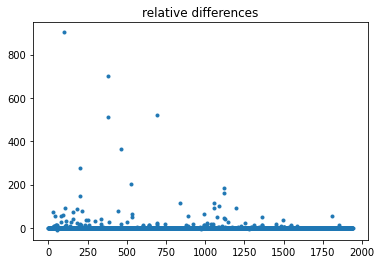

In [23]:
# independently on if if_normalize = True or False (invariant quantities)
out_chi2=compute_redchi2(data.weights,data,if_distinct=False,Sequences=Sequences)
rel_diffs=out_chi2[0]
#print('relative differences: ',rel_diffs)

a=np.array([item for sublist in rel_diffs for sublist2 in sublist for item in sublist2])
plt.plot(a,'.')
plt.title('relative differences')

chi2=out_chi2[1]
print('chi2: ',chi2)

chi2_tot=out_chi2[2]
print('total chi2: ',chi2_tot)

i_sys=0
i_type=3

print(rel_diffs[i_sys][i_type])

## 4. Read $\lambda$ parameters and $\phi$ ff coefficients

new variables: if_uNOEs, userdoc, i_choice, if_whole, nff, curr_dir_ffcorrections, userdoc_FFF, ff_cols, best_beta_FFF, best_alpha_ERFFF, best_beta_ERFFF,

ER_lambdas, FF_pars, ERFFF_lambdas, ERFFF_pars

if required, also FF_pars_pivot, ERFFF_pars_pivot

Read the outcomes of the minimizations (performed in cross validation or in the end on the whole data set)

Required inputs:

if_uNOEs and i_choice same as before


- **if_uNOEs** (if you want to include unobserved NOEs)
- **userdoc** (where you can read the ER $\lambda$ coefficients)
- **i_choice** (which force field correction do you want to consider; same as before) and **if_whole** (par_lambdas coming from minimizations in cross validation or from the minimization on the whole data set?)
- for each possible choice (i_choice, if_whole), you have:
    - **nff** (n. of force field coefficients, in my examples nff=2)
    - **curr_dir_ffcorrections** (where you can read the force field correction terms, before multiplying them by their coefficients)
    - **userdoc_FFF** (where you can read par_lambdas coefficients from minimizations)
    - **ff_cols** (the names of the ff correction terms)
    - **best_beta_FFF**, **best_alpha_ERFFF**, **best_beta_ERFFF** (best alpha, beta hyperparameters from cross validation, corresponding to the values you want to read for par_lambdas coefficients; in particular, best_beta_FFF corresponds to optimal beta for force field refinement)



In [24]:
# INPUT
def read_input(if_uNOEs,if_whole,i_choice):

    if not if_uNOEs:
        userdoc='Results/ER_no_uNOEs'

    else:
        if not if_whole: userdoc='Results/ER_skip10'
        if if_whole: userdoc='Results/ER_skip10/whole'


    # 2. select force field correction and corresponding map of parameters


    if i_choice==0:
        nff=2
        N_seeds=20
        string_choice='alpha angles'
        curr_dir_ffcorrections='DATA/oligomers/ff_terms/sincos%s'
        ff_cols=['sinalpha','cosalpha']
        userdoc_FFF='Results/ERFFF_alphaonly_skip10/'
        if if_whole: userdoc_FFF+='whole_data/'
        best_alpha_ER=10
        best_beta_FFF=100
        best_alpha_ERFFF=20
        best_beta_ERFFF=0.01

    elif i_choice==1:
        nff=2
        N_seeds=20
        string_choice='alpha,zeta angles'
        curr_dir_ffcorrections='DATA/oligomers/ff_terms/sincos%s'
        ff_cols=['sin','cos']
        userdoc_FFF='Results/ERFFF_sincos_skip10/'
        if if_whole: userdoc_FFF+='whole_data/'
        best_alpha_ER=10
        best_beta_FFF=5
        best_alpha_ERFFF=1e5
        best_beta_ERFFF=2
    elif i_choice==2:
        string_choice='chi angles'
        curr_dir_ffcorrections='DATA/oligomers/chi_correction/sincos%s'
        ff_cols=['sinchi','coschi']
        userdoc_FFF='Results/ERFFF_chi_skip10'
        best_beta_FFF=np.infty
        best_alpha_ERFFF=5
        best_beta_ERFFF=np.infty
    elif i_choice==3:
        N_seeds=20
        string_choice='alpha, zeta angles'
        curr_dir_ffcorrections='DATA/oligomers/ff_terms/sincos%s'
        ff_cols=['sinalpha','cosalpha','sinzeta','coszeta']
        userdoc_FFF='Results/ERFFF_sincos_alphazeta_skip10'
        if if_whole: userdoc_FFF+='/whole_data'
        best_alpha_ER=10
        best_beta_FFF=5 # 50
        best_alpha_ERFFF=20
        best_beta_ERFFF=0.01
        nff=4

    if not if_whole: return  userdoc,userdoc_FFF,curr_dir_ffcorrections,ff_cols,best_alpha_ER,best_beta_FFF,best_alpha_ERFFF,best_beta_ERFFF,nff,N_seeds
    return userdoc,userdoc_FFF,curr_dir_ffcorrections,ff_cols,best_alpha_ER,best_beta_FFF,best_alpha_ERFFF,best_beta_ERFFF,nff

#nff=4
#ff_cols=['sinalpha','cosalpha','sinzeta','coszeta']
#userdoc_FFF='Results/ERFFF_skip10'

In [25]:
lambdas_ER={}
lambdas_ERFFF={}
pars_FFF={}
pars_ERFFF={}

load data from minimization with all observables

set if_whole = True and run following cell

In [26]:
# variables from above with if_whole = True

if_whole=True
userdoc,userdoc_FFF,curr_dir_ffcorrections,ff_cols,best_alpha_ER,best_beta_FFF,best_alpha_ERFFF,best_beta_ERFFF,nff=read_input(if_uNOEs,if_whole,i_choice)

bs=['ER','FFF','ERFFF']
#bs=['ER','ERFFF']

for b in bs:
    if b=='ER': ER_lambdas=read_parlambda_coefficients('ER')
    elif b=='FFF': FFF_pars=read_parlambda_coefficients('FFF')
    elif b=='ERFFF': ERFFF_lambdas,ERFFF_pars=read_parlambda_coefficients('ERFFF')

for b in bs:
    if b=='ER': lambdas_ER['whole']=select_lambdapars(b,None,best_alpha_ER,None)
    elif b=='FFF': pars_FFF['whole']=select_lambdapars(b,None,None,best_beta_FFF)
    elif b=='ERFFF': lambdas_ERFFF['whole'],pars_ERFFF['whole']=select_lambdapars(b,None,best_alpha_ERFFF,best_beta_ERFFF)



#### load data from cross validation
set if_whole = False and run following cell

In [27]:
# variables from above with if_whole = False

if_whole=False
userdoc,userdoc_FFF,curr_dir_ffcorrections,ff_cols,best_alpha_ER,best_beta_FFF,best_alpha_ERFFF,best_beta_ERFFF,nff,N_seeds=read_input(if_uNOEs,if_whole,i_choice)

bs=['ER','FFF','ERFFF']
#bs=['ER','ERFFF']

for b in bs:
    if b=='ER': ER_lambdas=read_parlambda_coefficients('ER')
    elif b=='FFF': FFF_pars,FFF_pars_pivot=read_parlambda_coefficients('FFF')
    elif b=='ERFFF': ERFFF_lambdas,ERFFF_pars,ERFFF_pars_pivot=read_parlambda_coefficients('ERFFF')

for b in bs:
    for i_seed in range(N_seeds):

        if b=='ER': lambdas_ER[i_seed]=select_lambdapars(b,i_seed+1,best_alpha_ER,None)
        elif b=='FFF': pars_FFF[i_seed]=select_lambdapars(b,i_seed+1,None,best_beta_FFF)
        elif b=='ERFFF': lambdas_ERFFF[i_seed],pars_ERFFF[i_seed]=select_lambdapars(b,i_seed+1,best_alpha_ERFFF,best_beta_ERFFF)


n. of experiments:  64
n. of experiments:  244
n. of experiments:  53
n. of experiments:  246
n. of experiments:  49
n. of experiments:  285
n. of experiments:  34
n. of experiments:  283
n. of experiments:  102
n. of experiments:  581
1363
n. of experiments:  64
n. of experiments:  244
n. of experiments:  53
n. of experiments:  246
n. of experiments:  49
n. of experiments:  285
n. of experiments:  34
n. of experiments:  283
n. of experiments:  102
n. of experiments:  581


#### plot

In [35]:
alpha,zeta=np.meshgrid(np.arange(-np.pi,np.pi,0.01),np.arange(-np.pi,np.pi,0.01))

i=1
#y=ERFFF_pars['sinalpha'][i]*np.sin(alpha)+ERFFF_pars['cosalpha'][i]*np.cos(alpha)+ERFFF_pars['sinalpha'][i]*np.sin(zeta)+ERFFF_pars['cosalpha'][i]*np.cos(zeta)
y=FFF_pars['sin'][i]*np.sin(alpha)+FFF_pars['cos'][i]*np.cos(alpha)+FFF_pars['sin'][i]*np.sin(zeta)+FFF_pars['cos'][i]*np.cos(zeta)


plt.imshow(y,extent=[-np.pi,np.pi,-np.pi,np.pi])
plt.colorbar()


KeyError: 'sin'

#### check

Exclude None (failed minimizations in cross validation)

In [36]:
pars_ERFFF={k: v for k, v in pars_ERFFF.items() if v is not None}
lambdas_ERFFF={k: v for k, v in lambdas_ERFFF.items() if v is not None}

check if all the lambdas are included in the cross validation choice of observables (does it happen that some of them are always nan?)

In [37]:
ERFFF_lambdas[0]

,seed,index,alpha,beta,lambda[0],lambda[1],lambda[2],lambda[3],lambda[4],lambda[5],...,lambda[298],lambda[299],lambda[300],lambda[301],lambda[302],lambda[303],lambda[304],lambda[305],lambda[306],lambda[307]
0,11,34,inf,inf,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1,11,35,0.0,0.00,-1.249933e+38,1.165792e+37,7.691350e+35,1.004090e+38,-3.998099e+36,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2,11,36,0.0,0.01,-1.249933e+38,1.165792e+37,7.691350e+35,1.004090e+38,-3.998099e+36,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
3,11,64,0.0,0.10,-1.249933e+38,1.165792e+37,7.691350e+35,1.004090e+38,-3.998099e+36,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
4,11,74,0.0,1000000.00,-1.249933e+38,1.165792e+37,7.691350e+35,1.004090e+38,-3.998099e+36,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4062,9,4026,5.0,1.00,NaN,NaN,-4.662430e-03,NaN,-9.471260e-03,-0.000229,...,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0
4063,9,4036,5.0,20.00,NaN,NaN,-5.002540e-03,NaN,-8.518800e-03,0.003846,...,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0
4064,9,4046,5.0,2.00,NaN,NaN,-4.747170e-03,NaN,-8.864060e-03,0.001030,...,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0
4065,9,4056,5.0,50.00,NaN,NaN,-5.033640e-03,NaN,-8.530770e-03,0.004180,...,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [38]:
for i_sys in range(len(Sequences)):
    for i_obs in range(len(ERFFF_lambdas[i_sys].columns)-4):
        l=len(ERFFF_lambdas[i_sys]['lambda[%i]' % i_obs][~np.isnan(np.array(ERFFF_lambdas[i_sys]['lambda[%i]' % i_obs]).astype(float))])
        #print(l)
    if l==0: print(Sequences[i_sys],i_obs)

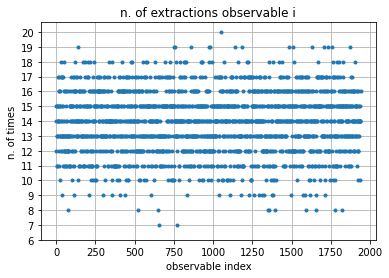

In [39]:
ns=[]
for i in range(len(Sequences)):
    #matrix=np.array(ERFFF_lambdas[i])
    matrix=np.array(ERFFF_lambdas[i][(ERFFF_lambdas[i]['alpha']==best_alpha_ERFFF) & (ERFFF_lambdas[i]['beta']==best_beta_ERFFF)])
    for j in range(4,matrix.shape[1]):
        ns.append(len(np.argwhere(matrix[:,j]==matrix[:,j]))) # count how many non-NaNs
        if len(np.argwhere(matrix[:,j]==matrix[:,j]))==0: # if all nan
            print(Sequences[i],j)

plt.plot(ns,'.')
plt.title('n. of extractions observable i')
plt.xlabel('observable index')
plt.ylabel('n. of times')
plt.yticks(range(np.int(np.min(ns))-1,np.int(np.max(ns))+1))
plt.grid()

### Plot force field corrections

Required inputs:
- **names_ff**: to which force field correction terms do the coefficients correspond to? BE CAREFUL to the correct assignment (cos has to multiply np.cos, sin np.sin...)
- **FFF_opt_pars**: force field correction coefficients (FFR); pandas dataframe [s1][s2] where s1 specifies the the seed (or mean or whole), while s2 includes seed and names_ff 
- **ERFFF_opt_pars**: force field correction coefficients (ER+FFR); as FFF_opt_pars
- **s_list**: the list of which seed (or mean or whole) you want to plot

Compute:
- plot the force field corrections

Output:
- plot


In [40]:
if i_choice==0:
    dir='alphaonly'
    names_ff=['cosalpha','sinalpha']
elif i_choice==1:
    dir='alphazeta'
    names_ff=['cos','sin']


ERFFF_opt_pars=pandas.read_pickle('Results/conclusions/'+dir+'/optimal_ff_coeff_ERFFF')
FFF_opt_pars=pandas.read_pickle('Results/conclusions/'+dir+'/optimal_ff_coeff_FFF')


In [41]:
ERFFF_opt_pars

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,mean,"whole, skip=10","whole, no skip",std
seed,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,...,15.000000,16.000000,17.00000,18.000000,19.000000,20.000000,mean,"whole, skip=10","whole, no skip",std
sinalpha,0.599663,0.425840,0.573712,0.568802,0.467499,0.662485,0.655881,0.555769,0.494576,0.475224,...,0.458166,0.484621,0.71979,0.517093,0.474517,0.538250,0.535266,0.507416,0.542506,0.078318
cosalpha,1.690353,1.868868,1.081626,1.803163,1.128587,1.492456,1.317193,0.462246,1.887355,1.216954,...,1.675826,1.962929,1.49690,1.844311,1.828892,1.640317,1.56169,1.65443,1.70557,0.358754


In [42]:
FFF_opt_pars

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,mean,"whole, skip=10","whole, no skip",std
seed,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,...,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,mean,"whole, skip=10","whole, no skip",std
sinalpha,0.782987,0.506707,0.708813,1.023504,0.665242,0.982587,0.989991,1.030089,0.921464,0.904209,...,0.857751,0.663058,0.913547,0.832780,1.124899,0.561620,0.846034,0.905317,0.868857,0.158285
cosalpha,0.444879,1.679567,-0.848944,1.987535,1.332881,1.282168,0.988067,-0.603939,1.744565,1.620240,...,2.237777,0.559947,1.652353,1.963768,2.269806,0.570391,1.29497,1.67396,1.5551,0.8465


compute standard deviations of optimal coefficients in cross validation

In [43]:
stds=[]

indices=ff_cols#FFF_opt_pars.index[1:]
for s in indices:
    wh=[val for val in ERFFF_opt_pars.columns if isinstance(val,int)]
    print(wh)
    stds.append(np.std(ERFFF_opt_pars.loc[s][wh]))

stds

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


[0.07831800130644534, 0.3587538817076956]

Text(0, 0.5, 'ff coeff. $(k_B T)$')

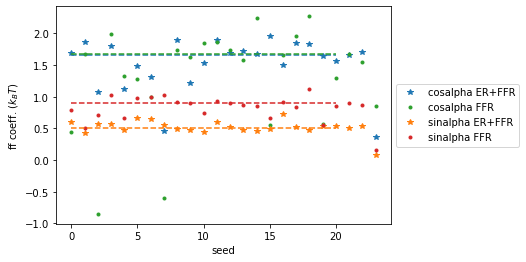

In [44]:
N=len(wh)

colors=['tab:blue','tab:orange','tab:green','tab:red']
for i,s in enumerate(names_ff):
    plt.plot(np.array(ERFFF_opt_pars.loc[s]),'*',label=s+' ER+FFR',color=colors[i])
    plt.plot(np.array(FFF_opt_pars.loc[s]),'.',label=s+' FFR',color=colors[i+2])
    #plt.plot([0,N],[ERFFF_opt_pars.loc[s]['mean'],ERFFF_opt_pars.loc[s]['mean']],'-.',label=s+' mean ER+FFR')
    plt.plot([0,N],[ERFFF_opt_pars.loc[s]['whole, skip=10'],ERFFF_opt_pars.loc[s]['whole, skip=10']],'--',color=colors[i])
    #plt.plot([0,N],[FFF_opt_pars.loc[s]['mean'],FFF_opt_pars.loc[s]['mean']],'-.',label=s+' mean FFR')
    plt.plot([0,N],[FFF_opt_pars.loc[s]['whole, skip=10'],FFF_opt_pars.loc[s]['whole, skip=10']],'--',color=colors[i+2])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('seed')
plt.ylabel(r'ff coeff. $(k_B T)$')

Text(0, 0.5, 'ff coeff. $(k_B T)$')

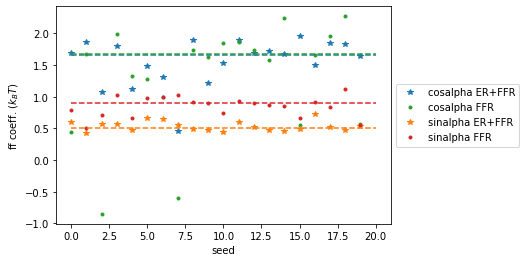

In [45]:
N=len(wh)

colors=['tab:blue','tab:orange','tab:green','tab:red']
for i,s in enumerate(names_ff):
    plt.plot(np.array(ERFFF_opt_pars.loc[s][np.arange(N)]),'*',label=s+' ER+FFR',color=colors[i])
    plt.plot(np.array(FFF_opt_pars.loc[s][np.arange(N)]),'.',label=s+' FFR',color=colors[i+2])
    #plt.plot([0,N],[ERFFF_opt_pars.loc[s]['mean'],ERFFF_opt_pars.loc[s]['mean']],'-.',label=s+' mean ER+FFR')
    plt.plot([0,N],[ERFFF_opt_pars.loc[s]['whole, skip=10'],ERFFF_opt_pars.loc[s]['whole, skip=10']],'--',color=colors[i])
    #plt.plot([0,N],[FFF_opt_pars.loc[s]['mean'],FFF_opt_pars.loc[s]['mean']],'-.',label=s+' mean FFR')
    plt.plot([0,N],[FFF_opt_pars.loc[s]['whole, skip=10'],FFF_opt_pars.loc[s]['whole, skip=10']],'--',color=colors[i+2])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('seed')
plt.ylabel(r'ff coeff. $(k_B T)$')

In [46]:
s_list=np.arange(20)

No handles with labels found to put in legend.


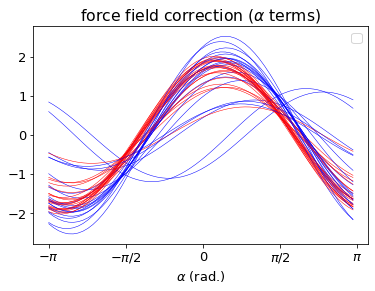

In [47]:
# plot

alpha=np.arange(-np.pi,np.pi,0.1)

plt.figure()
plt.rcParams['font.size'] = 13

for s in s_list:

    corr_ff_alpha=FFF_opt_pars[s][names_ff[0]]*np.cos(alpha)+FFF_opt_pars[s][names_ff[1]]*np.sin(alpha)
    plt.plot(alpha,corr_ff_alpha,'b',linewidth=0.5)#,label='FFR')#,'b',linewidth=0.5)

    corr_ff_alpha=ERFFF_opt_pars[s][names_ff[0]]*np.cos(alpha)+ERFFF_opt_pars[s][names_ff[1]]*np.sin(alpha)
    plt.plot(alpha,corr_ff_alpha,'r',linewidth=0.5)#,label='ER+FFR')#,'r',linewidth=2,label='average')

plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
plt.xlabel(r'$\alpha$ (rad.)')
plt.title(r'force field correction ($\alpha$ terms)')
plt.legend()

In [48]:
print(FFF_opt_pars[s])
FFF_opt_pars_err={}
FFF_opt_pars_err['sinalpha']=0.16
FFF_opt_pars_err['cosalpha']=0.85

ERFFF_opt_pars_err={}
ERFFF_opt_pars_err['sinalpha']=0.08
ERFFF_opt_pars_err['cosalpha']=0.36

seed        20.000000
sinalpha     0.561620
cosalpha     0.570391
Name: 19, dtype: float64


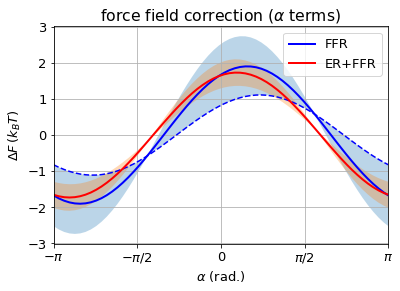

In [49]:
# plot
if_resume=True # True if you want to plot also average and whole corrections
if_plot_all=False # True if you want to plot also cross validation results

alpha=np.arange(-np.pi,np.pi+0.1,0.1)

plt.figure()
plt.rcParams['font.size'] = 13
plt.title('FFR')

for s in s_list:

    if if_plot_all:
        corr_ff_alpha=FFF_opt_pars[s][names_ff[0]]*np.cos(alpha)+FFF_opt_pars[s][names_ff[1]]*np.sin(alpha)
        plt.plot(alpha,corr_ff_alpha,'b',linewidth=0.3)

if if_resume:
    for s in ['whole, skip=10']:#['mean','whole, skip=10']:
        corr_ff_alpha=FFF_opt_pars[s][names_ff[0]]*np.cos(alpha)+FFF_opt_pars[s][names_ff[1]]*np.sin(alpha)
        plt.plot(alpha,corr_ff_alpha,'b',linewidth=2,label='FFR')

        below=(FFF_opt_pars[s][names_ff[0]]-FFF_opt_pars_err[names_ff[0]])*np.cos(alpha)+(FFF_opt_pars[s][names_ff[1]]-FFF_opt_pars_err[names_ff[1]])*np.sin(alpha)
        top=(FFF_opt_pars[s][names_ff[0]]+FFF_opt_pars_err[names_ff[0]])*np.cos(alpha)+(FFF_opt_pars[s][names_ff[1]]+FFF_opt_pars_err[names_ff[1]])*np.sin(alpha)
        plt.fill_between(alpha,below,top,alpha=0.3)
        plt.plot(alpha,below,'--b')

#plt.figure()
#plt.rcParams['font.size'] = 13
#plt.title('ER+FFR')

if if_plot_all:
    for s in s_list:

        corr_ff_alpha=ERFFF_opt_pars[s][names_ff[0]]*np.cos(alpha)+ERFFF_opt_pars[s][names_ff[1]]*np.sin(alpha)
        plt.plot(alpha,corr_ff_alpha,'r',linewidth=0.3)#,label='average')

if if_resume:
    for s in ['whole, skip=10']:#['mean','whole, skip=10']:
        corr_ff_alpha=ERFFF_opt_pars[s][names_ff[0]]*np.cos(alpha)+ERFFF_opt_pars[s][names_ff[1]]*np.sin(alpha)
        plt.plot(alpha,corr_ff_alpha,'r',linewidth=2,label='ER+FFR')

        below=(ERFFF_opt_pars[s][names_ff[0]]-ERFFF_opt_pars_err[names_ff[0]])*np.cos(alpha)+(ERFFF_opt_pars[s][names_ff[1]]-ERFFF_opt_pars_err[names_ff[1]])*np.sin(alpha)
        top=(ERFFF_opt_pars[s][names_ff[0]]+ERFFF_opt_pars_err[names_ff[0]])*np.cos(alpha)+(ERFFF_opt_pars[s][names_ff[1]]+ERFFF_opt_pars_err[names_ff[1]])*np.sin(alpha)
        plt.fill_between(alpha,below,top,alpha=0.3)

plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
plt.xlim([-np.pi,np.pi])
plt.xlabel(r'$\alpha$ (rad.)')
plt.ylabel(r'$\Delta F \,(k_B T)$')
plt.title(r'force field correction ($\alpha$ terms)')
plt.legend()
plt.grid()

## 5. Compute properties from original and reweighted ensembles
including histograms of $\alpha,\zeta$ dihedral angles, their populations, Kish ratio, reduced $\chi^2$

Required inputs:
- selected systems (Sequences), with corresponding angles (angles) and weights of each frame (w) for the reweighted ensembles (while for the original ensemble the weights are all equal)

Notes:
- to take into account all the residues, is it correct to average populations over them? Maybe it would be better to take the population corresponding to having all the $\alpha,\zeta$ angles in the (-,-) region

Read angles $\alpha,\zeta$

In [53]:
angles=[]

for n_seq in range(len(Sequences)):
    angles.append(pandas.read_csv('DATA/ff_angles/ff_angles%s' % Sequences[n_seq]))#,head=0)

if np.any(np.array(Sequences)=='UUUU'):
    nwhere=np.where(np.array(Sequences)=='UUUU')[0][0]
    angles[nwhere]=angles[nwhere][:836000]

if if_skip:
    for n_seq in range(len(Sequences)):
        angles[n_seq]=angles[n_seq][::step]

Input:
- lambdas_ER['whole'], pars_FFF['whole'], lambdas_ERFFF['whole'], pars_ERFFF['whole']

Output:
- results_wholemin dictionary, which includes: pop minus (for each residue), pop minus in all resid, histogram, kish ratio, rel diffs, redchi2, redchi2 all; each of them includes original, ER, FFF, ERFFF; each of them includes each different molecule (except for 'redchi2 all'); in short, results_wholemin[property][reweighting][molecule]

pop 1st, 2nd, 3rd, 4th refers to: population (fraction) in 1st, 2nd, 3rd, 4th quadrant of the (alpha,zeta) cartesian plane, corresponding to (alpha,zeta) = (+,+), (-,+), (-,-), (+,-)

#### visualize weights (i.e., probability distributions)

In [56]:
weights={}
weights['original']=reweight('original',Sequences,data,None,None)

for i_seed in range(20):
    weights['ERFFF, %s' % i_seed]=reweight('ERFFF',Sequences,data,pars_ERFFF[i_seed],lambdas_ERFFF[i_seed])
    #weights['ER, %s' % i_seed]=reweight('ER',Sequences,data,None,lambdas_ER[keys[i_seed]])
    #weights=reweight('FFF',Sequences,data,pars_FFF[keys[i_seed]],None)

#weights['ER whole']=reweight('ER',Sequences,data,None,lambdas_ER['whole'])
weights['ERFFF whole']=reweight('ERFFF',Sequences,data,pars_ERFFF['whole'],lambdas_ERFFF['whole'])

notice some of AAAA lambdas are NaN (more lambdas than observables)
notice some of CCCC lambdas are NaN (more lambdas than observables)
notice some of GACC lambdas are NaN (more lambdas than observables)
notice some of UUUU lambdas are NaN (more lambdas than observables)
notice some of UCAAUC lambdas are NaN (more lambdas than observables)
notice some of AAAA lambdas are NaN (more lambdas than observables)
notice some of CCCC lambdas are NaN (more lambdas than observables)
notice some of GACC lambdas are NaN (more lambdas than observables)
notice some of UUUU lambdas are NaN (more lambdas than observables)
notice some of UCAAUC lambdas are NaN (more lambdas than observables)
notice some of AAAA lambdas are NaN (more lambdas than observables)
notice some of CCCC lambdas are NaN (more lambdas than observables)
notice some of GACC lambdas are NaN (more lambdas than observables)
notice some of UUUU lambdas are NaN (more lambdas than observables)
notice some of UCAAUC lambdas are NaN (more 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


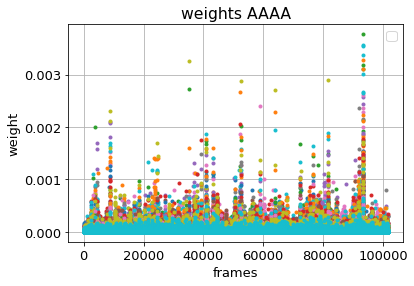

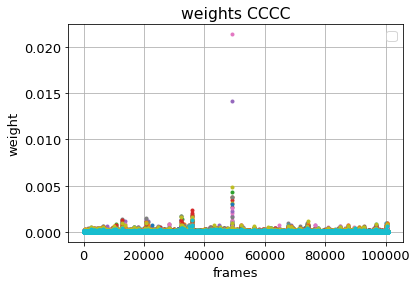

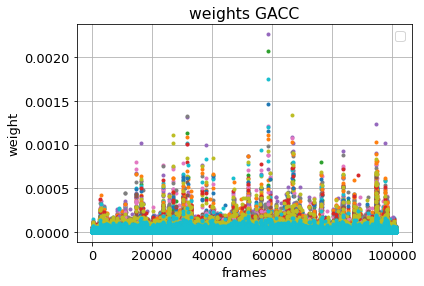

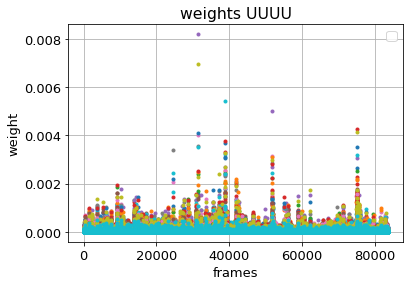

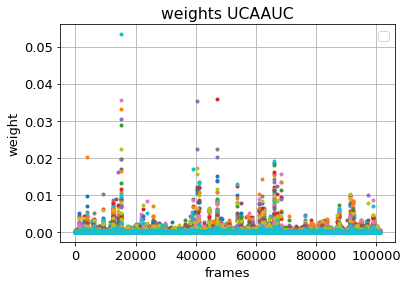

In [57]:
for i_sys in range(5):
    plt.figure()
    
    #plt.plot(weights['original'][i_sys],'.')
    
    #plt.plot(weights['ERFFF whole'][i_sys],'*',label='whole',color='tab:orange')
    #print(np.min(weights['ERFFF whole'][i_sys]/weights['original'][i_sys]))
    for i_seed in range(20):
        plt.plot(weights['ERFFF, %s' % i_seed][i_sys],'.')#,label='seed %s' % i_seed)
    
    #plt.yscale('log')
    plt.legend()
    #plt.ylim([1e-6,1e-1])
    plt.title('weights %s' % Sequences[i_sys])
    plt.xlabel('frames')
    plt.ylabel('weight')
    plt.grid()

Text(0.5, 1.0, 'components of the Kish size CCCC')

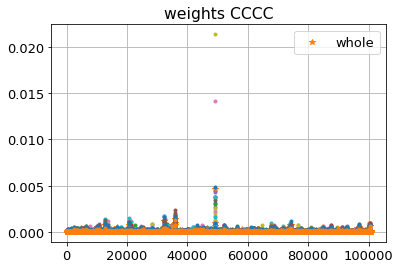

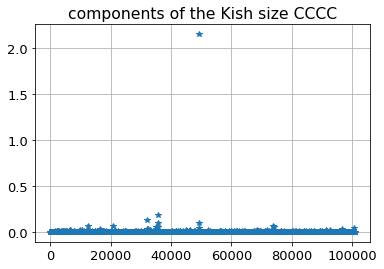

In [58]:
i_sys=1

plt.plot(weights['original'][i_sys],'.')
plt.plot(weights['ERFFF whole'][i_sys],'*',label='whole')
for i_seed in range(20):
    plt.plot(weights['ERFFF, %s' % i_seed][i_sys],'.')#,label='seed %s' % i_seed)
#plt.yscale('log')
plt.legend()
#plt.ylim([1e-6,1e-1])
plt.title('weights %s' % Sequences[i_sys])
plt.grid()

components={}

# components of the KL divergence
# components['whole'] = (weights['ERFFF whole'][i_sys]/weights['original'][i_sys])**weights['ERFFF whole'][i_sys]
# components['%s' % i_seed] = (weights['ERFFF, %s' % i_seed][i_sys]/weights['original'][i_sys])**weights['ERFFF, %s' % i_seed][i_sys]

# print(np.log(np.prod(components['whole'])))
# print(np.log(np.prod(components['%s' % i_seed])))

# components of the inverse relative Kish size
components['whole'] = (weights['ERFFF whole'][i_sys]/weights['original'][i_sys])*weights['ERFFF whole'][i_sys]
for i_seed in range(20):
    components['seed %s' % i_seed] = (weights['ERFFF, %s' % i_seed][i_sys]/weights['original'][i_sys])*weights['ERFFF, %s' % i_seed][i_sys]

sums = {}
sums['whole'] = np.sum(components['whole'])
for i_seed in range(20):
    sums['seed %s' % i_seed] = np.sum(components['seed %s' % i_seed])

plt.figure()
plt.plot(components['whole'],'*')#,label='whole')
# for i_seed in range(20):
#     plt.plot(components['seed %s' % i_seed],'.')#,label='seed %s' % i_seed)
#plt.legend()
plt.grid()
plt.title('components of the Kish size %s' % Sequences[i_sys])
#plt.yscale('log')
#plt.ylim([0.9,1.5])



how does the maximum value contribute to the whole sum?

In [59]:
print(np.max(components['whole'])/np.sum(components['whole']))

for i in range(20):
    print(np.max(components['seed %i' %i])/np.sum(components['seed %i' %i]))

0.23856418766409687
0.2586592388039548
0.19065238253641506
0.1973941124078752
0.16820234299610762
0.7165742291215188
0.12535654914950062
0.864059395691864
0.1354989918523972
0.15189050760582648
0.022643501660972648
0.1224597556824541
0.028436768734550557
0.018182702431230945
0.0642511107966381
0.1294579395035149
0.03145936541455163
0.1391493148314376
0.08076511336092196
0.21972578231103607
0.03712811390886047


In [60]:
print(sums.keys(),sums.values())
#sums[['seed %i' %i for i in range(20)]]

dict_keys(['whole', 'seed 0', 'seed 1', 'seed 2', 'seed 3', 'seed 4', 'seed 5', 'seed 6', 'seed 7', 'seed 8', 'seed 9', 'seed 10', 'seed 11', 'seed 12', 'seed 13', 'seed 14', 'seed 15', 'seed 16', 'seed 17', 'seed 18', 'seed 19']) dict_values([9.000432970478768, 5.588642852768803, 7.405269915441238, 9.614958396362114, 6.9240869084494365, 28.104854404699193, 6.060617602515102, 53.282232424835, 10.699479398111018, 6.5602835199947975, 7.408448635889397, 7.424211487997803, 7.028879687491126, 3.5443194467874877, 8.655647709502091, 3.8262112132594384, 5.236360339990742, 4.931326774489465, 3.232001034522276, 10.988570978017213, 4.293380761888872])


In [61]:
list=np.array([[k,v] for k,v in sums.items()])
print(list)
list[1:,1]

[['whole' '9.000432970478768']
 ['seed 0' '5.588642852768803']
 ['seed 1' '7.405269915441238']
 ['seed 2' '9.614958396362114']
 ['seed 3' '6.9240869084494365']
 ['seed 4' '28.104854404699193']
 ['seed 5' '6.060617602515102']
 ['seed 6' '53.282232424835']
 ['seed 7' '10.699479398111018']
 ['seed 8' '6.5602835199947975']
 ['seed 9' '7.408448635889397']
 ['seed 10' '7.424211487997803']
 ['seed 11' '7.028879687491126']
 ['seed 12' '3.5443194467874877']
 ['seed 13' '8.655647709502091']
 ['seed 14' '3.8262112132594384']
 ['seed 15' '5.236360339990742']
 ['seed 16' '4.931326774489465']
 ['seed 17' '3.232001034522276']
 ['seed 18' '10.988570978017213']
 ['seed 19' '4.293380761888872']]


array(['5.588642852768803', '7.405269915441238', '9.614958396362114',
       '6.9240869084494365', '28.104854404699193', '6.060617602515102',
       '53.282232424835', '10.699479398111018', '6.5602835199947975',
       '7.408448635889397', '7.424211487997803', '7.028879687491126',
       '3.5443194467874877', '8.655647709502091', '3.8262112132594384',
       '5.236360339990742', '4.931326774489465', '3.232001034522276',
       '10.988570978017213', '4.293380761888872'], dtype='<U18')

In [62]:
for i_seed in range(20):
    print(len(np.where(weights['ERFFF whole'][i_sys]>weights['ERFFF, %s' % i_seed][i_sys])[0])/len(weights['ERFFF whole'][i_sys]))

0.35716269841269843
0.44188492063492063
0.6449305555555556
0.4543253968253968
0.5010714285714286
0.36794642857142856
0.6365575396825397
0.7292857142857143
0.40132936507936506
0.4945535714285714
0.48540674603174605
0.45558531746031744
0.27033730158730157
0.4671825396825397
0.29624007936507935
0.36139880952380954
0.2692063492063492
0.2210813492063492
0.6568452380952381
0.24677579365079366


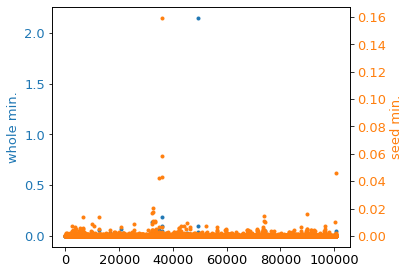

In [63]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('whole min.', color=color)
ax1.plot(components['whole'], '.', label='whole', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('seed min.', color=color)  # we already handled the x-label with ax1
ax2.plot(components['seed %s' % i_seed], '.',label='seed %s' % i_seed, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [64]:
wh = np.where(components['whole']>100)[0]

print(wh)
print(components['seed %s' % i_seed][wh])
print(np.max(components['seed %s' % i_seed]))

[]
[]
0.15940512998152018


In [65]:
weights.keys()

dict_keys(['original', 'ERFFF, 0', 'ERFFF, 1', 'ERFFF, 2', 'ERFFF, 3', 'ERFFF, 4', 'ERFFF, 5', 'ERFFF, 6', 'ERFFF, 7', 'ERFFF, 8', 'ERFFF, 9', 'ERFFF, 10', 'ERFFF, 11', 'ERFFF, 12', 'ERFFF, 13', 'ERFFF, 14', 'ERFFF, 15', 'ERFFF, 16', 'ERFFF, 17', 'ERFFF, 18', 'ERFFF, 19', 'ERFFF whole'])

In [66]:
i_sys=1
wh = np.where(weights['ERFFF whole'][i_sys]>0.04)[0]

print(wh)
print(weights['ERFFF, %s' % i_seed][i_sys][wh])
print(np.max(weights['ERFFF, %s' % i_seed][i_sys]))

[]
[]
0.001257537315161271


In [67]:
lambdas_ERFFF.keys()

dict_keys(['whole', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [68]:
lambdas_ER.keys()

dict_keys(['whole', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

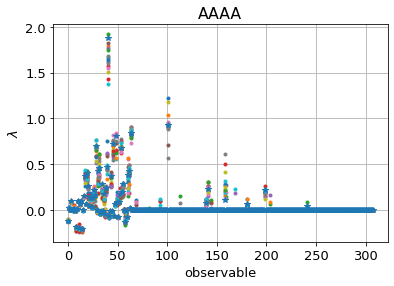

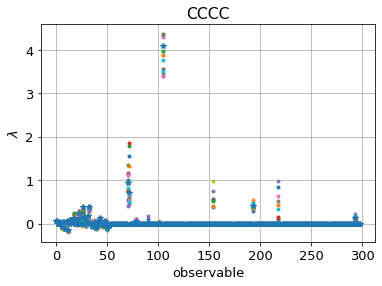

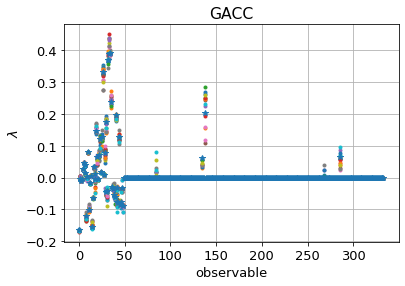

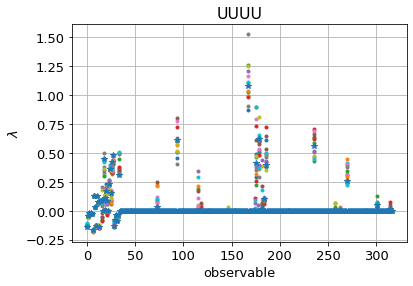

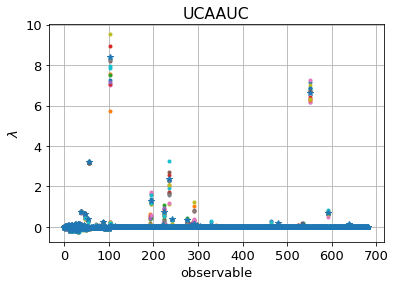

In [69]:
for i_sys in range(5):

    plt.figure()
    for i in range(20):
        plt.plot(lambdas_ER[i][i_sys],'.')

    plt.plot(lambdas_ER['whole'][i_sys],'*')
    
    plt.title(Sequences[i_sys])
    plt.xlabel('observable')
    plt.ylabel(r'$\lambda$')
    #plt.xlim([100,120])
    plt.grid()

Text(0, 0.5, 'alpha[2]')

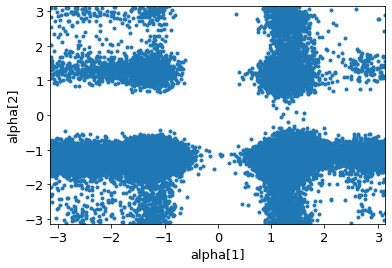

In [70]:
s1='alpha[1]'
s2='alpha[2]'

plt.plot(angles[i_sys][s1],angles[i_sys][s2],'.')
plt.plot(angles[i_sys][s1].iloc[wh],angles[i_sys][s2].iloc[wh],'*')
plt.xlim([-np.pi,np.pi])
plt.ylim([-np.pi,np.pi])
plt.xlabel(s1)
plt.ylabel(s2)

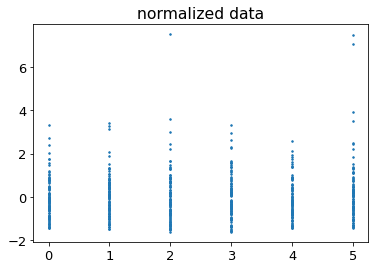

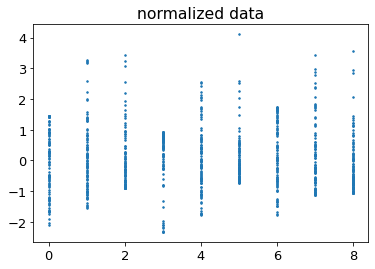

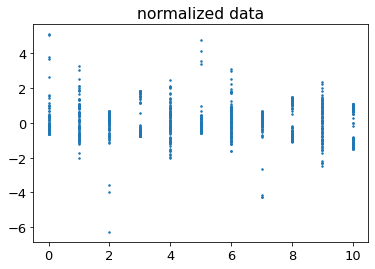

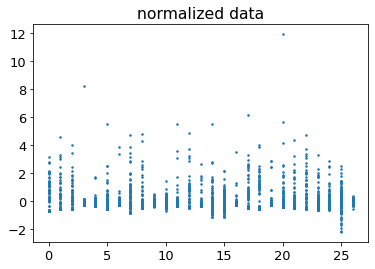

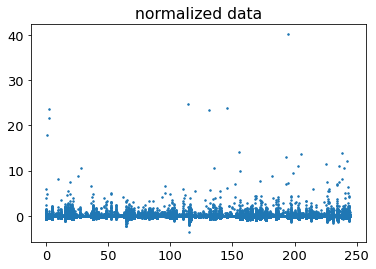

In [71]:
i_sys=1

for i_type in range(5):
    plt.figure()

    average=np.mean(data.g[i_sys][i_type],axis=0)
    stdev=np.std(data.g[i_sys][i_type],axis=0)

    #plt.errorbar(np.arange(data.g[i_sys][i_type].shape[1]),average-stdev,average+stdev,fmt='.')

    for index in np.random.randint(0,n_frames[i_sys],100):
        plt.plot(data.g[i_sys][i_type][index,:],'.',markersize=3,label=index,color='tab:blue')

    for index in wh:
        plt.plot(data.g[i_sys][i_type][index,:],'.',label=index,color='tab:orange')

    plt.title('normalized data')
    #plt.yscale('symlog')
    #plt.legend()

(array([ 7139,  7142,  7318, 48317, 72211]),)


Text(0.5, 0, 'frames')

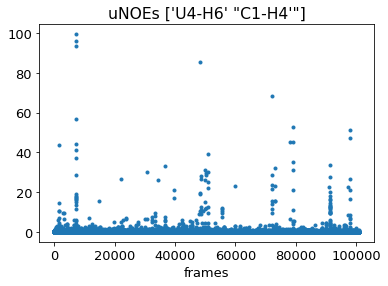

In [73]:
i_type=4

#index=np.random.randint(data.g[i_sys][i_type].shape[1])
index=-1

plt.plot(data.g[i_sys][i_type][:,index],'.')
plt.plot(wh,data.g[i_sys][i_type][wh,index],'.')
print(np.where(data.g[i_sys][i_type][:,index]>60))

name = np.load('DATA/names/CAAU/uNOEs.npy')[index]
plt.title('uNOEs %s' % name)
plt.xlabel('frames')

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


(100800, 299)


Text(0.5, 1.0, '$e^{-\\vec\\lambda\\cdot \\vec g}$')

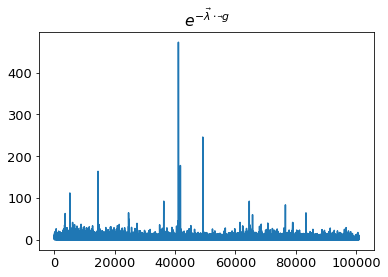

In [74]:
mat = lambdas_ERFFF['whole'][i_sys]*np.hstack((data.g[i_sys][i] for i in range(5)))
print(mat.shape)

plt.plot(np.exp(-np.sum(mat,axis=1)))
plt.title(r'$e^{-\vec\lambda\cdot \vec g}$')

#plt.plot(-np.sum(mat,axis=1))


In [75]:
print(wh,np.where(np.exp(-np.sum(mat,axis=1))>1000))

[] (array([], dtype=int64),)


contributes from different observables to $\prod_i e^{-\lambda_i g_i(t)}$ for random frames t or those corresponding to outliers (in wh)

system: CCCC


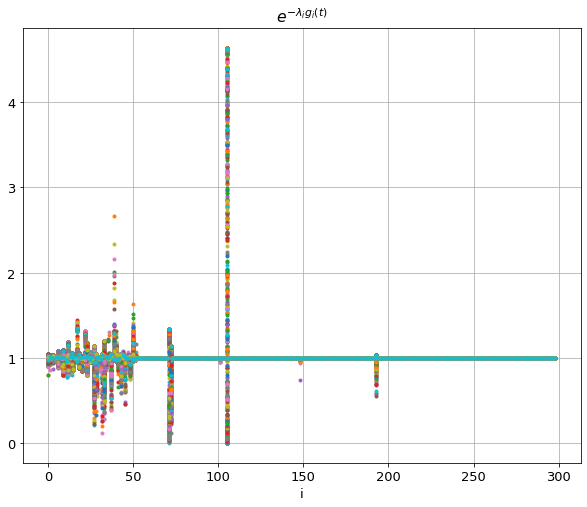

In [76]:
# font = {'size'   : 20}

# import matplotlib
# matplotlib.rc('font', **font)

print('system: %s' % Sequences[i_sys])

plt.figure(figsize=(10,8))

random_choice = np.random.randint(0,n_frames[i_sys],1000)

for i in random_choice:
#for i in wh:
    plt.plot(np.exp(-mat[i,:]),'.',label='t = %i' %i)
    #plt.plot(-mat[i,:],'.',label='t = %i' %i)
    
    #value = np.exp(-np.sum(mat[i,:]))
    #plt.plot([0,np.shape(mat)[1]],[value,value],'--')

plt.title(r'$e^{-\lambda_i g_i(t)}$')
plt.xlabel('i')
plt.grid()

#plt.yscale('log')
#plt.legend(prop={'size': 12})


NOTE: from this you can evaluate how much is the contribution of unobserved NOEs (or any other kind of quantities) to the correction of the ensemble; in particular, for each frame you have $\vec\lambda_a \cdot \vec g_a(x)$ with $a$ the kind of the observables (for example, uNOEs)

In [77]:
names_obs = {}
for b in ['backbone1_gamma_3J','backbone2_beta_epsilon_3J','sugar_3J','NOEs','uNOEs']:
    names_obs[b] = np.load('DATA/names/%s/%s.npy' % (Sequences[i_sys],b))

n_obs=[]
for key in names_obs.keys():
    n_obs.append(len(names_obs[key]))

print(n_obs)


[6, 9, 11, 27, 246]


#### Compute properties

compute following properties from reweighted ensembles (minimization on the whole data set)

In [128]:
bs=['original','ER','FFF','ERFFF']
#bs=['original','ER','ERFFF']
n_bins=100

results_wholemin={}

properties=['pop 1st','pop 2nd','pop 3rd','pop 4th','pop minus in all resid','histogram','kish ratio','rel diffs','redchi2','redchi2 all','histogram 1d']
for s in properties:
    results_wholemin[s]={}
    if not s=='redchi2 all':
        for b in bs: results_wholemin[s][b]={}


for i_b,b in enumerate(bs):

    # get weights
    if b=='original': weights=reweight(b,Sequences,data,None,None)
    elif b=='ER':
        #lambdas=select_lambdapars(b,None,best_alpha_ER,None)
        weights=reweight(b,Sequences,data,None,lambdas_ER['whole'])
    elif b=='FFF':
        #pars=select_lambdapars(b,None,None,best_beta_FFF)
        weights=reweight(b,Sequences,data,pars_FFF['whole'],None)
    elif b=='ERFFF':
        #lambdas,pars=select_lambdapars(b,None,best_alpha_ERFFF,best_beta_ERFFF)
        weights=reweight(b,Sequences,data,pars_ERFFF['whole'],lambdas_ERFFF['whole'])

    # compute observables

    for i_sys,sys in enumerate(Sequences):

        for s in ['pop 1st','pop 2nd','pop 3rd','pop 4th','histogram']:
            results_wholemin[s][b][sys]=[]

        keys=['alpha','zeta']
        results_wholemin['histogram 1d'][b][sys]={key: [] for key in keys}

        for i_resid in range(len(Sequences[i_sys])-1):
            out=np.histogram2d(angles[i_sys]['alpha[%s]' % i_resid],angles[i_sys]['zeta[%s]' % i_resid],range=[[-np.pi,np.pi],[-np.pi,np.pi]],bins=n_bins,density=True,weights=weights[i_sys])
            X_whole=out[1]
            Y_whole=out[2]
            results_wholemin['pop 1st'][b][sys].append(np.sum(out[0][np.where(X_whole[:-1]>0)].T[np.where(Y_whole[:-1]>0)].T)/np.sum(out[0]))
            results_wholemin['pop 2nd'][b][sys].append(np.sum(out[0][np.where(X_whole[:-1]<0)].T[np.where(Y_whole[:-1]>0)].T)/np.sum(out[0]))
            results_wholemin['pop 3rd'][b][sys].append(np.sum(out[0][np.where(X_whole[:-1]<0)].T[np.where(Y_whole[:-1]<0)].T)/np.sum(out[0]))
            results_wholemin['pop 4th'][b][sys].append(np.sum(out[0][np.where(X_whole[:-1]>0)].T[np.where(Y_whole[:-1]<0)].T)/np.sum(out[0]))
            results_wholemin['histogram'][b][sys].append(out[0])

            out=np.histogram(angles[i_sys]['alpha[%s]' % i_resid],bins=n_bins,density=True,weights=weights[i_sys])[0]
            results_wholemin['histogram 1d'][b][sys]['alpha'].append(out)

            out=np.histogram(angles[i_sys]['zeta[%s]' % i_resid],bins=n_bins,density=True,weights=weights[i_sys])[0]
            results_wholemin['histogram 1d'][b][sys]['zeta'].append(out)

        wh=np.where([(angles[i_sys][angles[i_sys].columns] <= 0).all(axis=1)])[1]
        results_wholemin['pop minus in all resid'][b][sys]=np.sum(weights[i_sys][wh])
        results_wholemin['kish ratio'][b][sys]=1/np.sum(weights[i_sys]**2)/n_frames[i_sys]

    chi2s=compute_redchi2(weights,data,False,Sequences)
    for i_sys,sys in enumerate(Sequences):
        results_wholemin['redchi2'][b][sys]=chi2s[1][i_sys]
        results_wholemin['rel diffs'][b][sys]=chi2s[0][i_sys]
    
    results_wholemin['redchi2 all'][b]=chi2s[2]

Results for minimizations in cross validation 

Output:
- results[property][reweighting][molecule][i_seed]

In [129]:
# compute following properties from reweighted ensembles in cross validation
bs = ['original','ER','FFF','ERFFF']

results={}

properties=['pop 1st','pop 2nd','pop 3rd','pop 4th','pop minus in all resid','histogram','kish ratio','rel diffs','redchi2','redchi2 all']
for p in properties:
    results[p]={}
    for b in bs:
        if p=='redchi2 all': results[p][b]=[]
        else:
            results[p][b]={}
            for sys in Sequences:
                results[p][b][sys]=[]

lengths={}

for i_b,b in enumerate(bs):

    if b=='original': keys=[1]
    elif b=='ER': 
        keys=[val for val in lambdas_ER.keys() if isinstance(val,int)]
        lengths[b]=len(keys)
    elif b=='FFF':
        keys=[val for val in pars_FFF.keys() if isinstance(val,int)]
        lengths[b]=len(keys)
    elif b=='ERFFF':
        keys=[val for val in pars_ERFFF.keys() if isinstance(val,int)]
        lengths[b]=len(keys)

    for i_seed in range(len(keys)):
        print('i_seed/total: ',i_seed+1,'/',len(keys))
        
        if b=='original': weights=reweight(b,Sequences,data,None,None)
        elif b=='ER':
            #lambdas=select_lambdapars(b,i_seed+1,best_alpha_ER,None)
            weights=reweight(b,Sequences,data,None,lambdas_ER[keys[i_seed]])
        elif b=='FFF':
            #pars=select_lambdapars(b,i_seed+1,None,best_beta_FFF)
            weights=reweight(b,Sequences,data,pars_FFF[keys[i_seed]],None)
        elif b=='ERFFF':
            #lambdas,pars=select_lambdapars(b,i_seed+1,best_alpha_ERFFF,best_beta_ERFFF)
            weights=reweight(b,Sequences,data,pars_ERFFF[keys[i_seed]],lambdas_ERFFF[keys[i_seed]])

        for i_sys,sys in enumerate(Sequences):
            
            for s in ['pop 1st','pop 2nd','pop 3rd','pop 4th']:
                results[s][b][sys].append([])

            for i_resid in range(len(Sequences[i_sys])-1):
                out=np.histogram2d(angles[i_sys]['alpha[%s]' % i_resid],angles[i_sys]['zeta[%s]' % i_resid],range=[[-np.pi,np.pi],[-np.pi,np.pi]],bins=n_bins,density=True,weights=weights[i_sys])
                X=out[1]
                Y=out[2]
                            
                results['pop 1st'][b][sys][i_seed].append(np.sum(out[0][np.where(X[:-1]>0)].T[np.where(Y[:-1]>0)].T)/np.sum(out[0]))
                results['pop 2nd'][b][sys][i_seed].append(np.sum(out[0][np.where(X[:-1]<0)].T[np.where(Y[:-1]>0)].T)/np.sum(out[0]))
                results['pop 3rd'][b][sys][i_seed].append(np.sum(out[0][np.where(X[:-1]<0)].T[np.where(Y[:-1]<0)].T)/np.sum(out[0]))
                results['pop 4th'][b][sys][i_seed].append(np.sum(out[0][np.where(X[:-1]>0)].T[np.where(Y[:-1]<0)].T)/np.sum(out[0]))

            wh=np.where([(angles[i_sys][angles[i_sys].columns] <= 0).all(axis=1)])[1]
            results['pop minus in all resid'][b][sys].append(np.sum(weights[i_sys][wh]))
            results['kish ratio'][b][sys].append(1/np.sum(weights[i_sys]**2)/n_frames[i_sys])

        chi2s=compute_redchi2(weights,data,False,Sequences)
        for i_sys,sys in enumerate(Sequences):
            results['redchi2'][b][sys].append(chi2s[1][i_sys])
            results['rel diffs'][b][sys].append(chi2s[0][i_sys])

        results['redchi2 all'][b].append(chi2s[2])

i_seed/total:  1 / 1
i_seed/total:  1 / 20
i_seed/total:  2 / 20
i_seed/total:  3 / 20
i_seed/total:  4 / 20
i_seed/total:  5 / 20
i_seed/total:  6 / 20
i_seed/total:  7 / 20
i_seed/total:  8 / 20
i_seed/total:  9 / 20
i_seed/total:  10 / 20
i_seed/total:  11 / 20
i_seed/total:  12 / 20
i_seed/total:  13 / 20
i_seed/total:  14 / 20
i_seed/total:  15 / 20
i_seed/total:  16 / 20
i_seed/total:  17 / 20
i_seed/total:  18 / 20
i_seed/total:  19 / 20
i_seed/total:  20 / 20
i_seed/total:  1 / 20
i_seed/total:  2 / 20
i_seed/total:  3 / 20
i_seed/total:  4 / 20
i_seed/total:  5 / 20
i_seed/total:  6 / 20
i_seed/total:  7 / 20
i_seed/total:  8 / 20
i_seed/total:  9 / 20
i_seed/total:  10 / 20
i_seed/total:  11 / 20
i_seed/total:  12 / 20
i_seed/total:  13 / 20
i_seed/total:  14 / 20
i_seed/total:  15 / 20
i_seed/total:  16 / 20
i_seed/total:  17 / 20
i_seed/total:  18 / 20
i_seed/total:  19 / 20
i_seed/total:  20 / 20
i_seed/total:  1 / 20
i_seed/total:  2 / 20
i_seed/total:  3 / 20
i_seed/tota

Compute $\Delta F$ for populations $(\alpha,\zeta)\in(-\pi,0)\times(-\pi,0)$ region

'pop 2nd' region (choose the quadrant)

In [130]:
if_crossvalid = True
if_plotwhole = True

bs=['ER','FFF','ERFFF']

if if_plotwhole:

    s='Delta F all resid'
    results_wholemin[s]={}

    for b in bs:
        results_wholemin[s][b]={}

        for sys in Sequences:
            results_wholemin[s][b][sys]=-np.log(results_wholemin['pop minus in all resid'][b][sys]/results_wholemin['pop minus in all resid']['original'][sys])

    s='Delta F'
    results_wholemin[s]={}

    for b in bs:
        results_wholemin[s][b]={}

        for sys in Sequences:
            results_wholemin[s][b][sys]=-np.log(np.array(results_wholemin['pop 2nd'][b][sys])/np.array(results_wholemin['pop 2nd']['original'][sys]))

if if_crossvalid:
    s='Delta F all resid'
    results[s]={}

    for b in bs:
        results[s][b]={}

        for sys in Sequences:
            results[s][b][sys]=[]
            for i_seed in range(lengths[b]):
                results[s][b][sys].append(-np.log(results['pop minus in all resid'][b][sys][i_seed]/results['pop minus in all resid']['original'][sys][0]))

    s='Delta F'
    results[s]={}

    for b in bs:
        results[s][b]={}

        for sys in Sequences:
            results[s][b][sys]=[]
            for i_seed in range(lengths[b]):
                results[s][b][sys].append(-np.log(np.array(results['pop 2nd'][b][sys][i_seed])/np.array(results['pop 2nd']['original'][sys][0])))


### Visualize the results

#### 1d histograms

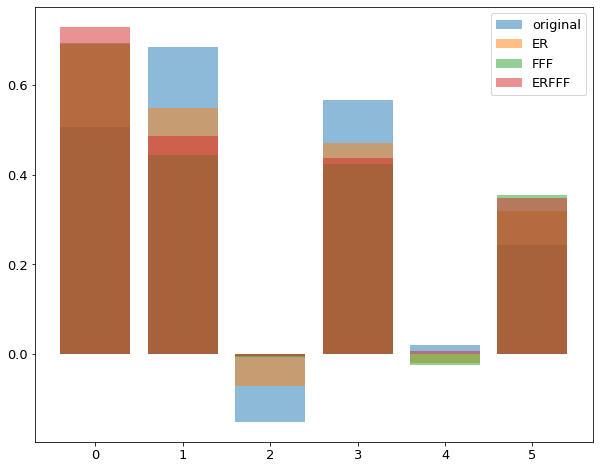

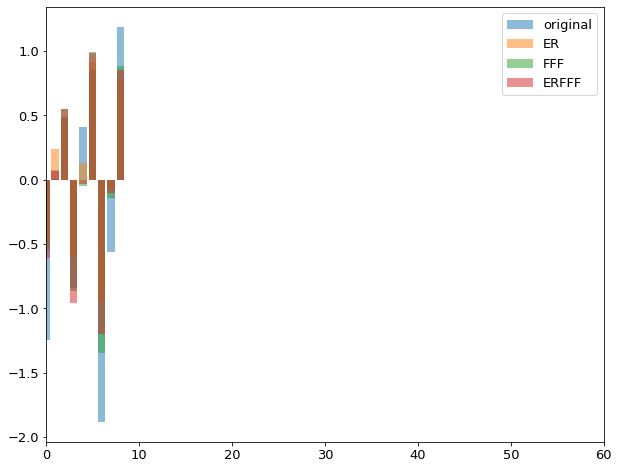

In [111]:
sys='CCCC'

plt.figure(figsize=(10,8))
for b in ['original','ER','FFF','ERFFF']:
    vec=results_wholemin['rel diffs'][b][sys][0] # 1 for uNOEs, 0 for other observables
    plt.bar(np.arange(len(vec)),vec,label=b,alpha=0.5)
    xlabel=np.concatenate([names[sys]['backbone1_gamma_3J'][:,0],names[sys]['backbone2_beta_epsilon_3J'][:,0],names[sys]['sugar_3J'][:,0],names[sys]['NOEs'][:,0]])

plt.legend()

plt.figure(figsize=(10,8))
for b in ['original','ER','FFF','ERFFF']:
    vec=results_wholemin['rel diffs'][b][sys][1] # 1 for uNOEs, 0 for other observables
    plt.bar(np.arange(len(vec)),vec,label=b,alpha=0.5)
    xlabel=names[sys]['uNOEs'][:,0]

plt.xlim([0,60])

plt.legend()

- a. at given system and angle, plot corresponding histogram (possibly reweighted) and print its population 


0.7244247787610565


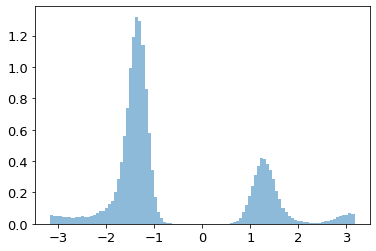

In [112]:
# a.
vec=results_wholemin['histogram 1d']['original']['AAAA']['alpha'][0]
x=np.linspace(-np.pi,np.pi,len(vec))

plt.bar(x,vec,width=2*np.pi/len(vec)+0.001,alpha=0.5)
counts_minus=np.sum(vec[x<0])/np.sum(vec)
print(counts_minus)


#### 1d histograms (before/after correction)

- b. compare histograms before/after the correction (1dim for alpha and zeta separately)


the quadruplex is:  AAAA


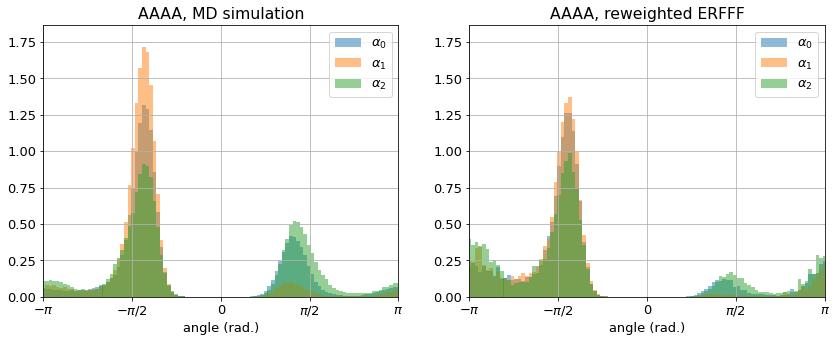

the quadruplex is:  CCCC


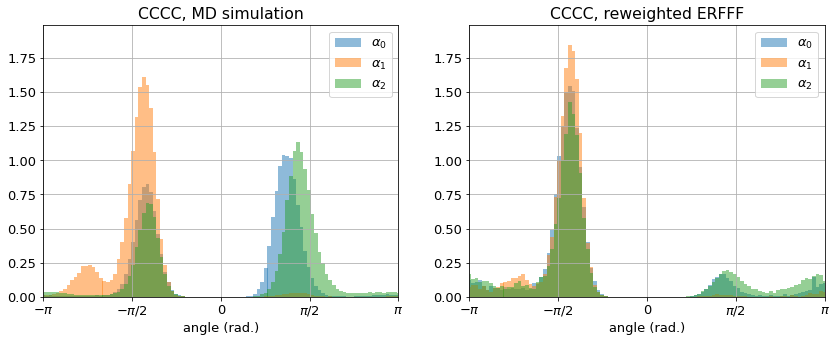

the quadruplex is:  GACC


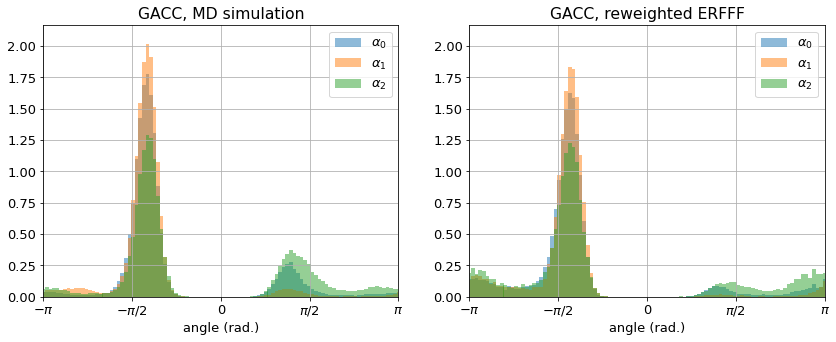

the quadruplex is:  UUUU


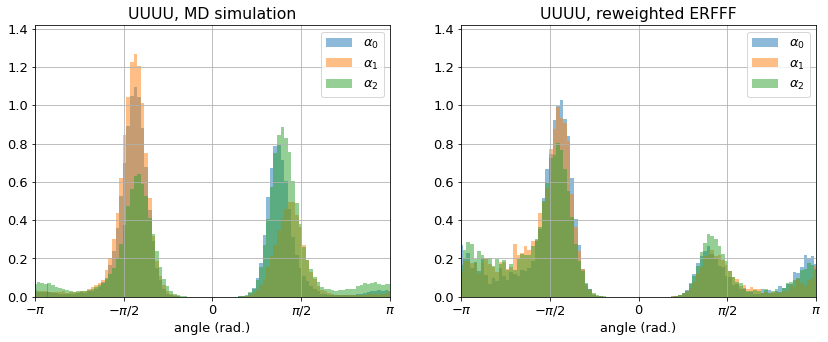

the quadruplex is:  UCAAUC


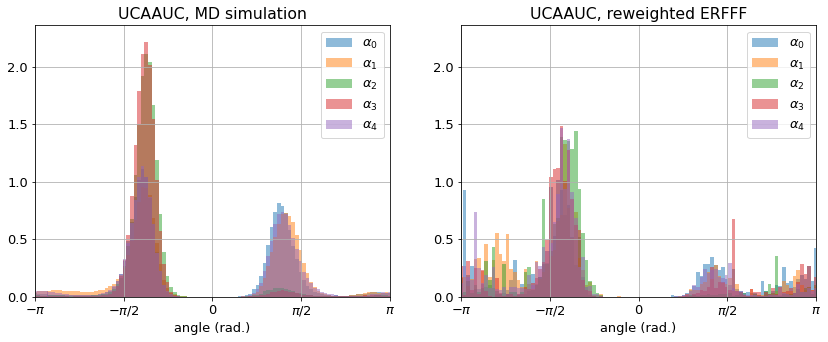

the quadruplex is:  AAAA


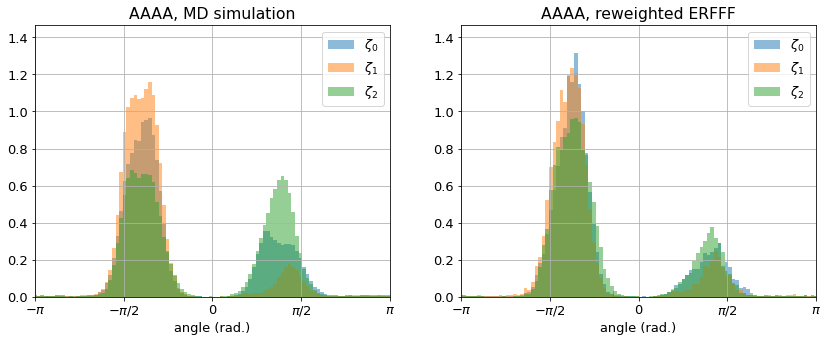

the quadruplex is:  CCCC


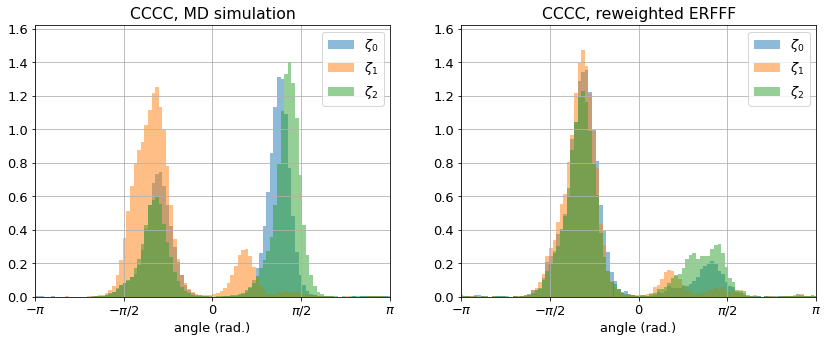

the quadruplex is:  GACC


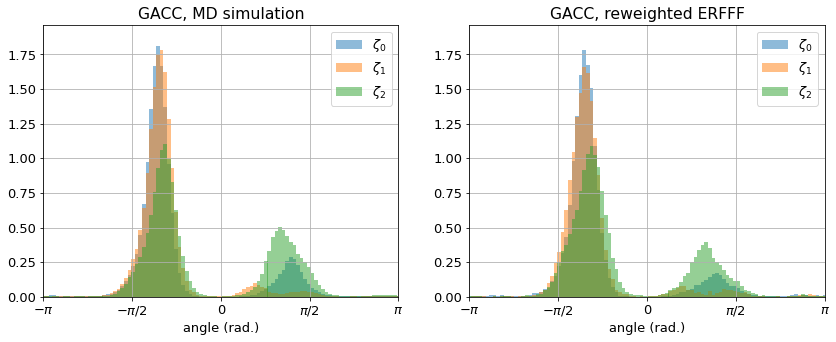

the quadruplex is:  UUUU


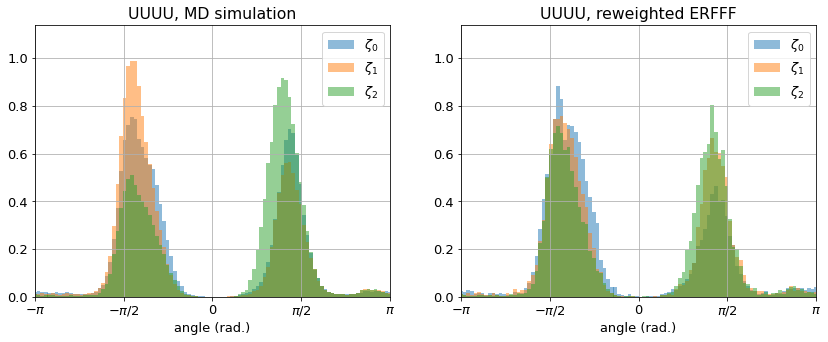

the quadruplex is:  UCAAUC


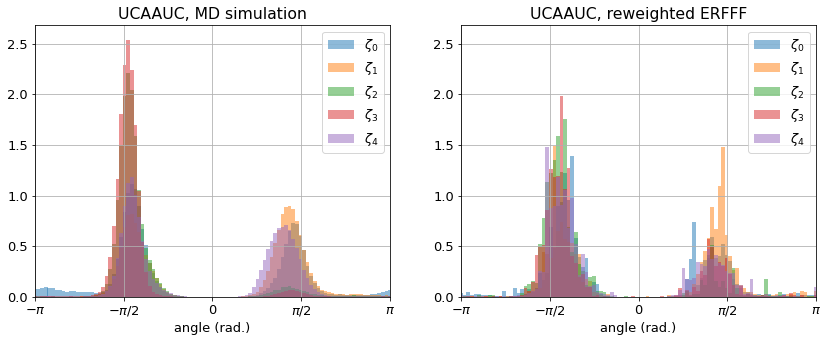

In [113]:
# b.
# comparison before / after corrections
# select reweighting:
b='ERFFF'

# alpha
for i_sys,sys in enumerate(Sequences):

    print('the quadruplex is: ',Sequences[i_sys])
    
    plt.figure(figsize=(14,5))
    plt.rcParams['font.size'] = 13

    # max for y label (same for left/right plots)
    vec1=np.hstack([results_wholemin['histogram 1d']['original'][sys]['alpha'],results_wholemin['histogram 1d'][b][sys]['alpha']])
    max=np.max(vec1)+0.15

    plt.subplot(1,2,1)
    for i in range(len(sys)-1):
        vec=results_wholemin['histogram 1d']['original'][sys]['alpha'][i]
        x=np.linspace(-np.pi,np.pi,len(vec))
        plt.bar(x,vec,width=2*np.pi/len(vec)+0.001,alpha=0.5,label=r'$\alpha_%i$' %i)
        #plt.hist(angles[i_sys][cols[i]],bins=n_bins,alpha=0.5,label=labels[i],density=True)
    plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    plt.xlabel('angle (rad.)')
    plt.xlim([-np.pi,np.pi])
    plt.ylim(top=max)
    plt.title('%s, MD simulation' % Sequences[i_sys])

    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    for i in range(len(sys)-1):
        vec=results_wholemin['histogram 1d'][b][sys]['alpha'][i]
        x=np.linspace(-np.pi,np.pi,len(vec))
        plt.bar(x,vec,width=2*np.pi/len(vec)+0.001,alpha=0.5,label=r'$\alpha_%i$' %i)
        #plt.hist(angles[i_sys][cols[i]],bins=n_bins,alpha=0.5,label=labels[i],density=True,weights=w[i_sys])
    plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    plt.xlabel('angle (rad.)')
    plt.xlim([-np.pi,np.pi])
    plt.ylim(top=max)
    plt.title('%s, reweighted %s' % (Sequences[i_sys],b))

    plt.grid()
    plt.legend()

    plt.show()

# zeta
for i_sys,sys in enumerate(Sequences):

    print('the quadruplex is: ',Sequences[i_sys])
    
    plt.figure(figsize=(14,5))
    plt.rcParams['font.size'] = 13

    plt.subplot(1,2,1)

    # max for y label (same for left/right plots)
    vec1=np.hstack([results_wholemin['histogram 1d']['original'][sys]['zeta'],results_wholemin['histogram 1d'][b][sys]['zeta']])
    max=np.max(vec1)+0.15

    for i in range(len(sys)-1):
        vec=results_wholemin['histogram 1d']['original'][sys]['zeta'][i]
        x=np.linspace(-np.pi,np.pi,len(vec))
        plt.bar(x,vec,width=2*np.pi/len(vec)+0.001,alpha=0.5,label=r'$\zeta_%i$' %i)
        #plt.hist(angles[i_sys][cols[i]],bins=n_bins,alpha=0.5,label=labels[i],density=True)
    plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    plt.xlabel('angle (rad.)')
    plt.xlim([-np.pi,np.pi])
    plt.ylim(top=max)
    plt.title('%s, MD simulation' % Sequences[i_sys])

    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    for i in range(len(sys)-1):
        vec=results_wholemin['histogram 1d'][b][sys]['zeta'][i]
        x=np.linspace(-np.pi,np.pi,len(vec))
        plt.bar(x,vec,width=2*np.pi/len(vec)+0.001,alpha=0.5,label=r'$\zeta_%i$' %i)
        #plt.hist(angles[i_sys][cols[i]],bins=n_bins,alpha=0.5,label=labels[i],density=True,weights=w[i_sys])
    plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    plt.xlabel('angle (rad.)')
    plt.xlim([-np.pi,np.pi])
    plt.ylim(top=max)
    plt.title('%s, reweighted %s' % (Sequences[i_sys],b))

    plt.grid()
    plt.legend()

    plt.show()

look at populations in different quadrants of $(\alpha,\zeta)$ plane

In [114]:
for s in ['UCAAUC']:#Sequences:
    for b1 in ['pop 2nd','pop 4th']:#['pop 1st','pop 2nd','pop 3rd','pop 4th']:
        for b in ['original']:#,'ER','ERFFF']:
            print(b1,b,results_wholemin[b1][b][s][4])


pop 2nd original 0.05405138339920939
pop 4th original 0.017104743083003932


#### Kish size

No handles with labels found to put in legend.


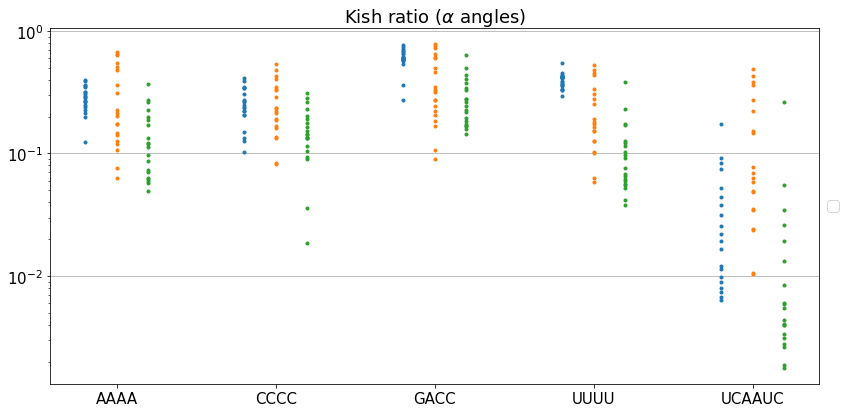

In [116]:
if_plotwhole = False

plt.figure(figsize=(12,6))
#labels=['original','ER','FFF','ERFFF']
labels=['ER','FFF','ERFFF']
#labels=['ER','ERFFF']
s='kish ratio'#pop minus in all resid'#'redchi2'
plt.rcParams['font.size'] = 15

#print(results_wholemin[s])

colors=['tab:blue','tab:orange','tab:green']

for i_b,b in enumerate(labels):

    x=np.arange(i_b,5*len(Sequences),5)
    
    if if_plotwhole:
        #if s=='pop minus': list=[np.mean(values) for values in results_wholemin['pop minus'][b].values()]
        list=[value for value in results_wholemin[s][b].values()]
        plt.bar(x,list,alpha=0.5,label=labels[i_b])

    arr=np.array([value for value in results[s][b].values()])
    for i_seed in range(arr.shape[1]):
        plt.plot(x,arr[:,i_seed],'.',color=colors[i_b])

    list=[np.mean(values) for values in results[s][b].values()]
    err=[np.std(values) for values in results[s][b].values()]
    #plt.bar(x,list,label=labels[i_b],alpha=0.5)
    #plt.plot(x,vec1[i_b],'s',label=labels[i_b])#,alpha=0.5)
    #plt.bar(x,list,alpha=0.5,label=labels[i_b])
    
    #plt.errorbar(x,list,yerr=err,fmt='s',capsize=5,lw=1,lolims=np.zeros(len(x)),label=labels[i_b])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(1+np.arange(0,5*len(Sequences),5),Sequences)#np.arange(1,len(colors)+1),labels)
#plt.ylabel(r'$-\Delta F\, (k_B T)$')
#plt.ylim([0,None])
plt.yscale('log')

plt.title(r'Kish ratio ($\alpha$ angles)')

plt.tight_layout()
plt.grid(axis='y')
plt.show()

#### Histograms observables

Which are the observables with high values of lambda?

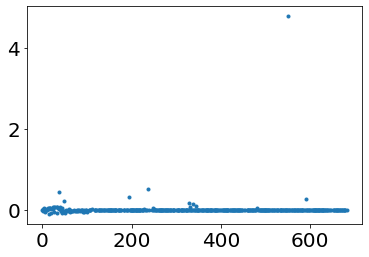

In [88]:
values = np.array(ERFFF_lambdas[i][(ERFFF_lambdas[i]['alpha']==best_alpha_ERFFF) & (ERFFF_lambdas[i]['beta']==best_beta_ERFFF)].iloc[0,4:])
plt.plot(values,'.')
#plt.xlim([500,600])

In [92]:
#test_list = [3, 5, 7, 8, 2, 4, 9]
 
# printing original list
print("The original list is : " + str(list))
 
# initializing keys for index and vals 
idx, val = "indx", "vals"
 
# initializing empty mesh
res = {idx : [], val : []}
for id, vl in enumerate(list):
    res[idx].append(id)
    res[val].append(vl)
         
# printing results
print("Constructed dictionary : " + str(res))

The original list is : [[array([0.63421286, 0.20810545, 0.85489773, 0.88203687, 0.66178936,
       0.60409763, 0.32588901, 0.27103419, 0.11301065, 0.18529016]), array([0.31028116, 0.81511913, 0.92386802, 0.95795702, 0.53856525]), array([0.60806899, 0.91487256, 0.94195851, 0.75533446, 0.47413586,
       0.20669802, 0.50333721])], [array([8.56270562e-01, 7.83964956e-01, 5.56525981e-01, 9.46743229e-01,
       1.76959685e-01, 9.28943928e-04, 2.81776524e-01, 8.96731914e-01,
       9.06835962e-01, 6.75468042e-01, 7.22286977e-01, 3.78509288e-01,
       8.92407656e-01, 4.23134353e-01])]]
Constructed dictionary : {'indx': [0, 1], 'vals': [[array([0.63421286, 0.20810545, 0.85489773, 0.88203687, 0.66178936,
       0.60409763, 0.32588901, 0.27103419, 0.11301065, 0.18529016]), array([0.31028116, 0.81511913, 0.92386802, 0.95795702, 0.53856525]), array([0.60806899, 0.91487256, 0.94195851, 0.75533446, 0.47413586,
       0.20669802, 0.50333721])], [array([8.56270562e-01, 7.83964956e-01, 5.56525981e-01,

In [90]:
[*list]

[[array([0.63421286, 0.20810545, 0.85489773, 0.88203687, 0.66178936,
         0.60409763, 0.32588901, 0.27103419, 0.11301065, 0.18529016]),
  array([0.31028116, 0.81511913, 0.92386802, 0.95795702, 0.53856525]),
  array([0.60806899, 0.91487256, 0.94195851, 0.75533446, 0.47413586,
         0.20669802, 0.50333721])],
 [array([8.56270562e-01, 7.83964956e-01, 5.56525981e-01, 9.46743229e-01,
         1.76959685e-01, 9.28943928e-04, 2.81776524e-01, 8.96731914e-01,
         9.06835962e-01, 6.75468042e-01, 7.22286977e-01, 3.78509288e-01,
         8.92407656e-01, 4.23134353e-01])]]

In [ ]:
def map_list(list):
    length = len(list)
    if length>1:


In [93]:
list=[[np.random.rand(10),np.random.rand(5),np.random.rand(7)],[np.random.rand(14)]]
list

[[array([0.16249976, 0.36865706, 0.08019203, 0.62080495, 0.43764967,
         0.44876698, 0.77412538, 0.39543351, 0.65695239, 0.49579612]),
  array([0.60894287, 0.45336942, 0.07390119, 0.49542026, 0.33443523]),
  array([0.37979037, 0.3627614 , 0.34809619, 0.96938646, 0.79649543,
         0.17112311, 0.4361225 ])],
 [array([0.47127469, 0.14806202, 0.2375594 , 0.77886026, 0.58320702,
         0.35717369, 0.24048623, 0.75969082, 0.59584856, 0.23777242,
         0.7977613 , 0.89327005, 0.68528175, 0.88030124])]]

In [97]:
counter = 0
indices = []

def single_counting(list,counter):
    for index,item in enumerate(list):
        counter+=1
        if len(item)>1:
            single_counting(list,counter)
        else:
            print(counter,index)
    return counter,index

In [96]:



for index1,item1 in enumerate(list):
    counter+=1
    if len(item1)>1:
        for index2, item2 in enumerate(item1):
            print(counter,index1,index2)
    else:
        print(counter,index)

0 0 [0.16249976 0.36865706 0.08019203 0.62080495 0.43764967 0.44876698
 0.77412538 0.39543351 0.65695239 0.49579612]
0 1 [0.60894287 0.45336942 0.07390119 0.49542026 0.33443523]
0 2 [0.37979037 0.3627614  0.34809619 0.96938646 0.79649543 0.17112311
 0.4361225 ]
1 [array([0.47127469, 0.14806202, 0.2375594 , 0.77886026, 0.58320702,
       0.35717369, 0.24048623, 0.75969082, 0.59584856, 0.23777242,
       0.7977613 , 0.89327005, 0.68528175, 0.88030124])]


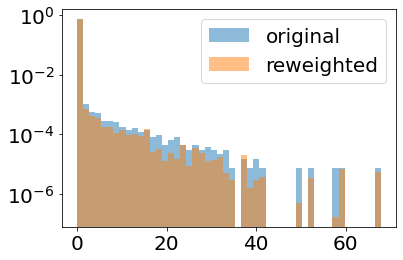

In [79]:
i_sys=0
i_type=4
i_obs=1

plt.hist(data.g[i_sys][i_type][:,i_obs],bins=50,weights=data.weights[i_sys],density=True,alpha=0.5,label='original')

weights=reweight('ERFFF',Sequences,data,pars_ERFFF[keys[i_seed]],lambdas_ERFFF[keys[i_seed]])
plt.hist(data.g[i_sys][i_type][:,i_obs],bins=50,weights=weights[i_sys],density=True,alpha=0.5,label='reweighted')

plt.yscale('log')
plt.legend()
plt.show()

#### Free energy differences

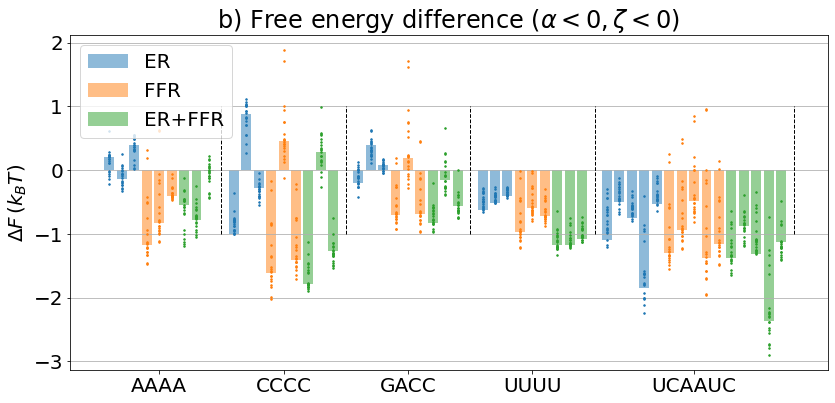

In [134]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 20

colors=['tab:blue','tab:orange','tab:green']
labels=['ER','FFR','ER+FFR']
#labels=['ER','ER+FFR']

bs=['ER','FFF','ERFFF']
#bs=['ER','ERFFF']

counter=0
for sys in Sequences:
    for i_b,b in enumerate(bs):

        #x=counter+np.arange(len(results['Delta F'][b][sys][0]))
        x=counter+np.arange(len(results_wholemin['Delta F'][b][sys]))

        if if_plotwhole:
            list=results_wholemin['Delta F'][b][sys]
            if sys==Sequences[0]: plt.bar(x,list,alpha=0.5,color=colors[i_b],label=labels[i_b])
            else: plt.bar(x,list,alpha=0.5,color=colors[i_b])

        # central values: average over different seeds
        #plt.errorbar(x,np.mean(np.array(results['Delta F'][b][sys]),axis=0),yerr=np.std(np.array(results['Delta F'][b][sys]),axis=0),capsize=5,fmt='s',color=colors[i_b],lw=1)#xerr=0.2)
        
        # central values: values of global minimization
        #plt.errorbar(x,list,yerr=np.std(np.array(results['Delta F'][b][sys]),axis=0),fmt=' ',capsize=5,color=colors[i_b],lw=1)#xerr=0.2)
        
        # points for each seed
        for i_seed in range(len(results['Delta F'][b][sys])):
            plt.plot(x,results['Delta F'][b][sys][i_seed],'.',color=colors[i_b],markersize=3)

        counter+=len(list)

    counter+=1
    plt.plot([counter-1,counter-1],[-1,1],'--k',linewidth=1)

plt.title(r'b) Free energy difference $(\alpha<0,\zeta<0)$')
#plt.ylim([-1,0.4])
plt.ylabel(r'$\Delta F \,(k_B T)$')
#plt.xlim([-1,55])
plt.legend(loc='upper left')#(loc='center left')#, bbox_to_anchor=(1, 0.5))
xticks=4+np.arange(0,10*len(Sequences),10)
xticks[-1]+=3
plt.xticks(xticks,Sequences)#np.arange(1,len(colors)+1),labels)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [137]:
list

[array([ 0.21221638, -0.14542715,  0.38701251]),
 array([-0.99861698,  0.87976742, -0.28649948]),
 array([-0.20174049,  0.39248853,  0.08073616]),
 array([-0.61981865, -0.50809588, -0.40841509]),
 array([-1.101739  , -0.50748473, -0.75813928, -1.85480766, -0.53189653])]

/u/i/igilardo/.local/lib/python3.6/site-packages/numpy/lib/stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/u/i/igilardo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: setting an array element with a sequence.

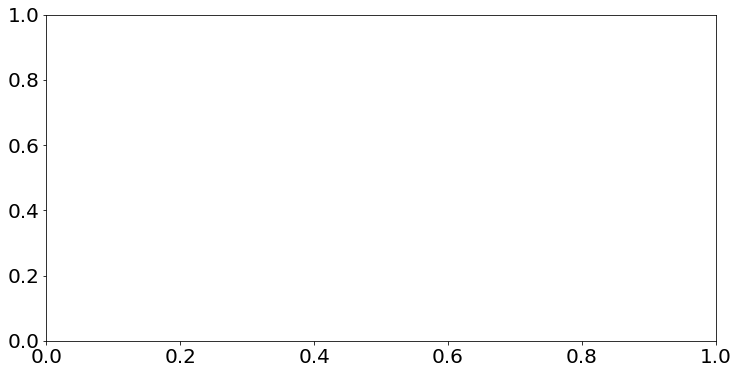

In [135]:
plt.figure(figsize=(12,6))
labels=['ER','FFF','ERFFF']

for i_b,b in enumerate(labels):

    #if s=='pop minus': list=[np.mean(values) for values in results_wholemin['pop minus'][b].values()]
    list=[value for value in results_wholemin['Delta F'][b].values()]

    x=np.arange(i_b,5*len(Sequences),5)
    plt.bar(x,list,alpha=0.5,label=labels[i_b])

    
    list=[np.mean(values) for values in results[s][b].values()]
    err=[np.std(values) for values in results[s][b].values()]
    #plt.bar(x,list,label=labels[i_b],alpha=0.5)
    #plt.plot(x,vec1[i_b],'s',label=labels[i_b])#,alpha=0.5)
    plt.errorbar(x,list,yerr=err,fmt='s')#xerr=0.2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(1+np.arange(0,5*len(Sequences),5),Sequences)#np.arange(1,len(colors)+1),labels)
#plt.ylabel(r'$-\Delta F\, (k_B T)$')
#plt.ylim([0,None])
#plt.yscale('log')

plt.title(s)

plt.tight_layout()
plt.show()

ValueError: setting an array element with a sequence.

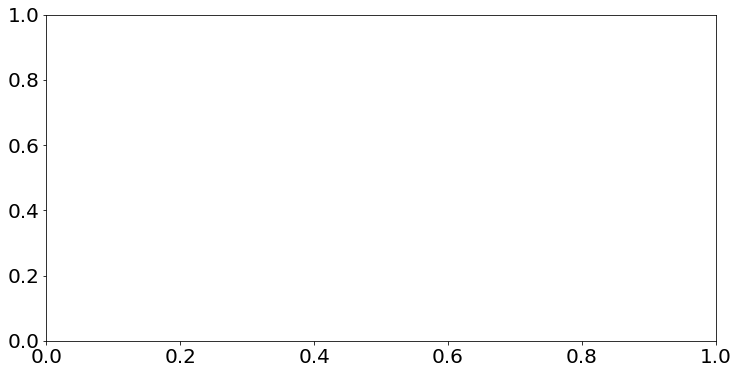

In [127]:
plt.figure(figsize=(12,6))

labels=['ER','FFF','ERFFF']
s='Delta F'

for i_b,b in enumerate(labels):

    list=[value for value in results_wholemin[s][b].values()]

    x=np.arange(i_b,(len(labels)+1)*len(Sequences),len(labels)+1)
    plt.bar(x,list,alpha=0.5,label=labels[i_b])

    
    list=[np.mean(values) for values in results[s][b].values()]
    err=[np.std(values) for values in results[s][b].values()]
    #plt.bar(x,list,label=labels[i_b],alpha=0.5)
    #plt.plot(x,vec1[i_b],'s',label=labels[i_b])#,alpha=0.5)
    plt.errorbar(x,list,yerr=err,fmt='s')#xerr=0.2)

plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(1+np.arange(0,(len(labels)+1)*len(Sequences),len(labels)+1),Sequences)#np.arange(1,len(colors)+1),labels)
#plt.ylabel(r'$-\Delta F\, (k_B T)$')
#plt.ylim([0,None])
#plt.yscale('log')

plt.ylabel(r'$\Delta F\, (k_B T)$')
#plt.ylim([0,None])
plt.grid()
plt.title(r'Free energy difference ($\alpha<0,\,\zeta<0$ region)')

plt.tight_layout()
plt.show()

#### Free energies (few visited quadrants)

In [ ]:
pops = {}

In [ ]:
pops['alphazeta constraint'] = results['Delta F']

In [ ]:
pops['alphaonly'] = results['Delta F']

In [ ]:
pops['alphazeta unconstrained'] = results['Delta F']

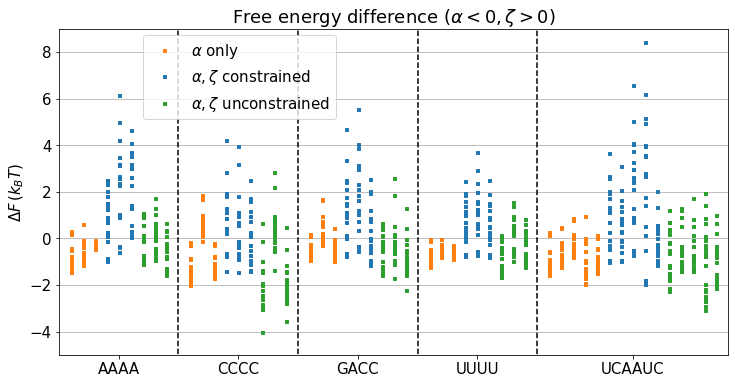

In [162]:
st_devs = {}

bs = ['alphaonly', 'alphazeta constraint','alphazeta unconstrained']
#markers = ['.','*','s']
colors = ['tab:orange','tab:blue','tab:green']
labels = [r'$\alpha$ only',r'$\alpha,\zeta$ constrained',r'$\alpha,\zeta$ unconstrained']

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 15

counter = 0
for name_sys in Sequences:
    st_devs[name_sys] = {}

    for i_b,b in enumerate(bs):
        
        arr = np.array(pops[b]['FFF'][name_sys])
        st_devs[name_sys][b] = np.std(arr,axis=0)

        for i in range(np.shape(arr)[1]):
            plt.plot(counter*np.ones(np.shape(arr[:,i])),arr[:,i],'s',markersize=3,color=colors[i_b])#markers[i_b],color='tab:orange')
            if name_sys == Sequences[0] and i == 0: 
                plt.plot(counter*np.ones(np.shape(arr[:,i])),arr[:,i],'s',markersize=3,color=colors[i_b],label=labels[i_b])#markers[i_b],color='tab:orange')
            counter+=1
    if not name_sys==Sequences[-1]: plt.plot([counter,counter],[-6,10],'--k')
    counter+=1

plt.grid(axis='y')

plt.title(r'Free energy difference $(\alpha<0,\zeta>0)$')
plt.ylabel(r'$\Delta F \,(k_B T)$')
plt.ylim([-5,9])
plt.xlim([-1,counter-1])

xticks=4+np.arange(0,10*len(Sequences),10)
xticks[-1]+=3
plt.xticks(xticks,Sequences)#np.arange(1,len(colors)+1),labels)

plt.legend(bbox_to_anchor=(0.27,0.7))
plt.show()

In [140]:
for b in bs:
    av = 0

    for name in Sequences:
        av+= np.sum(st_devs[name][b]**2)
    
    av = np.sqrt(av/15)
    print(av)

0.48761586472620433
1.5583948627019921
0.9286610815310767


#### 2d histograms

Plot histograms and $\Delta F$


Input:
- s ('Delta F' or 'Delta F all resid')

<Figure size 432x288 with 0 Axes>

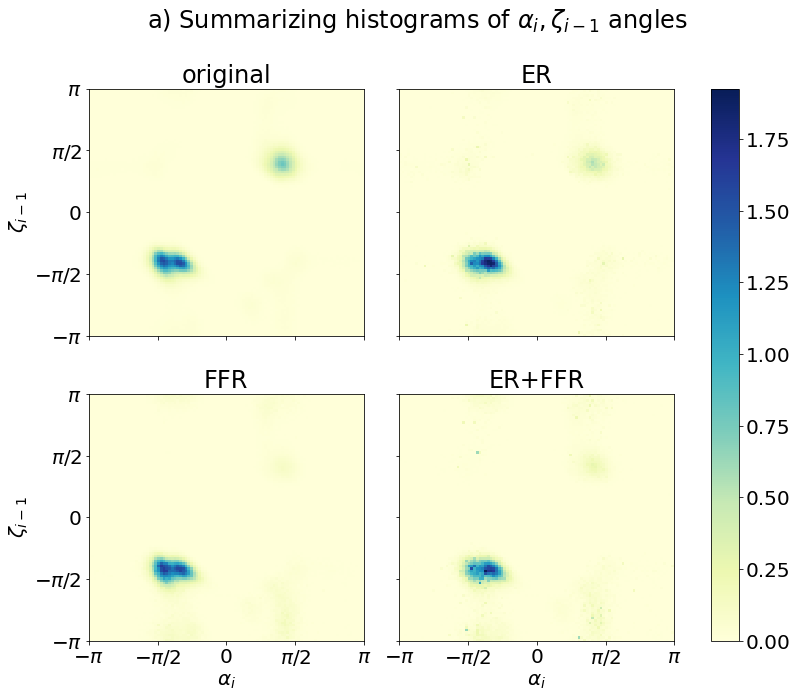

In [117]:
#sys='UCAAUC'

plt.figure()#figsize=(18,20))
plt.rcParams['font.size'] = 20

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(12,10))
plt.suptitle(r'a) Summarizing histograms of $\alpha_{i},\zeta_{i-1}$ angles')
text=['original','ER','FFR','ER+FFR']

bs=['original','ER','FFF','ERFFF']
#bs=['original','ER','ERFFF']

hist=[]
for b in bs:
    hist.append(np.mean(np.array([item1 for item in results_wholemin['histogram'][b].values() for item1 in item]),axis=0))
    #hist.append(results_wholemin['histogram'][b][sys][1]) # specific for molecule and residue [i_b][i_sys][i_resid]

#for i_b in range(4):
for i_b,ax in enumerate(axes.flat):
    #plt.subplot(3,2,i_b+1)
    # same color bar for all the histograms
    im=ax.pcolormesh(X_whole,Y_whole,hist[i_b],cmap='YlGnBu',vmin=np.nanmin(hist),vmax=np.nanmax(hist)) 

    if i_b>=2:
        ax.set(xticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],xticklabels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
        ax.set_xlabel(r'$\alpha_i$')
    else: ax.set(xticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],xticklabels=[])

    if np.mod(i_b,2)==0:
        ax.set(yticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],yticklabels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
        ax.set_ylabel(r'$\zeta_{i-1}$')
    else:
        ax.set(yticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],yticklabels=[])
    #if i_b==0: plt.colorbar()

    ax.set_xlim([-np.pi,np.pi])
    ax.set_ylim([-np.pi,np.pi])
    ax.set_title(text[i_b])

plt.tight_layout()

import matplotlib.colorbar as cb
cax,kw = cb.make_axes([ax for ax in axes.flat])
plt.colorbar(im, cax=cax, **kw)

plt.show()



In [118]:
for b in ['original','ER','FFF','ERFFF']:
    print(results_wholemin['pop 1st'][b]['AAAA'][1])

0.05389380530973482
0.06897278322221732
0.020053817524788735
0.020986410261305873


In [138]:
results_wholemin['Delta F']['ER'].values()
list=[item for value in results_wholemin['Delta F']['ER'].values() for item in value]

In [139]:
print(x)
list
results_wholemin['Delta F']['ER']

[ 0  5 10 15 20]


{'AAAA': array([ 0.21221638, -0.14542715,  0.38701251]),
 'CCCC': array([-0.99861698,  0.87976742, -0.28649948]),
 'GACC': array([-0.20174049,  0.39248853,  0.08073616]),
 'UUUU': array([-0.61981865, -0.50809588, -0.40841509]),
 'UCAAUC': array([-1.101739  , -0.50748473, -0.75813928, -1.85480766, -0.53189653])}

#### Ratio between populations in 2nd and 4th quadrants

In [30]:
ratio_13={}
ratio_24={}

for sys in Sequences:
    ratio_13[sys]=[]
    ratio_24[sys]=[]
    for i_seed in range(20):
        ratio_13[sys].append(np.array(results['pop 1st']['FFF'][sys][i_seed])/np.array(results['pop 3rd']['FFF'][sys][i_seed]))
        ratio_24[sys].append(np.array(results['pop 2nd']['FFF'][sys][i_seed])/np.array(results['pop 4th']['FFF'][sys][i_seed]))

    ratio_13[sys]=np.array(ratio_13[sys])
    ratio_24[sys]=np.array(ratio_24[sys])

In [81]:
ratio_dict = {} # average and std

for sys in Sequences:
    ratio_dict[sys] = {}
    for i in range(ratio[sys].shape[1]):
        ratio_dict[sys][i] = (np.mean(ratio[sys][:,i]),np.std(ratio[sys][:,i]))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


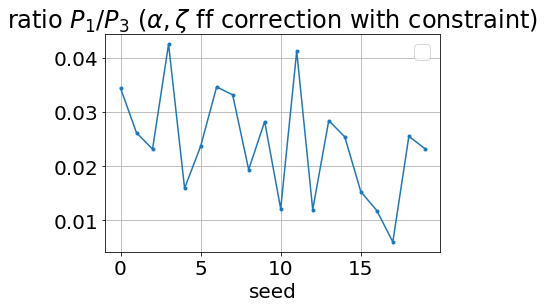

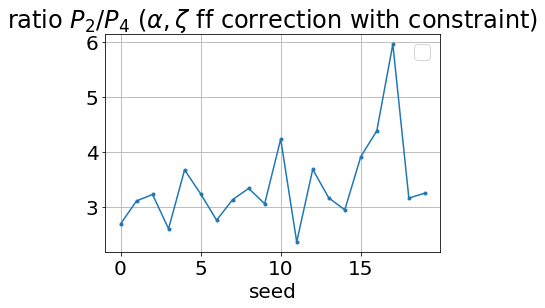

In [31]:
x=np.arange(20)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
titles=[r'ratio $P_1/P_3$',r'ratio $P_2/P_4$']

for i_ratio,ratio in enumerate([ratio_13,ratio_24]):
    plt.figure()
    for i_sys,sys in enumerate(['AAAA']):#enumerate(Sequences):
        for i in [1]:#range(ratio[sys].shape[1]):
            if i==0: plt.plot(x,ratio[sys][:,i],'.-',label='%s' % sys,color=colors[i_sys])
            else: plt.plot(x,ratio[sys][:,i],'.-',color=colors[i_sys])
    plt.title(titles[i_ratio]+r' ($\alpha,\zeta$ ff correction with constraint)')

    #plt.yscale('log')
    plt.xlabel('seed')
    #plt.legend(loc='lower left',fontsize=10)

    plt.legend()
    plt.grid()
plt.show()

### ...

5
(5,)
<class 'numpy.ndarray'> <class 'list'>
[ 0  4  8 12 16]


/u/i/igilardo/.local/lib/python3.6/site-packages/numpy/lib/stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/u/i/igilardo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: setting an array element with a sequence.

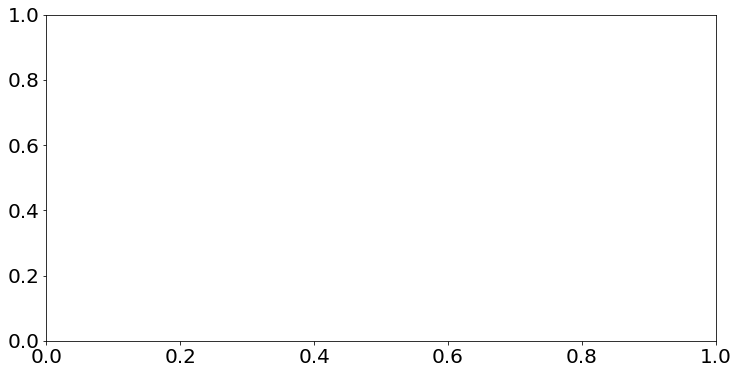

In [203]:
s='Delta F'

# plot Delta F

plt.figure(figsize=(12,6))
labels=['ER','FFF','ERFFF']

for i_b,b in enumerate(labels):

    #list=[item for value in results_wholemin[s][b].values() for item in value]
    list=[value for value in results_wholemin[s][b].values()]
    print(len(list))

    x=np.arange(i_b,(len(labels)+1)*len(Sequences),len(labels)+1)
    print(x.shape)
    print(type(x),type(list))
    print(x)
    plt.bar(x,list,alpha=0.5,label=labels[i_b])

    list=[np.mean(values) for values in results[s][b].values()]
    err=[np.std(values) for values in results[s][b].values()]
    #plt.bar(x,list,label=labels[i_b],alpha=0.5)
    #plt.plot(x,vec1[i_b],'s',label=labels[i_b])#,alpha=0.5)
    plt.errorbar(x,list,yerr=err,fmt='s')#xerr=0.2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(1+np.arange(0,(len(labels)+1)*len(Sequences),len(labels)+1),Sequences)#np.arange(1,len(colors)+1),labels)
#plt.ylabel(r'$-\Delta F\, (k_B T)$')
#plt.ylim([0,None])
#plt.yscale('log')

plt.ylabel(r'$\Delta F\, (k_B T)$')
#plt.ylim([0,None])
plt.grid()
plt.title(r'Free energy difference ($\alpha<0,\,\zeta<0$ region)')

plt.tight_layout()
plt.show()

### ...

NameError: name 'whole_hist' is not defined

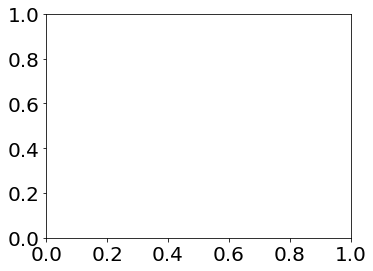

In [208]:
#from matplotlib.colors import LogNorm

plt.figure(figsize=(12,14))
plt.rcParams['font.size'] = 20

for i in range(4):
    plt.subplot(3,2,i+1)
    plt.pcolormesh(X,Y,whole_hist[i],cmap='jet',vmin=np.nanmin(whole_hist),vmax=np.nanmax(whole_hist)) # b or np.log(b))

    if i>=2:
        plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
        plt.xlabel(r'$\alpha$')
    else: plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[])

    if np.mod(i,2)==0:
        plt.yticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
        plt.ylabel(r'$\zeta$')
    else:
        plt.yticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[])
    if i==0: plt.colorbar()

    plt.xlim([-np.pi,np.pi])
    plt.ylim([-np.pi,np.pi])
    plt.title(text[i])
    

plt.tight_layout()

plt.figure(figsize=(12,5))
#plt.subplot(3,1,3)
for i in range(3):
    plt.bar(np.arange(i,4*len(DeltaF[i]),4),DeltaF[i],label=labels[i])
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks([1,5,9,13,17],Sequences)#np.arange(1,len(colors)+1),labels)
plt.ylabel(r'$-\Delta F\, (k_B T)$')
#plt.ylim([0,None])
plt.title(r'Free energy difference ($\alpha<0,\,\zeta<0$ region)')

plt.tight_layout()
plt.show()

Output:
- pop_minus[i_b][i_seed][i_sys][i_resid]
- pop_minus_allresid[i_b][i_seed][i_sys] (minus for all the residues)


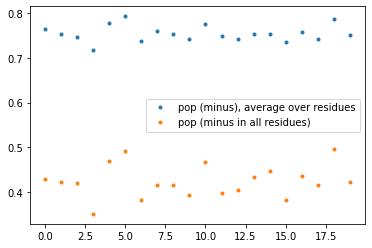

In [108]:
i_sys=0

vec=[]
vec2=[]

for i_seed in range(N_seeds):
    vec.append(np.mean(pop_minus[1][i_seed][i_sys]))
    vec2.append(pop_minus_allresid[1][i_seed][i_sys])

plt.plot(vec,'.',label='pop (minus), average over residues')
plt.plot(vec2,'.',label='pop (minus in all residues)')
plt.legend()

In [99]:
# where all the alpha, zeta angles are negative
for i_sys in range(len(Sequences)):
    wh=np.where([(angles[i_sys][angles[i_sys].columns] <= 0).all(axis=1)])[1]

    print(wh)

    #for 
    print(np.sum(data.weights[i_sys][wh]))

[     0      1      2 ... 101697 101698 101699]
0.3789773844641101
[     0      1      4 ... 100740 100743 100744]
0.2788789682539682
[     0      1      2 ... 101360 101363 101364]
0.5331656804733728
[    0     1     2 ... 83563 83564 83574]
0.14549043062200961
[     0      1      2 ... 101192 101194 101195]
0.13975296442687749


In [ ]:
labels=['original','ER','FFR','ER+FFR']


for i in range(4):
    #plt.bar(np.arange(len(pop_minus[i])),pop_minus[i],alpha=0.3)
    plt.plot(pop_minus[i],'.-',label=labels[i])
plt.title('population (-,-)')
plt.legend()
plt.xticks([1,4,7,10,14],Sequences)#np.arange(1,len(colors)+1),labels)

Output:
- pop_plus_MD[i_sys][i_angle], pop_minus_MD[i_sys][i_angle], pop_plus_rew[i_sys][i_angle], pop_minus_rew[i_sys][i_angle] (populations in the first and third quadrants, indicized by molecule and angle, i.e. residue)
- diff_plus, diff_minus (differences after-before corrections)

In [ ]:
n_bins=100

pop_plus_MD=[]
pop_minus_MD=[]
for i_sys in range(len(Sequences)):
    pop_plus_MD.append([])
    pop_minus_MD.append([])

pop_plus_rew=[]
pop_minus_rew=[]
for i_sys in range(len(Sequences)):
    pop_plus_rew.append([])
    pop_minus_rew.append([])

diff_plus=[]
diff_minus=[]
for i_sys in range(len(Sequences)):
    pop_plus_rew.append([])
    pop_minus_rew.append([])

for i_sys in range(len(Sequences)):
    cols=angles[i_sys].columns
    n_angles=len([col for col in cols if col.startswith('alpha')])

    for i in range(n_angles):
        out=plt.hist2d(angles[i_sys]['alpha[%i]' %i],angles[i_sys]['zeta[%i]' %i],bins=n_bins,cmap='jet',density=True,weights=data.weights[i_sys])
        X,Y=np.meshgrid(out[1][1:],out[2][1:])

        pop_plus_MD[i_sys].append(np.sum(out[0][(X>0)&(Y>0)])/np.sum(out[0]))
        pop_minus_MD[i_sys].append(np.sum(out[0][(X<0)&(Y<0)])/np.sum(out[0]))

        out=plt.hist2d(angles[i_sys]['alpha[%i]' %i],angles[i_sys]['zeta[%i]' %i],bins=n_bins,cmap='jet',density=True,weights=w[i_sys])
        X,Y=np.meshgrid(out[1][1:],out[2][1:])

        pop_plus_rew[i_sys].append(np.sum(out[0][(X>0)&(Y>0)])/np.sum(out[0]))
        pop_minus_rew[i_sys].append(np.sum(out[0][(X<0)&(Y<0)])/np.sum(out[0]))

    diff_plus.append((np.array(pop_plus_rew[i_sys])-np.array(pop_plus_MD[i_sys])))#/np.sqrt(np.array(pop_plus_MD[i_sys])))
    diff_minus.append((np.array(pop_minus_rew[i_sys])-np.array(pop_minus_MD[i_sys])))#/np.sqrt(np.array(pop_minus_MD[i_sys])))


In [ ]:
vec=[item for item2 in pop_plus_MD for item in item2]

plt.bar(np.arange(len(vec)),vec,label='+ region',alpha=0.3)

vec=[item for item2 in pop_minus_MD for item in item2]

plt.bar(np.arange(len(vec)),vec,label='- region',alpha=0.3)

plt.legend()

#[item for item2 in pop_plus_MD for item in item2])#,pop_minus_MD

In [ ]:
for i in range(len(Sequences)):
    print('tetramer %s' % Sequences[i])
    print('population in (+,+) angles')
    print('original force field')
    print(pop_plus_MD[i])
    print('reweighted')
    print(pop_plus_rew[i])
    print('population in (-,-) angles')
    print('original force field')
    print(pop_minus_MD[i])
    print('reweighted')
    print(pop_minus_rew[i])
    print()




In [ ]:
[item1-item2 for item1 in pop_plus_MD for item2 in pop_minus_MD]

In [ ]:
#vecs=[diff_plus,diff_minus]
vecs=[pop_plus_MD,pop_minus_MD]

length=[len(item) for item in vecs[0]]
chromos=['black','red','green','blue','cyan']

colors=[]
for i1 in range(len(length)):
    for i2 in range(length[i1]):
        colors.append(chromos[i1])


plt.figure()
plt.bar(np.arange(len(colors)),[item for array in vecs[0] for item in array],color=colors)
plt.xticks([1,4,7,10,14],Sequences)#np.arange(1,len(colors)+1),labels)
plt.title(r'$\Delta$ population + (reweighted - MD)')
plt.grid()

plt.figure()
plt.bar(np.arange(len(colors)),[item for array in vecs[1] for item in array],color=colors)
plt.xticks([1,4,7,10,14],Sequences)
plt.title('population - difference')
plt.grid()

### ...

In [ ]:
ratio=-np.log(out1[0]/out2[0])

X,Y = np.meshgrid(out1[1][1:],out1[2][1:])

plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 15

plt.scatter(X,Y,c=ratio,s=5,cmap='jet',vmin=-5)#,interpolation='none') # interpolation='lanczos'
plt.colorbar(label=r'$\Delta F (k_B T)$')
plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
plt.yticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\zeta$')
#if if_uNOEs:
#    plt.title('force field correction, with uNOEs')
#else:
#    plt.title('force field correction, without uNOEs')
plt.title('force field correction')
plt.show()

In [ ]:
i_sys=0
print(Sequences[i_sys])

n_bins=100

hist_MD=[]
hist_rew=[]
ratio=[]

for i,i_cols in enumerate(np.arange(3,6)):
    print(cols[i_cols])

    # histograms from MD and from reweighting
    plt.figure()
    hist_MD.append(plt.hist(angles[i_sys][cols[i_cols]],bins=n_bins,alpha=0.5,label=labels[i],density=True))
    hist_rew.append(plt.hist(angles[i_sys][cols[i_cols]],bins=n_bins,alpha=0.5,label=labels[i],density=True,weights=w[i_sys]))

    ratio.append(-np.log(hist_rew[i][0]/hist_MD[i][0]))

plt.figure()
for i in range(3):
    plt.plot(hist_MD[i][1][1:],ratio[i],'.-')

In [ ]:
corrections=[]
for i_sys in range(len(Sequences)):
    corrections.append(-np.log(w[i_sys]/data.weights[i_sys]))


In [ ]:
# alpha
for i_sys in range(5):
    plt.figure()#figsize=(7,5))
    plt.title(Sequences[i_sys])
    plt.hist(corrections[i_sys],bins=n_bins,alpha=0.5,density=True,cmap='jet')
    plt.grid()
    #plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    #plt.xlabel('angle (rad.)')
    #plt.title('probability density before')

In [ ]:
i_sys=1

plt.plot(angles[i_sys]['zeta[0]'],corrections[i_sys],'.')
#plt.xscale('symlog')

plt.figure(figsize=(10,8))
plt.grid()
# normalized weights
# all
#plt.scatter(angles[i_sys]['alpha[0]'],angles[i_sys]['zeta[0]'],c=corrections[i_sys],s=1,vmin=-3,vmax=3,marker='.',cmap='jet')
# disfavoured
#plt.scatter(angles[i_sys]['alpha[0]'][corrections[i_sys]>0],angles[i_sys]['zeta[0]'][corrections[i_sys]>0],c=corrections[i_sys][corrections[i_sys]>0],s=1,vmin=-3,vmax=3,marker='.',cmap='jet')
# favoured
plt.scatter(angles[i_sys]['alpha[0]'][corrections[i_sys]<0],angles[i_sys]['zeta[0]'][corrections[i_sys]<0],c=corrections[i_sys][corrections[i_sys]<0],s=1,marker='.',cmap='jet')

plt.xlabel(r'$\alpha_0$')
plt.ylabel(r'$\zeta_0$')
plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
plt.yticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
plt.xlim([-np.pi,+np.pi])
plt.ylim([-np.pi,+np.pi])
plt.title(r'free energy correction, %s tetramer ($k_B T$)' % Sequences[i_sys])
plt.colorbar()

# disfavoured
plt.figure(figsize=(10,8))
plt.grid()
plt.scatter(angles[i_sys]['alpha[0]'][corrections[i_sys]>0],angles[i_sys]['zeta[0]'][corrections[i_sys]>0],c=corrections[i_sys][corrections[i_sys]>0],s=1,marker='.',cmap='jet')

plt.xlabel(r'$\alpha_0$')
plt.ylabel(r'$\zeta_0$')
plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
plt.yticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
plt.xlim([-np.pi,+np.pi])
plt.ylim([-np.pi,+np.pi])
plt.title(r'free energy correction, %s tetramer ($k_B T$)' % Sequences[i_sys])
plt.colorbar()


## 6. Validating molecules

In [28]:
if_uNOEs=True
if_skip=True
step=10
Sequences_valid=['CAAU','UCUCGU']
curr_path='DATA/'
if_refKarplus=False

n_systems=len(Sequences_valid)
data,names,n_frames,n_experiments=load_data(Sequences_valid,curr_path,types_obs,types_obs_exp,types_angles,types_ff,if_weights,if_skip,step,if_normalize)

#data,names,n_exps,nframes=load_data(curr_path,Sequences_valid,if_uNOEs,if_skip,step,curr_dir_ffcorrections,ff_cols,if_refKarplus)
#tot_n_exp=np.sum(n_exps)
# data.g, data.f, data.weigths, data.gexp, data.normg_mean, data.normg_std


Input:
- pars_FFF, pars_ERFFF (force field correction coefficients for FFF and ER+FFF)

In [ ]:
# if if_whole:
# pars_FFF=pandas.read_pickle('Results/conclusions/alphazeta/optimal_ff_coeff_FFF').loc[:,'whole, skip=10'][ff_cols].astype(float)
# pars_ERFFF=pandas.read_pickle('Results/conclusions/alphazeta/optimal_ff_coeff_ERFFF').loc[:,'whole, skip=10'][ff_cols].astype(float)


In [29]:
# compute following properties (minimization on the whole data set)

bs=['original','FFF','ERFFF']

results_wholemin={}

properties=['kish ratio','redchi2','redchi2 all','rel diffs']
for s in properties:
    results_wholemin[s]={}
    for b in bs: results_wholemin[s][b]={}

for i_b,b in enumerate(bs):

    # get weights
    if b=='original': weights=reweight(b,Sequences_valid,data,None,None)
    elif b=='FFF': weights=reweight(b,Sequences_valid,data,pars_FFF['whole'],None)
    elif b=='ERFFF': weights=reweight('FFF',Sequences_valid,data,pars_ERFFF['whole'],None)

    # compute observables

    for i_sys,sys in enumerate(Sequences_valid):

        results_wholemin['kish ratio'][b][sys]=1/np.sum(weights[i_sys]**2)/n_frames[i_sys]

    chi2s=compute_redchi2(weights,data,False,Sequences_valid)
    for i_sys,sys in enumerate(Sequences_valid):
        results_wholemin['redchi2'][b][sys]=chi2s[1][i_sys]
        results_wholemin['rel diffs'][b][sys]=chi2s[0][i_sys]

    results_wholemin['redchi2 all'][b]=chi2s[2]

In [ ]:
# if not if_whole:

# pars_FFF=[]
# pars_ERFFF=[]

# for i_seed in range(N_seeds):
#     pars_FFF.append(pandas.read_pickle('Results/conclusions/alphazeta/optimal_ff_coeff_FFF').loc[:,i_seed][ff_cols])
#     pars_ERFFF.append(pandas.read_pickle('Results/conclusions/alphazeta/optimal_ff_coeff_ERFFF').loc[:,i_seed][ff_cols])


In [30]:
# compute following properties (cross validation minimizations)
results={}

properties=['kish ratio','redchi2','redchi2 all','rel diffs']
for p in properties:
    results[p]={}
    for b in bs:
        if not p=='redchi2 all':
            results[p][b]={}
            for sys in Sequences_valid:
                results[p][b][sys]=[]
        else:
            results[p][b]=[]

for i_b,b in enumerate(bs):

    if b=='original': keys=[1]
    elif b=='FFF':
        keys=[val for val in pars_FFF.keys() if isinstance(val,int)]
    elif b=='ERFFF':
        keys=[val for val in pars_ERFFF.keys() if isinstance(val,int)]

    for i_seed in range(len(keys)):
        
        if b=='original': weights=reweight(b,Sequences_valid,data,None,None)
        elif b=='FFF': weights=reweight(b,Sequences_valid,data,pars_FFF[keys[i_seed]],None)
        elif b=='ERFFF': weights=reweight('FFF',Sequences_valid,data,pars_ERFFF[keys[i_seed]],None)

        chi2s=compute_redchi2(weights,data,False,Sequences_valid)

        for i_sys,sys in enumerate(Sequences_valid):

            results['kish ratio'][b][sys].append(1/np.sum(weights[i_sys]**2)/n_frames[i_sys])
            results['redchi2'][b][sys].append(chi2s[1][i_sys])
            results['rel diffs'][b][sys].append(chi2s[0][i_sys])

        results['redchi2 all'][b].append(chi2s[2])

In [31]:
print('red. chi2 on the whole set of molecules')
for b in ['original','FFF','ERFFF']:
    print(b,results_wholemin['redchi2 all'][b],'(',np.mean(results['redchi2 all'][b]),'+-',np.std(results['redchi2 all'][b]),')')


red. chi2 on the whole set of molecules
original 211.29213157513234 ( 211.29213157513234 +- 0.0 )
FFF 23.64272179690973 ( 26.11976658900786 +- 9.920206999248181 )
ERFFF 51.415429949586674 ( 48.512956833677535 +- 8.71591988254862 )


In [32]:
for b in ['original','FFF','ERFFF']:
    print(results_wholemin['redchi2'][b])

{'CAAU': 243.7864976006133, 'UCUCGU': 14.100293913652104}
{'CAAU': 24.831964201000776, 'UCUCGU': 16.425812413179113}
{'CAAU': 57.524356519082666, 'UCUCGU': 14.343450904563111}


In [33]:
chi2=[]
for b1 in ['CAAU','UCUCGU']:
    for b in ['original','FFF','ERFFF']:
        chi2.append(results_wholemin['redchi2'][b][b1])
for b in ['original','FFF','ERFFF']:
    chi2.append(results_wholemin['redchi2 all'][b])

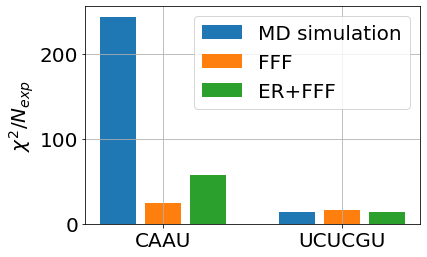

In [34]:
plt.rcParams['font.size'] = 20

labels1 = ['CAAU','UCUCGU']#,'both']

#for i,b in enumerate(['original','FFF','ERFFF']):
# plt.bar([0,4,8],[243.79,14.1,211.29],label='MD simulation') # chi2 original
# plt.bar([1,5,9],[24.83,16.43,23.64],label='FFF') # chi2 FFF
# plt.bar([2,6,10],[57.52,14.34,51.42],label='ER+FFF') # chi2 ERFFF

plt.bar([0,4],[243.79,14.1],label='MD simulation') # chi2 original
plt.bar([1,5],[24.83,16.43],label='FFF') # chi2 FFF
plt.bar([2,6],[57.52,14.34],label='ER+FFF') # chi2 ERFFF

plt.xticks(1+np.arange(0,4*len(labels1),4),labels1)

plt.ylabel(r'$\chi^2/N_{exp}$')
#plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

### ...

In [35]:
plt.figure(figsize=(12,6))
labels=['MD simulation','FFF','ER+FFF']
s='pop minus in all resid'#'redchi2'

for i_b,b in enumerate(labels):

    #if s=='pop minus': list=[np.mean(values) for values in results_wholemin['pop minus'][b].values()]
    list=[v1 for value in v for v1 in value]

    x=np.arange(i_b,4*len(Sequences_valid),4)
    print(x,list)
    plt.bar(x,list,alpha=0.5,label=labels[i_b])

    
    list=[np.mean(values) for values in results[s][b].values()]
    err=[np.std(values) for values in results[s][b].values()]
    #plt.bar(x,list,label=labels[i_b],alpha=0.5)
    #plt.plot(x,vec1[i_b],'s',label=labels[i_b])#,alpha=0.5)
    plt.errorbar(x,list,yerr=err,fmt='s')#xerr=0.2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(1+np.arange(0,5*len(Sequences),5),Sequences)#np.arange(1,len(colors)+1),labels)
#plt.ylabel(r'$-\Delta F\, (k_B T)$')
#plt.ylim([0,None])
#plt.yscale('log')

plt.title(s)

plt.tight_layout()
plt.show()

NameError: name 'v' is not defined

<Figure size 864x432 with 0 Axes>

original redchi2 [[1.4381985222544802, 286.2135197498568], [14.917702256472529, 0.0]]


TypeError: only size-1 arrays can be converted to Python scalars

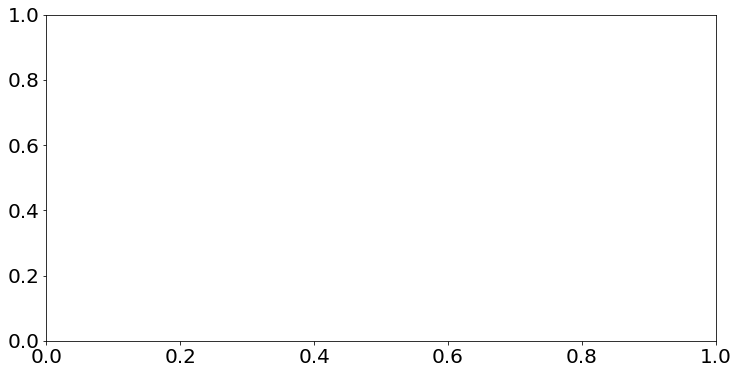

In [50]:
plt.figure(figsize=(12,6))
labels=['original','FFF','ERFFF']
s='redchi2'

for i_b,b in enumerate(labels):

    #if s=='pop minus': list=[np.mean(values) for values in results_wholemin['pop minus'][b].values()]
    list=[value for value in results_wholemin[s][b].values()]
    print(b,s,list)

    x=np.arange(i_b,(len(labels)+1)*len(Sequences_valid),len(labels)+1).tolist()
    plt.bar(x,list,alpha=0.5,label=labels[i_b])

    list=[np.mean(values) for values in results[s][b].values()]
    err=[np.std(values) for values in results[s][b].values()]
    print('means and errors: ',list,err)

    #plt.bar(x,list,label=labels[i_b],alpha=0.5)
    #plt.plot(x,vec1[i_b],'s',label=labels[i_b])#,alpha=0.5)
    plt.errorbar(x,list,yerr=err,fmt='s')#xerr=0.2)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(1+np.arange(0,(len(labels)+1)*len(Sequences_valid),len(labels)+1),Sequences_valid)#np.arange(1,len(colors)+1),labels)
#plt.ylabel(r'$-\Delta F\, (k_B T)$')
#plt.ylim([0,None])
#plt.yscale('log')

plt.title(s)

plt.tight_layout()
plt.show()


number of observables for  CAAU  molecule:  [66, 377]


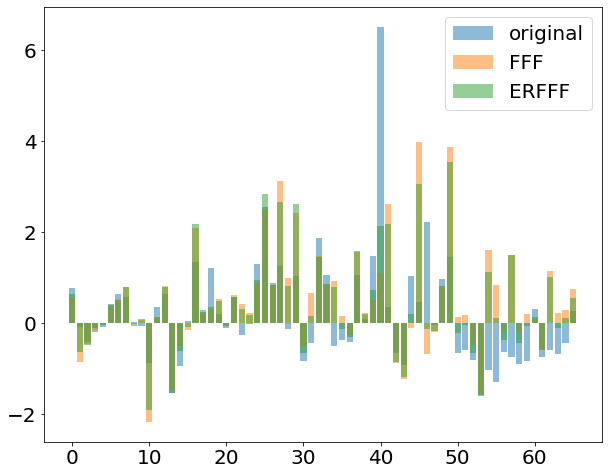

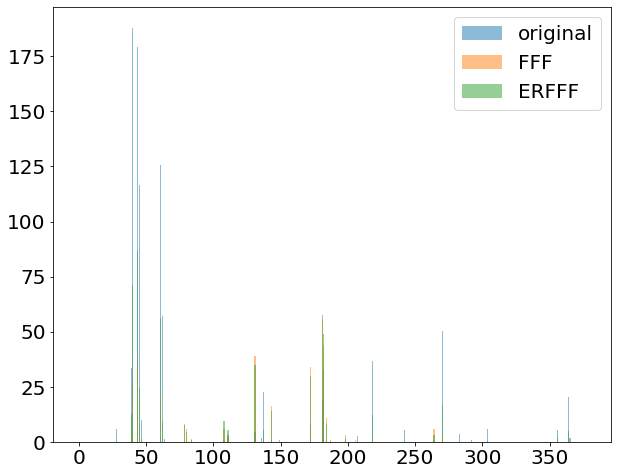

In [52]:
sys='CAAU'

print('number of observables for ',sys,' molecule: ',n_exp_all[sys])

plt.figure(figsize=(10,8))
for b in ['original','FFF','ERFFF']:#,'ERFFF']:
    vec=results_wholemin['rel diffs'][b][sys][0] # 1 for uNOEs, 0 for other observables
    plt.bar(np.arange(len(vec)),vec,label=b,alpha=0.5)
    xlabel=np.concatenate([names.backbone1[i_sys][:,0],names.backbone1[i_sys][:,0],names.sugar[i_sys][:,0],names.noe[i_sys][:,0]])

plt.legend()

plt.figure(figsize=(10,8))
for b in ['original','FFF','ERFFF']:#,'ERFFF']:
    vec=results_wholemin['rel diffs'][b][sys][1] # 1 for uNOEs, 0 for other observables
    plt.bar(np.arange(len(vec)),vec,label=b,alpha=0.5)
    xlabel=names.unoe[i_sys][:,0]

#plt.xlim([0,60])

plt.legend()

Input:
- pars_FFF[i_seed], pars_ERFFF[i_seed] (force field correction coefficients for FFF and ER+FFF)

### ...

In [ ]:
b='original'
pars=None
lambdas=None

w=reweight(b,Sequences_valid,data,pars,lambdas)
kish=compute_kishsize(data,w,nframes,Sequences_valid)
out_chi2_orig=compute_redchi2(w,data,if_distinct=False,Sequences=Sequences_valid)
print(out_chi2_orig[1])

validation_chi2=pandas.DataFrame(data=None,columns=Sequences_valid+['reduced'])
validation_chi2.loc['original ff']=out_chi2_orig[1]+[out_chi2_orig[2]]

In [ ]:
for i_sys in [0]:#range(2):
    #plt.plot(out_chi2_orig[0][i_sys][0])
    plt.plot(out_chi2_orig[0][i_sys][1],'.',label='original')
    #plt.plot(out_chi2_FFF[0][i_sys][0])
    plt.plot(out_chi2_FFF[0][i_sys][1],'.',label='FFF')
    #plt.plot(out_chi2_ERFFF[0][i_sys][0])
    plt.plot(out_chi2_ERFFF[0][i_sys][1],'.',label='ERFFF')

plt.yscale('symlog')
plt.legend()

a=out_chi2_FFF[0][i_sys][1]
b=out_chi2_ERFFF[0][i_sys][1]
print(len(a[a<b]),len(a[a>b]))

In [ ]:
names=ff_cols
for i_seed in range(1,21):#'all'

    # FFF
    best_beta=best_beta_FFF
    if not i_seed=='all':
        pars=FFF_pars[(FFF_pars['beta']==best_beta) & (FFF_pars['seed']==i_seed)][names].squeeze()
    else:
        pars=FFF_pars_pivot['mean'].loc[best_beta]
    print(pars)
    #print(type(pars))

    if not pars.empty:
        b='FFF'
        w_FFF=reweight(b,Sequences_valid,data,pars,None)
        kish=compute_kishsize(data,w_FFF,nframes,Sequences_valid)
        out_chi2_FFF=compute_redchi2(w_FFF,data,if_distinct=False,Sequences=Sequences_valid)
        #print(out_chi2_FFF[1])
        validation_chi2.loc['FFF ff %s' %(i_seed)]=out_chi2_FFF[1]+[out_chi2_FFF[2]]
    else:
        validation_chi2.loc['FFF ff %s' %(i_seed)]=[np.nan,np.nan,np.nan]

    # ER+FFF
    best_alpha=best_alpha_ERFFF
    best_beta=best_beta_ERFFF
    if not i_seed=='all':
        pars=ERFFF_pars[(ERFFF_pars['alpha']==best_alpha) & (ERFFF_pars['beta']==best_beta) & (ERFFF_pars['seed']==i_seed)][names].squeeze()
    else:
        pars=[ERFFF_pars_pivot['mean'][names[0]].loc[best_alpha,best_beta],ERFFF_pars_pivot['mean'][names[1]].loc[best_alpha,best_beta]]
        pars=pandas.Series(pars)
        pars.index=names#['sinalpha','cosalpha']
    print(pars)
    #print(type(pars))
    if not pars.empty:
        b='FFF'
        w_ERFFF=reweight(b,Sequences_valid,data,pars,None)
        kish=compute_kishsize(data,w_ERFFF,nframes,Sequences_valid)
        out_chi2_ERFFF=compute_redchi2(w_ERFFF,data,if_distinct=False,Sequences=Sequences_valid)
        #print(out_chi2_ERFFF[1])
        validation_chi2.loc['ER+FFF ff %s' %(i_seed)]=out_chi2_ERFFF[1]+[out_chi2_ERFFF[2]]
    else:
        validation_chi2.loc['ER+FFF ff %s' %(i_seed)]=[np.nan,np.nan,np.nan]

validation_chi2=validation_chi2.sort_index(axis=0)

In [ ]:
filter_index=validation_chi2.index.str.startswith('ER+FFF ff')
validation_chi2.loc['ER+FFF mean']=np.nanmean(validation_chi2.loc[filter_index],axis=0)
filter_index=validation_chi2.index.str.startswith('FFF ff')
validation_chi2.loc['FFF mean']=np.nanmean(validation_chi2.loc[filter_index],axis=0)

In [ ]:
validation_chi2

In [ ]:
validation_chi2.loc['FFF mean ff coeff.']=out_chi2_FFF[1]+[out_chi2_FFF[2]]
validation_chi2.loc['ER+FFF mean ff coeff.']=out_chi2_ERFFF[1]+[out_chi2_ERFFF[2]]

In [ ]:
validation_chi2

In [ ]:
#validation_chi2.to_pickle('Results/conclusions/alphazeta/valid_redchi2')

In [ ]:
s='Results/conclusions/alphazeta/optimal_ff_coeff_'

FFF_opt_pars=pandas.read_pickle(s+'FFF')['mean']
FFF_opt_pars=pandas.Series(FFF_opt_pars[1:]).astype('float64')
print(FFF_opt_pars)

w_FFF=reweight('FFF',Sequences_valid,data,FFF_opt_pars,None)
kish=compute_kishsize(data,w_FFF,nframes,Sequences_valid)
out_chi2_FFF=compute_redchi2(w_FFF,data,if_distinct=False,Sequences=Sequences_valid)
print(out_chi2_FFF[1],out_chi2_FFF[2])
#validation_chi2.loc['%s, FFF ff %s' %(string_choice,i_seed)]=out_chi2_FFF[1]+[out_chi2_FFF[2]]


ERFFF_opt_pars=pandas.read_pickle(s+'ERFFF')['mean']#['whole, skip=10']
ERFFF_opt_pars=pandas.Series(ERFFF_opt_pars[1:]).astype('float64')
print(ERFFF_opt_pars)

w_ERFFF=reweight('FFF',Sequences_valid,data,ERFFF_opt_pars,None)
kish=compute_kishsize(data,w_ERFFF,nframes,Sequences_valid)
out_chi2_ERFFF=compute_redchi2(w_ERFFF,data,if_distinct=False,Sequences=Sequences_valid)
print(out_chi2_ERFFF[1],out_chi2_ERFFF[2])

In [ ]:
w=w_FFF[1]

D_KL=np.sum(np.log(w)*w)+np.log(len(w))
kish=np.sum(w**2)

av_mean=kish*len(w)
geom_mean=np.exp(D_KL)

print(1/av_mean*len(w))
print(1/geom_mean*len(w))

In [ ]:
np.exp(-20)*1e5

In [ ]:
kish

In [ ]:
valid_chi2=pandas.read_pickle('Results/conclusions/alphaonly/valid_redchi2')
#valid_chi2.loc['alpha angles, ER+FFF whole, skip=10']=out_chi2_ERFFF[1]+[out_chi2_ERFFF[2]]
#valid_chi2.loc['alpha angles, FFF whole, skip=10']=out_chi2_FFF[1]+[out_chi2_FFF[2]]
#valid_chi2.to_pickle('Results/conclusions/alphaonly/valid_redchi2')

In [ ]:
pandas.read_pickle('Results/conclusions/alphaonly/valid_redchi2')

In [ ]:
#np.save('Results/reweights/ERFFF_%s' % Sequences_valid[1],w_ERFFF[1])

In [ ]:
plt.title('alpha angles correction')
filter_rows1=validation_chi2.index.str.startswith('alpha angles, FFF ff')
filter_rows2=validation_chi2.index.str.startswith('alpha angles, ER+FFF ff')
for s in validation_chi2.columns:
    plt.plot(np.arange(len(validation_chi2.loc[filter_rows1])),validation_chi2.loc[filter_rows1,s],'*',label='FFF %s' %s)
    plt.plot(np.arange(len(validation_chi2.loc[filter_rows2])),validation_chi2.loc[filter_rows2,s],'*',label='ERFFF %s' %s)
    plt.plot(np.arange(len(validation_chi2.loc[filter_rows1])),validation_chi2.loc['original ff'][s]*np.ones(len(validation_chi2.loc[filter_rows1])),'--',label='original ff %s' %s)

plt.legend(bbox_to_anchor=(1.1, 1.05))
#plt.ylim([0,100])

In [ ]:
print(validation_chi2.loc['original ff'])

print('FFF')
filter_rows1=['alpha angles, FFF ff %i' %i for i in range(1,21)]
#validation_chi2.index.str.startswith('alpha angles, FFF ff') # exclude all
print('averages:\n',np.mean(validation_chi2.loc[filter_rows1]))
print('error on the mean:\n',np.std(validation_chi2.loc[filter_rows1])/np.sqrt(len(validation_chi2.loc[filter_rows1])))
#validation_chi2.loc[filter_rows1]

print('ER+FFF')
filter_rows1=['alpha angles, ER+FFF ff %i' %i for i in range(1,21)]
#validation_chi2.index.str.startswith('alpha angles, FFF ff') # exclude all
print('averages:\n',np.mean(validation_chi2.loc[filter_rows1]))
print('error on the mean:\n',np.std(validation_chi2.loc[filter_rows1])/np.sqrt(len(validation_chi2.loc[filter_rows1])))
#validation_chi2.loc[filter_rows1]

In [ ]:
for s in validation_chi2.index[:-1]:
    plt.plot(validation_chi2[s][:2],'.',label=s)
#plt.bar([0,1],validation_chi2['alpha angle, FFF'][:2])
#plt.plot(validation_chi2['alpha angle, FFF'][:2],'.',label='alpha angle, FFF')
plt.legend()


In [ ]:
print(out_chi2_FFF[-1])
print(out_chi2_ERFFF[-1])

In [ ]:
i_sys=0
i_uNOEs=1

plt.figure(figsize=(10,8))
plt.rcParams['lines.markersize'] = 10
plt.title('relative difference (residues)')
#plt.bar(np.arange(len(out_chi2_orig[0][i_sys][i_uNOEs])),out_chi2_orig[0][i_sys][i_uNOEs],alpha=0.5,label='original')
#plt.bar(np.arange(len(out_chi2_FFF[0][i_sys][i_uNOEs])),out_chi2_FFF[0][i_sys][i_uNOEs],alpha=0.5,label='FFF')
#plt.bar(np.arange(len(out_chi2_ERFFF[0][i_sys][i_uNOEs])),out_chi2_ERFFF[0][i_sys][i_uNOEs],alpha=0.5,label='ERFFF')

plt.plot(out_chi2_orig[0][i_sys][i_uNOEs],'.-',label='original')
plt.plot(out_chi2_FFF[0][i_sys][i_uNOEs],'.-',label='FFF parameters')
plt.plot(out_chi2_ERFFF[0][i_sys][i_uNOEs],'.-',label='ER+FFF parameters')
plt.legend()

In [ ]:
pars_FFFs=[]
chi2s_FFF=[]

for i_seed in range(1,21):

    b='FFF'# 'original' 'ER' 'FFF' 'ERFFF'

    best_alpha=None
    best_beta=5

    pars_FFF=select_lambdapars(b,i_seed,best_alpha,best_beta)
    pars_FFFs.append(pars_FFF.tolist())

    b='FFF'# 'original' 'ER' 'FFF' 'ERFFF'
    lambdas=None

    w=reweight(b,Sequences,data,pars_FFF,lambdas)
    kish=compute_kishsize(data,w,nframes)
    out_chi2=compute_redchi2(w,data,if_distinct=False)
    print(out_chi2[2])
    chi2s_FFF.append(out_chi2[2])

print(np.array(pars_FFFs))

In [ ]:
np.array(pars_FFFs)

In [ ]:
pars_ERFFFs=[]
chi2s_ERFFF=[]

for i_seed in range(1,21):

    b='ERFFF'# 'original' 'ER' 'FFF' 'ERFFF'

    best_alpha=1e5
    best_beta=2

    lambdas,pars_ERFFF=select_lambdapars(b,i_seed,best_alpha,best_beta)

    if not(lambdas is None):
        pars_ERFFFs.append(pars_ERFFF.tolist())

        b='FFF'# 'original' 'ER' 'FFF' 'ERFFF'
        lambdas=None

        w=reweight(b,Sequences,data,pars_ERFFF,lambdas)
        kish=compute_kishsize(data,w,nframes)
        out_chi2=compute_redchi2(w,data)
        print(out_chi2[2])
        chi2s_ERFFF.append(out_chi2[2])
    else:
        chi2s_ERFFF.append(0)

print(np.array(pars_ERFFFs))

In [ ]:
print(pars_ERFFFs)
print(pars_FFFs)

In [ ]:
print(chi2s_FFF)
print(chi2s_ERFFF)
plt.plot(chi2s_FFF,'.',label='FFF')
plt.plot(chi2s_ERFFF,'.',label='ERFFF')
plt.legend()
#,np.array(chi2s_ERFFF).T)
#print(chi2s_ERFFF)

In [ ]:
chi2s

In [ ]:
b='ERFFF'# 'original' 'ER' 'FFF' 'ERFFF'

best_alpha=5
best_beta=0

lambdas,pars_ERFFF=select_lambdapars(b,i_seed,best_alpha,best_beta)

b='FFF'
lambdas=None

w=reweight(b,Sequences,data,pars_ERFFF,lambdas)
kish=compute_kishsize(data,w,nframes)
out_chi2=compute_redchi2(w,data)
print(out_chi2[1])

In [ ]:
b='ERFFF'# 'original' 'ER' 'FFF' 'ERFFF'

best_alpha=5
best_beta=0

lambdas_ERFFF,pars_ERFFF=select_lambdapars(b,1,best_alpha,best_beta)
lambdas=None

b='FFF'
w=reweight(b,Sequences,data,pars_ERFFF,lambdas)
kish=compute_kishsize(data,w,nframes)
out_chi2=compute_redchi2(w,data)
print(out_chi2[2])